In [3]:
import math
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.validation import make_valid
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import geopandas as gpd
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import utm #pip install utm
from pyproj import CRS
from shapely.geometry import Polygon, Point, LineString
from math import atan2, degrees

In [4]:
# Function to convert Footprint2D string to list of points
def footprint_to_polygon(footprint_str):
    points = [tuple(list(map(float, point.split(',')))[::-1]) for point in footprint_str.split()]
    return Polygon(points)
def convert_footprint_to_points(footprint):
    points = footprint.split('_')
    point_tuples = [tuple(map(float, point.split('/'))) for point in points]
    return point_tuples
def convert_polygon_to_tuples(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    return coords

In [5]:
# 加载数据
raw = pd.read_csv('SF.csv')

# 创建需要的数据子集
data4shading = raw[['ID', 'Footprint2D', 'Height', 'WWR_surfaces', 'lat', 'lon']].copy()

# 使用 .loc[] 来赋值，避免 SettingWithCopyWarning
data4shading.loc[:, 'FootprintPoints'] = data4shading['Footprint2D'].apply(convert_footprint_to_points)
data4shading.loc[:, 'FootprintPointsStr'] = data4shading['FootprintPoints'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)
data4shading.loc[:, 'geometry'] = data4shading['FootprintPointsStr'].apply(footprint_to_polygon)

# 使用GeoDataFrame处理地理数据
gdf = gpd.GeoDataFrame(data4shading, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
utm_crs = gdf.estimate_utm_crs()
print(utm_crs)
gdf = gdf.to_crs(utm_crs)
gdf['geometry_points'] = gdf.geometry.centroid

# 提取经纬度
gdf['lat_utm'] = gdf['geometry_points'].y
gdf['lon_utm'] = gdf['geometry_points'].x
gdf['coordinates'] = gdf['geometry'].apply(convert_polygon_to_tuples)

# 显示前两行数据
gdf.head(2)

EPSG:32610


,ID,Footprint2D,Height,WWR_surfaces,lat,lon,FootprintPoints,FootprintPointsStr,geometry,geometry_points,lat_utm,lon_utm,coordinates
0,90032007980815,37.799329/-122.447322_37.799362/-122.447029_37...,61.992934,.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15,37.799148,-122.447165,"[(37.799329, -122.447322), (37.799362, -122.44...","37.799329,-122.447322 37.799362,-122.447029 37...","POLYGON ((548655.767 4183694.366, 548681.54 41...",POINT (548669.716 4183674.384),4.183674e+06,548669.715686,"[(548655.7668084321, 4183694.3661477994), (548..."
1,90032007980816,37.79428/-122.437969_37.794291/-122.437867_37....,111.365812,.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...,37.794191,-122.437547,"[(37.79428, -122.437969), (37.794291, -122.437...","37.79428,-122.437969 37.794291,-122.437867 37....","POLYGON ((549482.545 4183139.091, 549491.518 4...",POINT (549519.793 4183129.454),4.183129e+06,549519.792754,"[(549482.5453899564, 4183139.0911058243), (549..."


(159, 13)
Grid cell (0, 0) contains 159 buildings
159
159
[553401.03345736 553410.91938001 553419.7815285  553409.89560565
 553401.03345736] [4182261.74334411 4182271.68239829 4182262.97450428 4182253.03543958
 4182261.74334411]
[553434.90913404 553464.92652658 553489.48407473 553460.69219825
 553475.2322134  553444.60183323 553418.44847599 553447.94208842
 553434.90913404] [4182347.17601457 4182375.77518577 4182350.19329482 4182322.71153569
 4182307.49426651 4182278.33631404 4182305.57229772 4182333.50227751
 4182347.17601457]
[553425.37992051 553484.6948734  553510.5726331  553512.06787542
 553521.42837117 553525.77083084 553529.09499258 553551.69505332
 553548.37016957 553552.62388781 553524.45428488 553528.88554615
 553529.07967807 553513.24465124 553509.25651479 553504.32725292
 553477.91732734 553494.10239006 553493.897456   553488.08846466
 553483.56847364 553460.20959133 553425.37992051] [4182757.20135753 4182816.28137913 4182790.5971785  4182763.7559373
 4182773.13695722 41827

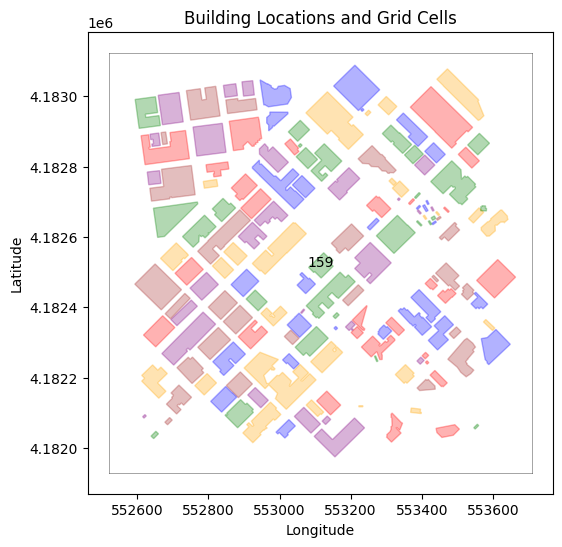

159


In [29]:

test_data_df = pd.read_csv('test_case.csv')

test_case = '3-2'
sample_lat = test_data_df[test_data_df['index']==test_case]['sample_lat'].values[0]
sample_lon = test_data_df[test_data_df['index']==test_case]['sample_lon'].values[0]
threshold = test_data_df[test_data_df['index']==test_case]['radius'].values[0]

# Filter the DataFrame
SF_filtered = gdf[(gdf['lat_utm'] > (sample_lat - threshold)) & (gdf['lat_utm'] < (sample_lat + threshold)) &
                 (gdf['lon_utm'] > (sample_lon - threshold)) & (gdf['lon_utm'] < (sample_lon + threshold))]
test = SF_filtered
print(test.shape)

# 使用 .loc 方法来安全地添加新列
test.loc[:, 'FootprintPointsStr'] = test['coordinates'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)

# 保存到 CSV，确保没有索引
test[['ID', 'Height', 'coordinates']].to_csv('ORNL563_forGH.csv', index=False)

xxx_xy=[]
xxx=[]
xxx_gaodu=[]
for index, row in test.iterrows():
    # border_points = row['formatted_geometry']
    # height = row['hgt_median_m']
    border_points = row['coordinates']
    height = row['Height']
    
    y, x = zip(*border_points)
    x=list(x)
    y=list(y)
    arrayx = np.array(x)
    arrayy = np.array(y)
    z=np.zeros(len(list(x)))
    z_height=[height]*(len(list(x)))
    zuobiao_xy=zip(list(arrayx),list(arrayy))
    zuobiao=zip(list(arrayx),list(arrayy),list(z))
    zuobiao_gaodu=zip(list(arrayx),list(arrayy),list(z_height))
    xxx_xy.append(list(zuobiao_xy))
    xxx.append(list(zuobiao))
    xxx_gaodu.append(list(zuobiao_gaodu))    
#define analysis area
num_cell = 1
buildings_analysis_xy=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis_height=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
bounds = [[0]*num_cell for _ in range(num_cell)]
bounds
offset = 100
lat_max = test['lat_utm'].max()+offset
lat_min = test['lat_utm'].min()-offset
lon_max = test['lon_utm'].max()+offset
lon_min = test['lon_utm'].min()-offset

lat_step = (lat_max - lat_min) / num_cell
lon_step = (lon_max - lon_min) / num_cell
num_building = 0
for i in range(0,num_cell,1):
    for j in range(0,num_cell,1):
        bounds[i][j] = [lat_min + j * lat_step, lon_min + i * lon_step, lat_min + (j + 1) * lat_step, lon_min + (i + 1) * lon_step]
        for t in range(len(xxx)):
            #filter the buildings
            center=np.mean(np.array(xxx[t]),axis=0)
            if center[0]> bounds[i][j][0] and center[0] <=  bounds[i][j][2] and center[1] >  bounds[i][j][1] and center[1] <=  bounds[i][j][3]:
                buildings_analysis_xy[i][j].append(xxx_xy[t])
                buildings_analysis[i][j].append(xxx[t])
                buildings_analysis_height[i][j].append(xxx_gaodu[t])
                num_building +=1
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            print(f"Grid cell ({i}, {j}) contains {len(buildings_analysis[i][j])} buildings")
        # else:
        #     print(f"Grid cell ({i}, {j}) NOT contains buildings")
print(len(xxx))
print(num_building)
# Plotting the grid and buildings
fig, ax = plt.subplots(figsize=(6,6))

# Plot the grid
for i in range(num_cell + 1):
    plt.plot([lon_min, lon_max], [lat_min + i * lat_step, lat_min + i * lat_step], color='black',linewidth = 0.5, alpha = 0.5)
for j in range(num_cell + 1):
    plt.plot([lon_min + j * lon_step, lon_min + j * lon_step], [lat_min, lat_max], color='black',linewidth = 0.5, alpha = 0.5)

# Plot the buildings with polylines
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # Define some colors for different buildings
for t, building in enumerate(xxx_xy):
    building = np.array(building)
    # plt.plot(building[:, 1], building[:, 0], marker='o', linestyle='-', color=colors[t % len(colors)], label=f'Building {t}')
    plt.fill(building[:, 1], building[:, 0], color=colors[t % len(colors)], alpha=0.3)  # Fill the polygon for better visualization
    print(building[:, 1], building[:, 0])

numbuilding = 0
# Annotate grid cells with building count
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            numbuilding += len(buildings_analysis[i][j])
            cell_center_lat = (bounds[i][j][0] + bounds[i][j][2]) / 2
            cell_center_lon = (bounds[i][j][1] + bounds[i][j][3]) / 2
            ax.text(cell_center_lon, cell_center_lat, f"{len(buildings_analysis[i][j])}", 
                    color='black', fontsize=10, ha='center', va='center')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
title = 'Building Locations and Grid Cells'
plt.title(title)
plt.show()
# plt.savefig(f'{title}.png',bbox_inches='tight',transparent=True)
print(numbuilding)

In [30]:
As_list_pd = pd.read_csv('solar azimuth angle.csv')
As_list = As_list_pd['Solar\nAzimuth:'].to_list()
hs_list = As_list_pd['Solar\nElevation:'].to_list()
def calculate_geometry_metrics(coords, geom_type='Polygon'):
    if geom_type == 'Polygon':
        geom = Polygon(coords)
        centroid = geom.centroid
        area = geom.area
        return area, (centroid.x, centroid.y)
    elif geom_type == 'LineString':
        geom = LineString(coords)
        length = geom.length
        midpoint_x = (coords[0][0] + coords[1][0]) / 2
        midpoint_y = (coords[0][1] + coords[1][1]) / 2
        return length, (midpoint_x, midpoint_y)
def calculate_azimuth(point1, point2):
    dx = point2[0] - point1[0] # x is longtitude, this calculates diff in long
    dy = point2[1] - point1[1] # latitude
    azimuth = degrees(atan2(dy, dx))
    azimuth = (azimuth-90)% 360  # Ensure the angle is between 0 and 360 degrees
    return azimuth

def calPlaneFrom3Points(Point1,Point2,Point3):
    xo1=Point1[0]
    yo1=Point1[1]
    zo1=Point1[2]
    xo2=Point2[0]
    yo2=Point2[1]
    zo2=Point2[2]
    xo3=Point3[0]
    yo3=Point3[1]
    zo3=Point3[2]
    a=(yo2-yo1)*(zo3-zo1)-(yo3-yo1)*(zo2-zo1)
    b=(zo2-zo1)*(xo3-xo1)-(zo3-zo1)*(xo2-xo1)
    c=(xo2-xo1)*(yo3-yo1)-(xo3-xo1)*(yo2-yo1)
    d=-(a*xo1+b*yo1+c*zo1)
    return a,b,c,d

#求线面交点定义的函数
def calCoordinateFromLineAndPlane(P1,F1,PlaneParams):
    a=np.array(PlaneParams[0])
    b=np.array(PlaneParams[1])
    c=np.array(PlaneParams[2])
    d=np.array(PlaneParams[3])
    x1=np.array(P1[0])
    y1=np.array(P1[1])
    z1=np.array(P1[2])
    m=np.array(F1[0])
    n=np.array(F1[1])
    p=np.array(F1[2])
    t=(-a*x1-b*y1-c*z1-d)/(a*m+b*n+c*p)
    x=m*t+x1
    y=n*t+y1
    z=p*t+z1
    return x,y,z

In [31]:
buildings_analyzed = 0
unique_building_id = 0
results = {}
building_loc_metadata = {}
building_loc = []
for r in range(0,num_cell,1):
    for w in range(0,num_cell,1):
        for q in tqdm(range(len(buildings_analysis[r][w]))):
            cell_key = f'cell_{r}_{w}'
            building_key = f'building_{unique_building_id}'
            cell_key_loc = f'cell_{r}_{w}'
            building_key_loc = f'building_{unique_building_id}'
            if cell_key not in building_loc_metadata:
                building_loc_metadata[cell_key] = {}
            if building_key not in building_loc_metadata[cell_key]:
                building_loc_metadata[cell_key][building_key] = {
                    'roof_loc': None,
                    'facade_loc': {},
                    'facade_azimuth': {}
                }
            building_target=buildings_analysis[r][w][q]
            building_target_xy=buildings_analysis_xy[r][w][q]    
            building_target_dingmian=buildings_analysis_height[r][w][q] # 建筑三维坐标数据组
            
            original_roof_area, roof_centroid = calculate_geometry_metrics(building_target_xy, geom_type='Polygon')
            original_facade_areas = []
            facade_azimuths = []
            facade_loc = []
            building_loc.append(building_target_xy)
            building_loc_metadata[cell_key][building_key]['roof_loc'] = building_target_xy
            for u in range(len(building_target) - 1):
                
                segment_length, segment_midpoint = calculate_geometry_metrics([building_target[u], building_target[u + 1]], geom_type='LineString')
                height = building_target_dingmian[u][2]  # Assuming the height is the z-coordinate
                facade_area = segment_length * height
                original_facade_areas.append(facade_area)
                azimuth = calculate_azimuth(building_target[u], building_target[u + 1])
                facade_azimuths.append(azimuth)
                facade_loc.append(segment_midpoint)
            building_loc_metadata[cell_key][building_key]['facade_loc'] = facade_loc
            building_loc_metadata[cell_key][building_key]['facade_azimuth'] = facade_azimuths

            # Calculate cos values for BASE coordinates
            cos_=[]
            for l in range(0,len(building_target)-1,1):
                f_l=np.array(building_target_xy[l+1])-np.array(building_target_xy[l])
                xx=np.array([1,0])
                l_xx=np.sqrt(xx.dot(xx))
                l_f_l=np.sqrt(f_l.dot(f_l))
                dian=xx.dot(f_l)
                cos_.append(dian/(l_xx*l_f_l))

            # Calculate center and radius of bounding circle
            #求建筑基低中心坐标，即最小外接矩形中心点坐标,1是目标建筑
            p1=Polygon(building_target_xy)     
            xmin=p1.bounds[0]
            ymin=p1.bounds[1]
            xmax=p1.bounds[2]
            ymax=p1.bounds[3]
            cx1=(xmin+xmax)/2
            cy1=(ymin+ymax)/2
            pc1=Point(cx1,cy1)
            
            #求目标建筑最小包围圆的半径，即基底中心到各顶点距离的最大值
            round_r = max(pc1.distance(Point(coord)) for coord in building_target_xy)
            
            # print("目标建筑最小包围圆的半径",round_r)
            # print("目标建筑是",r,w,"格子里的第",q+1,"个建筑")
            
            lat=38
            p=math.pi

            for k in range (164,165):
                for i in range(24):
                    hs = hs_list[i] 
                    if hs<=0:
                        continue
                    As = As_list[i]

                    sun=np.array([-math.sin(As*p/180)*math.cos(hs*p/180),-math.cos(As*p/180)*math.cos(hs*p/180),-math.sin(hs*p/180)])

                    print(sun)


                    sec_f=Polygon()
                    s_mian=[Polygon()]*(len(building_target)-1)
                    s_mian_shu=[0]*(len(building_target)-1)


                    #筛选目标建筑向阳面
                    u_box=[]
                    for u in range(0,len(building_target)-1,1):
                        building_v1=building_target[u]
                        building_v2=building_target[u+1]
                        building_v3=building_target_dingmian[u]

                        v31=np.array(building_v3)-np.array(building_v1)
                        v21=np.array(building_v2)-np.array(building_v1)
                        normal=np.cross(v31,v21)

                        # 分别计算两个向量的模：
                        l_normal=np.sqrt(normal.dot(normal))
                        l_sun=np.sqrt(sun.dot(sun))

                        # 计算两个向量的点积
                        dian=normal.dot(sun)

                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                        cos=dian/(l_normal*l_sun)
                        if cos>0:
                            u_box.append(u)
                            
                    #筛选目标建筑会被自己遮挡的向阳面 （所有向阳面）
                    u_mian=[]
                    for e in range(0,len(u_box),1):
                        u=u_box[e]
                        if xmin<building_target[u][0]<xmax and  xmin<building_target[u+1][0]<xmax and ymin<building_target[u][1]<ymax and  ymin<building_target[u+1][1]<ymax:
                            u_mian.append(u)

                    
                    #求自遮挡（其他向阳面及顶面对mm面造成的遮挡）
                    for h in range(0,len(u_mian),1):    
                        mm=u_mian[h]
                        for e in range(0,len(u_box),1):
                            u=u_box[e]            
                            if u!=mm:          
                                PlaneParams=calPlaneFrom3Points(building_target[mm],building_target[mm+1],building_target_dingmian[mm+1])
                                #当受到自遮挡的目标面是与x轴平行的面,y一样的
                                if building_target[mm][0]!=building_target[mm+1][0]:
                                    polygon_mian=Polygon([[building_target[mm][0],building_target[mm][2]],[building_target[mm+1][0],building_target[mm+1][2]],[building_target_dingmian[mm+1][0],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][0],building_target_dingmian[mm][2]]])
                                    xyz1=calCoordinateFromLineAndPlane(building_target[u],sun,PlaneParams)
                                    xyz1_arr=np.asarray(xyz1)
                                    point1=(xyz1_arr[0],xyz1_arr[2])
                                    xyz2=calCoordinateFromLineAndPlane(building_target[u+1],sun,PlaneParams)
                                    xyz2_arr=np.asarray(xyz2)
                                    point2=(xyz2_arr[0],xyz2_arr[2])
                                    xyz3=calCoordinateFromLineAndPlane(building_target_dingmian[u+1],sun,PlaneParams)
                                    xyz3_arr=np.asarray(xyz3)
                                    point3=(xyz3_arr[0],xyz3_arr[2])                        
                                    xyz4=calCoordinateFromLineAndPlane(building_target_dingmian[u],sun,PlaneParams)
                                    xyz4_arr=np.asarray(xyz4)
                                    point4=(xyz4_arr[0],xyz4_arr[2])
                                    targetbd=Polygon([point1,point2,point3,point4])

                                    s_mian[mm]=s_mian[mm].union(targetbd)
                                    s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                                    s_mian_shu[mm]=s_mian[mm].area/abs(cos_[mm])
                                    # print(s_mian_shu)


                                #当受到自遮挡的目标面是与y轴平行的面，x一样的
                                if building_target[mm][0]==building_target[mm+1][0]:
                                    polygon_mian=Polygon([[building_target[mm][1],building_target[mm][2]],[building_target[mm+1][1],building_target[mm+1][2]],[building_target_dingmian[mm+1][1],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][1],building_target_dingmian[mm][2]]])            
                                    xyz1=calCoordinateFromLineAndPlane(building_target[u],sun,PlaneParams)
                                    xyz1_arr=np.asarray(xyz1)
                                    point1=(xyz1_arr[1],xyz1_arr[2])
                                    xyz2=calCoordinateFromLineAndPlane(building_target[u+1],sun,PlaneParams)
                                    xyz2_arr=np.asarray(xyz2)
                                    point2=(xyz2_arr[1],xyz2_arr[2])
                                    xyz3=calCoordinateFromLineAndPlane(building_target_dingmian[u+1],sun,PlaneParams)
                                    xyz3_arr=np.asarray(xyz3)
                                    point3=(xyz3_arr[1],xyz3_arr[2])                        
                                    xyz4=calCoordinateFromLineAndPlane(building_target_dingmian[u],sun,PlaneParams)
                                    xyz4_arr=np.asarray(xyz4)
                                    point4=(xyz4_arr[1],xyz4_arr[2])
                                    targetbd=Polygon([point1,point2,point3,point4])

                                    s_mian[mm]=s_mian[mm].union(targetbd)
                                    s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                                    s_mian_shu[mm]=s_mian[mm].area/abs(cos_[mm])      

                        #计算顶面的遮挡面积
                        point_ding=[]
                        PlaneParams=calPlaneFrom3Points(building_target[mm],building_target[mm+1],building_target_dingmian[mm+1])

                        if building_target[mm][0]!=building_target[mm+1][0]:

                            polygon_mian=Polygon([[building_target[mm][0],building_target[mm][2]],[building_target[mm+1][0],building_target[mm+1][2]],[building_target_dingmian[mm+1][0],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][0],building_target_dingmian[mm][2]]])
                            for s in range(0,len(building_target_dingmian)-1,1):
                                xyz=calCoordinateFromLineAndPlane(building_target_dingmian[s],sun,PlaneParams)
                                xyz_arr=np.asarray(xyz)
                                point=(xyz_arr[0],xyz_arr[2])
                                point_ding.append(point)
                            targetbd_ding=Polygon(point_ding)
                            targetbd_ding=make_valid(targetbd_ding)
                            s_mian[mm]=s_mian[mm].union(targetbd_ding)
                            s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                            s_mian_shu[mm]=s_mian[mm].area/abs(cos_[mm])

 
                        if building_target[mm][0]==building_target[mm+1][0]:
                            polygon_mian=Polygon([[building_target[mm][1],building_target[mm][2]],[building_target[mm+1][1],building_target[mm+1][2]],[building_target_dingmian[mm+1][1],building_target_dingmian[mm+1][2]],[building_target_dingmian[mm][1],building_target_dingmian[mm][2]]])            
                            for s in range(0,len(building_target)-1,1):
                                xyz=calCoordinateFromLineAndPlane(building_target_dingmian[s],sun,PlaneParams)
                                xyz_arr=np.asarray(xyz)
                                point=(xyz_arr[1],xyz_arr[2])
                                point_ding.append(point)
                            targetbd_ding=Polygon(point_ding)
                            targetbd_ding=make_valid(targetbd_ding)

                            s_mian[mm]=s_mian[mm].union(targetbd_ding)
                            s_mian[mm]=polygon_mian.intersection(s_mian[mm])                                               
                            s_mian_shu[mm]=s_mian[mm].area         
            
            
                    #一栋一栋求邻域建筑的阴影
                    for n in range(len(buildings_analysis[r][w])):
                        if n==q:
                            continue
                        if n!=q:
                            building_near_xy=buildings_analysis_xy[r][w][n]
                            building_near=buildings_analysis[r][w][n]
                            building_near_dingmian=buildings_analysis_height[r][w][n]

                        cxn=(Polygon(building_near_xy).bounds[0]+Polygon(building_near_xy).bounds[2])/2
                        cyn=(Polygon(building_near_xy).bounds[1]+Polygon(building_near_xy).bounds[3])/2
                        pcn=Point(cxn,cyn)
                        # print(n,"第n个建筑基底中心坐标",cxn,cyn)
                        #求两两建筑修正过的欧几里得距离
                        dis_bds=pc1.distance(pcn)-round_r
                        # print("两建筑距离",dis_bds)


                        #判断距离是否小于R
                        Hmax=building_near_dingmian[0][2]/math.tan(hs*p/180)
                        # print("这是最小建筑距离Hmax:",Hmax)
                        if dis_bds<= Hmax:
                            if As<90 and As>=0:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[2]>p1.bounds[0] and Polygon(building_near_xy).bounds[3]>p1.bounds[1]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)

                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                            if As<180 and As>=90:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[2]>p1.bounds[0] and Polygon(building_near_xy).bounds[1]<p1.bounds[3]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                                            
                            if As<270 and As>=180:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[0]<p1.bounds[2] and Polygon(building_near_xy).bounds[1]<p1.bounds[3]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])



                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)        

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)                     

                                            
                            if As<360 and As>=270:                                                
                                #筛选太阳矢量所在象限建筑
                                if Polygon(building_near_xy).bounds[0]<p1.bounds[2] and Polygon(building_near_xy).bounds[3]>p1.bounds[1]: 
                                    #筛选邻域建筑背阴面
                                    z_box=[]
                                    for z in range(0,len(building_near)-1,1):
                                        building_v1=building_near[z]
                                        building_v2=building_near[z+1]
                                        building_v3=building_near_dingmian[z]

                                        v31=np.array(building_v3)-np.array(building_v1)
                                        v21=np.array(building_v2)-np.array(building_v1)
                                        normal=np.cross(v31,v21)

                                        # 分别计算两个向量的模：
                                        l_normal=np.sqrt(normal.dot(normal))
                                        l_sun=np.sqrt(sun.dot(sun))

                                        # 计算两个向量的点积
                                        dian=normal.dot(sun)

                                        # 计算夹角的cos值,0到1之间说明是背阴面，其他则是向阳面，这里找的是立面，顶面一定向阳：
                                        cos=dian/(l_normal*l_sun)
                                        if cos<0:
                                            z_box.append(z)
                                    # print("邻域建筑的背阴面",n,z_box)


                                    #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                                    for e in range(0,len(u_box),1):
                                        targetbd_n=Polygon()
                                        u=u_box[e]                                
                                        PlaneParams=calPlaneFrom3Points(building_target[u],building_target[u+1],building_target_dingmian[u+1])
                                        for g in range(0,len(z_box),1):
                                            P1=building_near[z_box[g]]
                                            P2=building_near[z_box[g]+1]
                                            P3=building_near_dingmian[z_box[g]+1]
                                            P4=building_near_dingmian[z_box[g]]
                                            F1=sun            

                                            xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                            xyz1_arr=np.asarray(xyz1)
                                            xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                            xyz2_arr=np.asarray(xyz2)
                                            xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                            xyz3_arr=np.asarray(xyz3)
                                            xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                            xyz4_arr=np.asarray(xyz4)

                                            if building_target[u][0]==building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][1],building_target[u][2]],[building_target[u+1][1],building_target[u+1][2]],[building_target_dingmian[u+1][1],building_target_dingmian[u+1][2]],[building_target_dingmian[u][1],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[1],xyz1_arr[2])
                                                point2=(xyz2_arr[1],xyz2_arr[2])
                                                point3=(xyz3_arr[1],xyz3_arr[2])
                                                point4=(xyz4_arr[1],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u])                                               
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])


                                            if building_target[u][0]!=building_target[u+1][0]:
                                                polygon_mian=Polygon([[building_target[u][0],building_target[u][2]],[building_target[u+1][0],building_target[u+1][2]],[building_target_dingmian[u+1][0],building_target_dingmian[u+1][2]],[building_target_dingmian[u][0],building_target_dingmian[u][2]]])            
                                                point1=(xyz1_arr[0],xyz1_arr[2])
                                                point2=(xyz2_arr[0],xyz2_arr[2])
                                                point3=(xyz3_arr[0],xyz3_arr[2])
                                                point4=(xyz4_arr[0],xyz4_arr[2])
                                                targetbd_n=targetbd_n.union(Polygon([point1,point2,point3,point4]))
                                                if g==len(z_box)-1:
                                                    s_mian[u]=s_mian[u].union(targetbd_n)
                                                    s_mian[u]=polygon_mian.intersection(s_mian[u]) 
                                                    s_mian_shu[u]=s_mian[u].area/abs(cos_[u])

                                    #邻域建筑背阴面的顶点跟目标建筑顶面的交点
                                    targetbd_ding_n=Polygon()
                                    PlaneParams=calPlaneFrom3Points(building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2])
                                    for g in range(0,len(z_box),1):
                                        P1=building_near[z_box[g]]
                                        P2=building_near[z_box[g]+1]
                                        P3=building_near_dingmian[z_box[g]+1]
                                        P4=building_near_dingmian[z_box[g]]
                                        F1=sun            

                                        xyz1=calCoordinateFromLineAndPlane(P1,F1,PlaneParams)
                                        xyz1_arr=np.asarray(xyz1)
                                        xyz2=calCoordinateFromLineAndPlane(P2,F1,PlaneParams)
                                        xyz2_arr=np.asarray(xyz2)
                                        xyz3=calCoordinateFromLineAndPlane(P3,F1,PlaneParams)
                                        xyz3_arr=np.asarray(xyz3)
                                        xyz4=calCoordinateFromLineAndPlane(P4,F1,PlaneParams)
                                        xyz4_arr=np.asarray(xyz4)

                                        polygon_ding=Polygon(building_target)
                                        point1=(xyz1_arr[0],xyz1_arr[1])
                                        point2=(xyz2_arr[0],xyz2_arr[1])
                                        point3=(xyz3_arr[0],xyz3_arr[1])
                                        point4=(xyz4_arr[0],xyz4_arr[1])
                                        targetbd_ding_n=targetbd_ding_n.union(Polygon([point1,point2,point3,point4]))
                                        targetbd_ding_n = make_valid(targetbd_ding_n)
                                        if g==len(z_box)-1:
                                            sec_f=sec_f.union(targetbd_ding_n)
                                            sec_f=polygon_ding.intersection(sec_f)

                    if n==len(buildings_analysis[r][w])-1:
                        for e in range(0,len(u_box),1):
                            u=u_box[e]
                            print("目标建筑第",u,"个立面的总阴影面积是：",s_mian_shu[u])
                        print("目标建筑顶面的总阴影面积是：",sec_f.area)
                    cell_key = f'cell_{r}_{w}'
                    building_key = f'building_{unique_building_id}'
                    day_key = f'day_{k}'
                    hour_key = f'hour_{i}'
                    if cell_key not in results:
                        results[cell_key] = {}
                    if building_key not in results[cell_key]:
                        results[cell_key][building_key] = {}
                    if day_key not in results[cell_key][building_key]:
                        results[cell_key][building_key][day_key] = {}
                    if hour_key not in results[cell_key][building_key][day_key]:
                        results[cell_key][building_key][day_key][hour_key] = {
                            'roof_original':None,
                            'roof': None,
                            'facade_original':{},
                            'facade': {},
                        }
                    for e in range(len(u_box)):
                        u = u_box[e]
                        shading_area = s_mian_shu[u]
                        remaining_area = original_facade_areas[u] - shading_area
                        results[cell_key][building_key][day_key][hour_key]['facade_original'][u] = original_facade_areas[u] 
                        results[cell_key][building_key][day_key][hour_key]['facade'][u] = s_mian_shu[u]

                    shading_area_roof = sec_f.area
                    remaining_roof_area = original_roof_area - shading_area
                    results[cell_key][building_key][day_key][hour_key]['roof_original'] = original_roof_area
                    results[cell_key][building_key][day_key][hour_key]['roof'] = sec_f.area

                    buildings_analyzed += 1
            unique_building_id +=1
print(buildings_analyzed)
with open('results_original_code.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)
with open('results_building_loc_original_code.json', 'w') as json_file:
    json.dump(building_loc_metadata, json_file, indent=4)
print("result saved to results_original_code.json")


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 689.066560550034
目标建筑第 1 个立面的总阴影面积是： 610.7120302685523
目标建筑顶面的总阴影面积是： 174.16703911534387
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 689.066560550034
目标建筑第 1 个立面的总阴影面积是： 610.7120302685523
目标建筑顶面的总阴影面积是： 174.16703911598478
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 689.066560550034
目标建筑第 1 个立面的总阴影面积是： 610.7120302685523
目标建筑顶面的总阴影面积是： 174.1670391149445
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 689.066560550034
目标建筑第 1 个立面的总阴影面积是： 610.7037630244989
目标建筑顶面的总阴影面积是： 113.37379734656837
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 631.6322687137173
目标建筑第 1 个立面的总阴影面积是： 428.77362000356305
目标建筑顶面的总阴影面积是： 21.044814652617198
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 42.34450611841238
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 2.8910565184512507
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 

  1%|▌                                                                                 | 1/159 [00:00<01:11,  2.20it/s]

目标建筑第 2 个立面的总阴影面积是： 623.068160663529
目标建筑第 3 个立面的总阴影面积是： 603.4840248355474
目标建筑顶面的总阴影面积是： 24.550975109611024
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 3522.5064476286884
目标建筑第 1 个立面的总阴影面积是： 3012.8287527554867
目标建筑第 3 个立面的总阴影面积是： 1788.1753603857433
目标建筑第 6 个立面的总阴影面积是： 3451.0850770295333
目标建筑顶面的总阴影面积是： 3040.0549127416225
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 3522.5064476286884
目标建筑第 1 个立面的总阴影面积是： 3012.828752755486
目标建筑第 3 个立面的总阴影面积是： 1788.1753603857433
目标建筑第 6 个立面的总阴影面积是： 3451.0850770295333
目标建筑顶面的总阴影面积是： 3040.0549127385566
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 3522.5064476286884
目标建筑第 1 个立面的总阴影面积是： 3012.8287527554867
目标建筑第 3 个立面的总阴影面积是： 1786.8878673915594
目标建筑第 6 个立面的总阴影面积是： 3381.2060115252225
目标建筑顶面的总阴影面积是： 2073.1106497678297
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 3522.5064476286884
目标建筑第 1 个立面的总阴影面积是： 3011.557880264058
目标建筑第 3 个立面的总阴影面积是： 1556.9876954762715
目标建筑第 6 个立面的总阴影面积是： 2878.0005561706644
目标建筑顶面的总阴影面积是： 

  1%|█                                                                                 | 2/159 [00:01<01:42,  1.54it/s]

目标建筑第 2 个立面的总阴影面积是： 2292.0114201145957
目标建筑第 4 个立面的总阴影面积是： 1406.2406104220802
目标建筑第 5 个立面的总阴影面积是： 1745.8933440221203
目标建筑第 7 个立面的总阴影面积是： 1604.9053405034701
目标建筑顶面的总阴影面积是： 2137.71549509812
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 3163.3315328259446
目标建筑第 4 个立面的总阴影面积是： 2765.6476961158073
目标建筑第 5 个立面的总阴影面积是： 2964.486291568878
目标建筑第 7 个立面的总阴影面积是： 1604.9053405034701
目标建筑顶面的总阴影面积是： 2441.042856197068
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 3369.265483239672
目标建筑第 4 个立面的总阴影面积是： 3567.683768619712
目标建筑第 5 个立面的总阴影面积是： 3025.2355142562888
目标建筑第 7 个立面的总阴影面积是： 1604.9053405034701
目标建筑顶面的总阴影面积是： 2645.767115950226
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 20874.729448367387
目标建筑第 1 个立面的总阴影面积是： 8784.100436592447
目标建筑第 2 个立面的总阴影面积是： 6641.031763699879
目标建筑第 3 个立面的总阴影面积是： 3225.7193184584867
目标建筑第 4 个立面的总阴影面积是： 1488.6087390754517
目标建筑第 5 个立面的总阴影面积是： 1150.0204549278578
目标建筑第 6 个立面的总阴影面积是： 4041.390406216134
目标建筑第 8 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 1568.697

  2%|█▌                                                                                | 3/159 [00:02<02:47,  1.08s/it]

目标建筑第 2 个立面的总阴影面积是： 6729.938136550451
目标建筑第 7 个立面的总阴影面积是： 1166.3833306415404
目标建筑第 9 个立面的总阴影面积是： 9790.222426266466
目标建筑第 11 个立面的总阴影面积是： 698.3723702699791
目标建筑第 12 个立面的总阴影面积是： 5607.021474832992
目标建筑第 13 个立面的总阴影面积是： 1413.6782127129352
目标建筑第 14 个立面的总阴影面积是： 1240.2115769560583
目标建筑第 15 个立面的总阴影面积是： 9353.769006570952
目标建筑第 18 个立面的总阴影面积是： 1462.5849873445086
目标建筑第 19 个立面的总阴影面积是： 1606.1270695795463
目标建筑第 20 个立面的总阴影面积是： 8277.695404583374
目标建筑第 21 个立面的总阴影面积是： 12357.968384598707
目标建筑顶面的总阴影面积是： 5144.262533604425
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 8874.160328572725
目标建筑第 3 个立面的总阴影面积是： 6226.620088425255
目标建筑顶面的总阴影面积是： 1752.9671366989276
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 8874.160328572725
目标建筑第 3 个立面的总阴影面积是： 6226.620088425255
目标建筑顶面的总阴影面积是： 1752.96713670245
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 8874.160328572725
目标建筑第 3 个立面的总阴影面积是： 6226.620088425255
目标建筑顶面的总阴影面积是： 1752.9671367014164
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面

  3%|██                                                                                | 4/159 [00:03<02:45,  1.07s/it]

目标建筑第 1 个立面的总阴影面积是： 6226.634139394053
目标建筑第 2 个立面的总阴影面积是： 8874.172737462979
目标建筑顶面的总阴影面积是： 1752.9671366990958
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 905.744708991412
目标建筑第 1 个立面的总阴影面积是： 575.6443460804853
目标建筑顶面的总阴影面积是： 48.99177441631818
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 905.744708991412
目标建筑第 1 个立面的总阴影面积是： 575.6443460804853
目标建筑顶面的总阴影面积是： 48.991774416076325
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 905.7447089914122
目标建筑第 1 个立面的总阴影面积是： 575.6443460804853
目标建筑顶面的总阴影面积是： 48.99177441631818
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 765.6441546379385
目标建筑第 1 个立面的总阴影面积是： 509.5041364327905
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 206.68967664194952
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是：

  3%|██▌                                                                               | 5/159 [00:04<02:31,  1.02it/s]

目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 388.71903106092856
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 819.7802955984832
目标建筑第 3 个立面的总阴影面积是： 510.2055196225887
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 11321.353552755183
目标建筑第 1 个立面的总阴影面积是： 9849.742434292755
目标建筑顶面的总阴影面积是： 2682.7043010548887
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 11321.353552755183
目标建筑第 1 个立面的总阴影面积是： 9849.742434292755
目标建筑顶面的总阴影面积是： 2682.704301061475
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 11321.353552755183
目标建筑第 1 个立面的总阴影面积是： 9849.742434292755
目标建筑顶面的总阴影面积是： 2682.7043010557672
[-0.81450919 -0.05153002 -0.

  4%|███                                                                               | 6/159 [00:05<02:33,  1.00s/it]

目标建筑第 2 个立面的总阴影面积是： 11048.828405235496
目标建筑第 3 个立面的总阴影面积是： 9111.332463017965
目标建筑顶面的总阴影面积是： 265.70559457961866
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 11003.554632897198
目标建筑第 3 个立面的总阴影面积是： 9414.718982834514
目标建筑顶面的总阴影面积是： 17.68068731074618
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 11100.497623046234
目标建筑第 3 个立面的总阴影面积是： 9771.55552988234
目标建筑顶面的总阴影面积是： 41.79665432670604
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3939.41912244832
目标建筑第 2 个立面的总阴影面积是： 4013.842272378157
目标建筑顶面的总阴影面积是： 595.7015114102538
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 3939.41912244832
目标建筑第 2 个立面的总阴影面积是： 4013.842272378157
目标建筑顶面的总阴影面积是： 595.7015114120253
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 3669.6951546360997
目标建筑第 2 个立面的总阴影面积是： 3631.4943478009527
目标建筑顶面的总阴影面积是： 37.803406740632
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 3659.1540667531344
目标建筑第 2 个立面的总阴影面积是： 3435.7909879792455
目标建筑顶面的总阴影面积是： 46.48527097032057
[-0.67

  4%|███▌                                                                              | 7/159 [00:06<02:22,  1.07it/s]

目标建筑第 0 个立面的总阴影面积是： 3262.80500984834
目标建筑第 3 个立面的总阴影面积是： 3086.434855514856
目标建筑顶面的总阴影面积是： 595.7015114118108
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 3592.1065407979545
目标建筑第 3 个立面的总阴影面积是： 3664.2561719467567
目标建筑顶面的总阴影面积是： 414.81598795621267
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 3887.986325367327
目标建筑第 3 个立面的总阴影面积是： 3780.444793866789
目标建筑顶面的总阴影面积是： 338.73037102841323
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 4013.8460541384566
目标建筑第 3 个立面的总阴影面积是： 3730.03208210342
目标建筑顶面的总阴影面积是： 423.9402091060508
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 2384.7774009521468
目标建筑第 2 个立面的总阴影面积是： 8391.863542022116
目标建筑第 5 个立面的总阴影面积是： 5521.076452246753
目标建筑顶面的总阴影面积是： 2367.625681927807
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 2384.7774009521468
目标建筑第 2 个立面的总阴影面积是： 8391.863542022114
目标建筑第 5 个立面的总阴影面积是： 5521.076452246753
目标建筑顶面的总阴影面积是： 2367.6256819256964
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 2384.77740095214

  5%|████▏                                                                             | 8/159 [00:07<02:32,  1.01s/it]

目标建筑第 0 个立面的总阴影面积是： 47.29210239194756
目标建筑第 3 个立面的总阴影面积是： 7773.655938021399
目标建筑第 4 个立面的总阴影面积是： 8298.985170730204
目标建筑顶面的总阴影面积是： 310.84308761770194
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 38979.09763475747
目标建筑第 2 个立面的总阴影面积是： 1710.4536061407446
目标建筑顶面的总阴影面积是： 6363.35918011748
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 38979.09763475747
目标建筑第 2 个立面的总阴影面积是： 1710.4536061407446
目标建筑顶面的总阴影面积是： 6145.670900056006
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 37715.99700218954
目标建筑第 2 个立面的总阴影面积是： 1710.4536061407446
目标建筑顶面的总阴影面积是： 455.40063660813985
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 37220.81690933315
目标建筑第 2 个立面的总阴影面积是： 1710.4536061407446
目标建筑顶面的总阴影面积是： 828.1912526326731
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 36532.740156052714
目标建筑第 2 个立面的总阴影面积是： 1143.2139894757445
目标建筑顶面的总阴影面积是： 1324.0334663403792
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 36618.49644463669
目标建筑顶面的总阴影

  6%|████▋                                                                             | 9/159 [00:08<02:37,  1.05s/it]

目标建筑第 2 个立面的总阴影面积是： 1710.4536061407446
目标建筑第 3 个立面的总阴影面积是： 35985.85328694915
目标建筑第 4 个立面的总阴影面积是： 4152.500721680685
目标建筑顶面的总阴影面积是： 2531.51465712119
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 3871.4291177630093
目标建筑顶面的总阴影面积是： 59.2179299910437
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 3605.0583698340174
目标建筑顶面的总阴影面积是： 11.932040896925391
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 4188.906853197116
目标建筑第 1 个立面的总阴影面积是： 3320.165784407055
目标建筑顶面的总阴影面积是： 9.696093436342107
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 7205.227270232091
目标建筑第 1 个立面的总阴影面积是： 3816.1746176414563
目标建筑顶面的总阴影面积是： 31.28003350077889
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 7602.352993150355
目标建筑第 1 个立面的总阴影面积是： 4643.218491331927
目标建筑顶面的总阴影面积是： 148.65372177657886
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 8481.662999502296
目标建筑第 1 个立面的总阴影面积是： 4650.646251766699
目标建筑顶面的总阴影面积是： 385.319420972

  6%|█████                                                                            | 10/159 [00:09<02:09,  1.15it/s]

目标建筑第 0 个立面的总阴影面积是： 7140.374359575477
目标建筑第 1 个立面的总阴影面积是： 4650.646251766699
目标建筑顶面的总阴影面积是： 685.0639630106349
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 1505.0640476413555
目标建筑第 3 个立面的总阴影面积是： 29.999617892581668
目标建筑顶面的总阴影面积是： 83.9777929195266
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 5027.861988828256
目标建筑第 3 个立面的总阴影面积是： 1260.1541014888428
目标建筑顶面的总阴影面积是： 754.0836751291156
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 2 个立面的总阴影面积是： 7549.2114359670595
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 308.23395052651136
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 2 个立面的总阴影面积是： 4185.652137605066
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 123.57631476653967
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 3085.902212439881
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 74.70078636965437
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 5878.057174692037
目标建筑第 3 个立面的总阴影面积是： 963.0571794451571
目标建筑顶面的总阴影面积是： 63.239702505275844
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2

  7%|█████▌                                                                           | 11/159 [00:10<02:02,  1.21it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 2157.549731014046
目标建筑顶面的总阴影面积是： 155.5656128748794
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 3208.767303970398
目标建筑第 3 个立面的总阴影面积是： 3102.3968748076013
目标建筑顶面的总阴影面积是： 1051.2969412110642
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 2 个立面的总阴影面积是： 1101.0836490629945
目标建筑第 3 个立面的总阴影面积是： 3291.700736570535
目标建筑顶面的总阴影面积是： 2033.5834177214272
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 2 个立面的总阴影面积是： 4413.353170609454
目标建筑第 3 个立面的总阴影面积是： 3692.585053994822
目标建筑顶面的总阴影面积是： 2379.0533520945396
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 5109.503429695529
目标建筑第 3 个立面的总阴影面积是： 4746.66888754144
目标建筑顶面的总阴影面积是： 2486.2725100273065
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 5605.910822720736
目标建筑第 3 个立面的总阴影面积是： 6314.6707174389085
目标建筑顶面的总阴影面积是： 2486.2725100215566
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 5700.54751153052
目标建筑第 3 个立面的总阴影面积是： 8172.680314888177
目标建筑顶面的总阴影面积是： 2486.2725100274847
[ 0.89667932 -0.

  8%|██████                                                                           | 12/159 [00:10<01:56,  1.26it/s]

目标建筑第 0 个立面的总阴影面积是： 2914.9050458606157
目标建筑第 3 个立面的总阴影面积是： 7496.264780836294
目标建筑顶面的总阴影面积是： 456.6857596483743
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2914.9050458606157
目标建筑第 3 个立面的总阴影面积是： 7496.264780836294
目标建筑顶面的总阴影面积是： 456.6857596483743
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 9723.116316905818
目标建筑第 5 个立面的总阴影面积是： 7821.347901345066
目标建筑第 6 个立面的总阴影面积是： 1479.5799492851063
目标建筑第 7 个立面的总阴影面积是： 808.2851681259388
目标建筑顶面的总阴影面积是： 2098.304652487965
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 9723.11631690582
目标建筑第 5 个立面的总阴影面积是： 7821.347901345066
目标建筑第 6 个立面的总阴影面积是： 1479.5799492851063
目标建筑第 7 个立面的总阴影面积是： 808.2851681259388
目标建筑顶面的总阴影面积是： 2098.3046524854685
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 9723.11631690582
目标建筑第 5 个立面的总阴影面积是： 7821.347901345066
目标建筑第 6 个立面的总阴影面积是： 1479.5799492851063
目标建筑第 7 个立面的总阴影面积是： 808.2851681259388
目标建筑顶面的总阴影面积是： 2098.3046524911397
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 9723.1163169

  8%|██████▌                                                                          | 13/159 [00:11<02:05,  1.16it/s]

目标建筑第 1 个立面的总阴影面积是： 6215.971287403634
目标建筑第 2 个立面的总阴影面积是： 5202.503561191558
目标建筑第 3 个立面的总阴影面积是： 970.1657946328068
目标建筑第 4 个立面的总阴影面积是： 4040.954044272623
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1184.1226047444025
目标建筑第 2 个立面的总阴影面积是： 1285.8612047234967
目标建筑顶面的总阴影面积是： 52.102054868761456
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1184.1226047444025
目标建筑第 2 个立面的总阴影面积是： 1285.8612047234967
目标建筑顶面的总阴影面积是： 52.10205486869458
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 901.1227343559746
目标建筑第 2 个立面的总阴影面积是： 991.3289042241321
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 850.5652320150389
目标建筑第 2 个立面的总阴影面积是： 893.220316347224
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 695.9867480739747
目标建筑第 2 个立面的总阴影面积是： 809.0358050629245
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 279.89549608992905
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537

  9%|███████▏                                                                         | 14/159 [00:12<01:52,  1.29it/s]

目标建筑第 0 个立面的总阴影面积是： 928.0101269225763
目标建筑第 3 个立面的总阴影面积是： 498.244223624925
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 526.5721590597627
目标建筑第 3 个立面的总阴影面积是： 496.8184797803824
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 31293.882395468558
目标建筑第 1 个立面的总阴影面积是： 16643.90759847018
目标建筑第 4 个立面的总阴影面积是： 1727.4809304877897
目标建筑第 12 个立面的总阴影面积是： 6840.880071410338
目标建筑顶面的总阴影面积是： 3752.5154496232326
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 31293.882395468558
目标建筑第 1 个立面的总阴影面积是： 16643.90759847018
目标建筑第 4 个立面的总阴影面积是： 1727.4809304877897
目标建筑第 12 个立面的总阴影面积是： 6840.880071410338
目标建筑顶面的总阴影面积是： 3752.515449619929
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 28066.540876843224
目标建筑第 1 个立面的总阴影面积是： 16643.907598470185
目标建筑第 4 个立面的总阴影面积是： 1727.4809304877895
目标建筑第 12 个立面的总阴影面积是： 6840.880071410338
目标建筑顶面的总阴影面积是： 3089.9719553306113
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 24973.96305801163
目标建筑第 1 个立面的总阴影面

  9%|███████▋                                                                         | 15/159 [00:14<03:01,  1.26s/it]

目标建筑第 2 个立面的总阴影面积是： 8445.88673133142
目标建筑第 3 个立面的总阴影面积是： 1843.7801646932223
目标建筑第 5 个立面的总阴影面积是： 5619.23571612909
目标建筑第 6 个立面的总阴影面积是： 3167.0402257027677
目标建筑第 7 个立面的总阴影面积是： 1257.8318150920009
目标建筑第 8 个立面的总阴影面积是： 877.5478994073827
目标建筑第 9 个立面的总阴影面积是： 807.4730003561689
目标建筑第 10 个立面的总阴影面积是： 180.70864365701863
目标建筑第 11 个立面的总阴影面积是： 1144.114594458728
目标建筑第 12 个立面的总阴影面积是： 6504.825867725354
目标建筑第 13 个立面的总阴影面积是： 7611.479695873412
目标建筑第 14 个立面的总阴影面积是： 13713.922866529443
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 6430.5748824705815
目标建筑第 1 个立面的总阴影面积是： 4940.249207089399
目标建筑顶面的总阴影面积是： 1840.7312264317104
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 6430.5748824705815
目标建筑第 1 个立面的总阴影面积是： 4940.249207089399
目标建筑顶面的总阴影面积是： 1840.7312264235754
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 6430.5748824705815
目标建筑第 1 个立面的总阴影面积是： 4940.249207089399
目标建筑顶面的总阴影面积是： 1840.7312264292243
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 5616.2220904

 10%|████████▏                                                                        | 16/159 [00:15<02:43,  1.14s/it]

目标建筑第 2 个立面的总阴影面积是： 6282.130655295767
目标建筑第 3 个立面的总阴影面积是： 4328.23017596405
目标建筑顶面的总阴影面积是： 1254.8289791979237
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 9105.898660726609
目标建筑第 2 个立面的总阴影面积是： 2793.5524200445084
目标建筑顶面的总阴影面积是： 1959.954292517794
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 9105.898660726609
目标建筑第 2 个立面的总阴影面积是： 2793.5524200445084
目标建筑顶面的总阴影面积是： 1959.9542925091023
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 9105.898660726609
目标建筑第 2 个立面的总阴影面积是： 2793.552420044509
目标建筑顶面的总阴影面积是： 1959.9542925144926
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 9105.898660726609
目标建筑第 2 个立面的总阴影面积是： 2793.5524200445084
目标建筑顶面的总阴影面积是： 1959.9542925171197
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 9103.113459373666
目标建筑第 2 个立面的总阴影面积是： 2793.5524200445084
目标建筑顶面的总阴影面积是： 1245.9505359800019
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 8983.305801755292
目标建筑第 2 个立面的总阴影面积是： 2451.6794437522426
目标建筑顶面的总阴影面积是： 26.686955364945305

 11%|████████▋                                                                        | 17/159 [00:16<02:34,  1.09s/it]

目标建筑第 0 个立面的总阴影面积是： 2802.687701730105
目标建筑第 3 个立面的总阴影面积是： 9114.634797158316
目标建筑顶面的总阴影面积是： 1883.0095674304912
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2802.687701730105
目标建筑第 3 个立面的总阴影面积是： 9114.634797158316
目标建筑顶面的总阴影面积是： 1959.9542925174464
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 5023.454245698383
目标建筑第 2 个立面的总阴影面积是： 900.4105821863131
目标建筑第 3 个立面的总阴影面积是： 1018.8254351579084
目标建筑第 4 个立面的总阴影面积是： 5130.4558122264825
目标建筑第 6 个立面的总阴影面积是： 1099.8784130068314
目标建筑顶面的总阴影面积是： 3108.2337284503687
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 5023.454245698382
目标建筑第 2 个立面的总阴影面积是： 900.4105821863131
目标建筑第 3 个立面的总阴影面积是： 1018.8254351579084
目标建筑第 4 个立面的总阴影面积是： 5130.4558122264825
目标建筑第 6 个立面的总阴影面积是： 1099.8784130068314
目标建筑顶面的总阴影面积是： 3108.2337284422
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 5023.454245698382
目标建筑第 2 个立面的总阴影面积是： 900.4105821863131
目标建筑第 3 个立面的总阴影面积是： 1018.8254351579084
目标建筑第 4 个立面的总阴影面积是： 5130.4558122264825
目标建筑第 6 个立面的总阴影面积是： 109

 11%|█████████▏                                                                       | 18/159 [00:17<02:46,  1.18s/it]

目标建筑第 0 个立面的总阴影面积是： 6167.831286866214
目标建筑第 5 个立面的总阴影面积是： 827.9477996107704
目标建筑第 7 个立面的总阴影面积是： 4674.920209638296
目标建筑顶面的总阴影面积是： 3108.233728453971
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 6112.97596516205
目标建筑第 5 个立面的总阴影面积是： 827.9477996107704
目标建筑第 7 个立面的总阴影面积是： 4966.742732291922
目标建筑顶面的总阴影面积是： 3108.233728453971
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 6250.4832114450455
目标建筑第 5 个立面的总阴影面积是： 827.9477996107706
目标建筑第 7 个立面的总阴影面积是： 5136.241569225614
目标建筑顶面的总阴影面积是： 2233.6805290035313
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 323.8044005811803
目标建筑第 2 个立面的总阴影面积是： 366.70552472459246
目标建筑顶面的总阴影面积是： 46.27498368161689
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 323.8044005811803
目标建筑第 2 个立面的总阴影面积是： 366.70552472459246
目标建筑顶面的总阴影面积是： 46.27498368161689
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 323.80440058118023
目标建筑第 2 个立面的总阴影面积是： 366.70552472459246
目标建筑顶面的总阴影面积是： 46.27498368161689
[-0.81450919 -0.05153002 -0.57785762]

 12%|█████████▋                                                                       | 19/159 [00:18<02:13,  1.05it/s]

目标建筑第 1 个立面的总阴影面积是： 63.97978069400888
目标建筑第 2 个立面的总阴影面积是： 142.21210156878612
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 125.23047340277674
目标建筑第 3 个立面的总阴影面积是： 115.9527065660257
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 221.07701452630283
目标建筑第 3 个立面的总阴影面积是： 184.1839489449329
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 277.16491053854236
目标建筑第 3 个立面的总阴影面积是： 238.34951638376157
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 335.36766815321414
目标建筑第 3 

 13%|██████████▏                                                                      | 20/159 [00:20<02:48,  1.21s/it]

目标建筑第 0 个立面的总阴影面积是： 2652.559960780007
目标建筑第 1 个立面的总阴影面积是： 1133.7656337285102
目标建筑第 3 个立面的总阴影面积是： 415.2685950989473
目标建筑第 4 个立面的总阴影面积是： 623.1431593294492
目标建筑第 5 个立面的总阴影面积是： 443.25041374910967
目标建筑第 6 个立面的总阴影面积是： 43.00169893781942
目标建筑第 7 个立面的总阴影面积是： 1954.1613391757971
目标建筑第 16 个立面的总阴影面积是： 390.96406554047167
目标建筑顶面的总阴影面积是： 448.6957888957967
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 5270.477754535116
目标建筑第 3 个立面的总阴影面积是： 14454.491378927349
目标建筑第 4 个立面的总阴影面积是： 6988.508181296227
目标建筑第 5 个立面的总阴影面积是： 168.55827824787016
目标建筑顶面的总阴影面积是： 5887.031626356614
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 5270.477754535117
目标建筑第 3 个立面的总阴影面积是： 14454.491378927349
目标建筑第 4 个立面的总阴影面积是： 6988.508181296225
目标建筑第 5 个立面的总阴影面积是： 168.55827824787016
目标建筑顶面的总阴影面积是： 5887.031626356012
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 5270.477754535116
目标建筑第 3 个立面的总阴影面积是： 14454.491378927349
目标建筑第 4 个立面的总阴影面积是： 6988.508181296225
目标建筑第 5 个立面的总阴影面积是： 168.55827824787016
目标建筑顶面的总阴影面积是： 5

 13%|██████████▋                                                                      | 21/159 [00:21<02:32,  1.10s/it]

目标建筑第 1 个立面的总阴影面积是： 8904.431577012689
目标建筑第 2 个立面的总阴影面积是： 12236.922495924933
目标建筑顶面的总阴影面积是： 3638.23108921566
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 12411.529477741253
目标建筑第 2 个立面的总阴影面积是： 11570.471036974017
目标建筑顶面的总阴影面积是： 4121.748707484036
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 5 个立面的总阴影面积是： 11972.863548935231
目标建筑第 6 个立面的总阴影面积是： 10517.810149854946
目标建筑第 8 个立面的总阴影面积是： 2334.409907753014
目标建筑第 13 个立面的总阴影面积是： 4523.084177845052
目标建筑第 14 个立面的总阴影面积是： 1102.4363205645147
目标建筑第 15 个立面的总阴影面积是： 6182.7134747129585
目标建筑第 16 个立面的总阴影面积是： 1168.6613157217357
目标建筑第 17 个立面的总阴影面积是： 2476.0243148328573
目标建筑第 18 个立面的总阴影面积是： 6675.673554637098
目标建筑第 19 个立面的总阴影面积是： 2904.0088201312506
目标建筑第 20 个立面的总阴影面积是： 335.18982911327475
目标建筑第 21 个立面的总阴影面积是： 6536.84265131663
目标建筑第 23 个立面的总阴影面积是： 5580.646907579968
目标建筑第 24 个立面的总阴影面积是： 6374.68280364207
目标建筑第 26 个立面的总阴影面积是： 937.0413146615732
目标建筑第 27 个立面的总阴影面积是： 5436.0649347018325
目标建筑第 28 个立面的总阴影面积是： 4775.167208709048
目标建筑顶面的总阴影面积是： 12271.160744542729
[-0

 14%|███████████▏                                                                     | 22/159 [00:26<05:13,  2.29s/it]

目标建筑第 0 个立面的总阴影面积是： 7427.231607911673
目标建筑第 2 个立面的总阴影面积是： 6466.169925620887
目标建筑第 3 个立面的总阴影面积是： 2781.481232561279
目标建筑第 4 个立面的总阴影面积是： 15738.92776337997
目标建筑第 7 个立面的总阴影面积是： 4746.07504984221
目标建筑第 9 个立面的总阴影面积是： 943.4018452056508
目标建筑第 10 个立面的总阴影面积是： 1346.6555127436727
目标建筑第 12 个立面的总阴影面积是： 5685.727976392709
目标建筑第 13 个立面的总阴影面积是： 4496.529435791278
目标建筑第 19 个立面的总阴影面积是： 2899.6176804535867
目标建筑第 22 个立面的总阴影面积是： 4407.266250253109
目标建筑第 25 个立面的总阴影面积是： 5936.230047239279
目标建筑第 29 个立面的总阴影面积是： 18386.94350226304
目标建筑顶面的总阴影面积是： 1182.8021337150535
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1424.8548504193523
目标建筑第 4 个立面的总阴影面积是： 11160.368069636019
目标建筑第 5 个立面的总阴影面积是： 2044.5229179849778
目标建筑第 6 个立面的总阴影面积是： 1714.684041399967
目标建筑第 8 个立面的总阴影面积是： 15889.328309143395
目标建筑第 9 个立面的总阴影面积是： 14271.528398560835
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1422.1092445955703
目标建筑第 4 个立面的总阴影面积是： 11490.32370110107
目标建筑第 5 个立面的总阴影面积是： 1994.801816560601
目标建筑第 6 个立面的总阴影面积是： 1

 14%|███████████▋                                                                     | 23/159 [00:27<04:28,  1.98s/it]

目标建筑第 0 个立面的总阴影面积是： 15246.116770730523
目标建筑第 2 个立面的总阴影面积是： 11974.974157082235
目标建筑第 3 个立面的总阴影面积是： 18184.074867684383
目标建筑第 7 个立面的总阴影面积是： 2150.1336321702024
目标建筑顶面的总阴影面积是： 2945.5130968015383
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 9817.109913895658
目标建筑第 3 个立面的总阴影面积是： 7304.748042183614
目标建筑顶面的总阴影面积是： 3302.593908415044
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 9817.10991389566
目标建筑第 3 个立面的总阴影面积是： 7304.748042183614
目标建筑顶面的总阴影面积是： 3302.5939084206652
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 9817.109913895658
目标建筑第 3 个立面的总阴影面积是： 7304.748042183614
目标建筑顶面的总阴影面积是： 3302.59390841594
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 9817.109913895658
目标建筑第 3 个立面的总阴影面积是： 7304.748042183614
目标建筑顶面的总阴影面积是： 3302.593908416512
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 9817.109913895658
目标建筑第 3 个立面的总阴影面积是： 7304.748042183615
目标建筑顶面的总阴影面积是： 3302.59390841964
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 9316.758375400206
目

 15%|████████████▏                                                                    | 24/159 [00:28<03:44,  1.66s/it]

目标建筑第 0 个立面的总阴影面积是： 9645.993296056278
目标建筑第 1 个立面的总阴影面积是： 7304.768142211573
目标建筑顶面的总阴影面积是： 1965.867992153538
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 9817.131160495986
目标建筑第 1 个立面的总阴影面积是： 7304.768142211573
目标建筑顶面的总阴影面积是： 3302.5939084213687
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 28084.692505598774
目标建筑第 1 个立面的总阴影面积是： 2008.559814503526
目标建筑第 2 个立面的总阴影面积是： 328.0753070872036
目标建筑第 3 个立面的总阴影面积是： 18606.103101028017
目标建筑第 5 个立面的总阴影面积是： 1326.633845344369
目标建筑第 7 个立面的总阴影面积是： 1822.6252804708943
目标建筑第 9 个立面的总阴影面积是： 1438.359274573807
目标建筑第 11 个立面的总阴影面积是： 1516.7327711288237
目标建筑第 15 个立面的总阴影面积是： 3223.5716160894267
目标建筑顶面的总阴影面积是： 6312.343216633179
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 28084.692505598774
目标建筑第 1 个立面的总阴影面积是： 2008.559814503526
目标建筑第 2 个立面的总阴影面积是： 328.0753070872036
目标建筑第 3 个立面的总阴影面积是： 18606.103101028017
目标建筑第 5 个立面的总阴影面积是： 1326.6338453443689
目标建筑第 7 个立面的总阴影面积是： 1822.6252804708945
目标建筑第 9 个立面的总阴影面积是： 1438.3592745738067
目标建筑第 11 个立面的总

 16%|████████████▋                                                                    | 25/159 [00:30<04:22,  1.96s/it]

目标建筑第 1 个立面的总阴影面积是： 2008.559814503526
目标建筑第 3 个立面的总阴影面积是： 18606.103101028017
目标建筑第 4 个立面的总阴影面积是： 1807.5087477462803
目标建筑第 5 个立面的总阴影面积是： 1326.633845344369
目标建筑第 6 个立面的总阴影面积是： 2196.3982950223826
目标建筑第 7 个立面的总阴影面积是： 1822.6252804708943
目标建筑第 8 个立面的总阴影面积是： 2102.8364893396415
目标建筑第 9 个立面的总阴影面积是： 1438.3592745738067
目标建筑第 10 个立面的总阴影面积是： 1832.0070923054639
目标建筑第 11 个立面的总阴影面积是： 1516.7327711288235
目标建筑第 12 个立面的总阴影面积是： 2102.838998496968
目标建筑第 13 个立面的总阴影面积是： 6155.295332297689
目标建筑第 14 个立面的总阴影面积是： 5832.224513912187
目标建筑第 15 个立面的总阴影面积是： 3223.571616089427
目标建筑第 16 个立面的总阴影面积是： 9923.066661576553
目标建筑顶面的总阴影面积是： 6312.3432166318125
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 685.4535088094838
目标建筑第 6 个立面的总阴影面积是： 8974.041662078487
目标建筑第 7 个立面的总阴影面积是： 4517.462166395013
目标建筑顶面的总阴影面积是： 1252.4272345784775
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 681.6256215663468
目标建筑第 6 个立面的总阴影面积是： 8935.055912574495
目标建筑第 7 个立面的总阴影面积是： 4407.374876901809
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618

 16%|█████████████▏                                                                   | 26/159 [00:31<03:36,  1.63s/it]

目标建筑第 0 个立面的总阴影面积是： 1607.924378461799
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 663.7537828141839
目标建筑顶面的总阴影面积是： 80.68921254166122
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 520.3019858537608
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 864.5034352648476
目标建筑第 4 个立面的总阴影面积是： 735.3861744491549
目标建筑第 5 个立面的总阴影面积是： 898.685564621044
目标建筑顶面的总阴影面积是： 143.7757117208589
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 2941.0021768885945
目标建筑第 4 个立面的总阴影面积是： 783.271849573216
目标建筑第 5 个立面的总阴影面积是： 964.8206536579459
目标建筑顶面的总阴影面积是： 327.41747673888796
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 1542.2698937567354
目标建筑第 3 个立面的总阴影面积是： 3304.373193510849
目标建筑第 4 个立面的总阴影面积是： 877.0504154535611
目标建筑第 5 个立面的总阴影面积是： 1109.5702631093718
目标建筑顶面的总阴影面积是： 562.3590507771055
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1258.6505384348015
目标建筑第 2 个立面的总

 17%|█████████████▊                                                                   | 27/159 [00:32<02:49,  1.29s/it]

目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 276.32903588371113
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 110.84091824168718
目标建筑第 3 个立面的总阴影面积是： 367.36901069481894
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 416.9354695593254
目标建筑第 3 个立面的总阴影面积是： 1447.4616719302255
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 536.4992210141713
目标建筑第 3 个立面的总阴影面积是： 2230.2686495411986
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 3975.757897874662
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 4354.796970816312
目标建筑第 3 个立面的总阴影面积是： 2694.978181277406
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 4276.385070562281
目标建筑第 3 个立面的总阴影面积是： 2634.769332090915
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 

 18%|██████████████▎                                                                  | 28/159 [00:32<02:17,  1.05s/it]

目标建筑第 0 个立面的总阴影面积是： 4455.959637109312
目标建筑第 1 个立面的总阴影面积是： 2809.9467805262866
目标建筑顶面的总阴影面积是： 128.76561384583513
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 4137.362160442412
目标建筑第 1 个立面的总阴影面积是： 2554.985112560586
目标建筑第 3 个立面的总阴影面积是： 977.915010366413
目标建筑顶面的总阴影面积是： 380.31168138767606
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 4137.362160442412
目标建筑第 1 个立面的总阴影面积是： 2554.985112560586
目标建筑第 3 个立面的总阴影面积是： 977.915010366413
目标建筑顶面的总阴影面积是： 380.31168139158785
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 3392.752282760733
目标建筑第 1 个立面的总阴影面积是： 2377.601263815184
目标建筑第 3 个立面的总阴影面积是： 965.6554798551261
目标建筑顶面的总阴影面积是： 40.677134335516314
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 2433.224327729203
目标建筑第 1 个立面的总阴影面积是： 2473.7271996333416
目标建筑第 3 个立面的总阴影面积是： 977.915010366413
目标建筑顶面的总阴影面积是： 111.72751814311366
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 2368.2245484496425
目标建筑第 1 个立面的总阴影面积是： 2554.985112560586
目标建筑第 3 个立面的总阴影面积是： 977.91501036

 18%|██████████████▊                                                                  | 29/159 [00:33<02:07,  1.02it/s]

目标建筑第 2 个立面的总阴影面积是： 2182.197374163775
目标建筑第 4 个立面的总阴影面积是： 693.9395334530924
目标建筑第 5 个立面的总阴影面积是： 951.1080401790981
目标建筑第 6 个立面的总阴影面积是： 365.74741363034434
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 2205.6700421375617
目标建筑第 4 个立面的总阴影面积是： 685.2333185402938
目标建筑第 5 个立面的总阴影面积是： 957.4071278153409
目标建筑第 6 个立面的总阴影面积是： 791.7315560874126
目标建筑第 7 个立面的总阴影面积是： 1102.027135156377
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 12722.772320208713
目标建筑第 1 个立面的总阴影面积是： 16403.54420041451
目标建筑顶面的总阴影面积是： 8441.894662112802
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 12722.772320208713
目标建筑第 1 个立面的总阴影面积是： 16403.54420041451
目标建筑顶面的总阴影面积是： 8441.894662108967
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 12722.772320208713
目标建筑第 1 个立面的总阴影面积是： 16403.544200414508
目标建筑顶面的总阴影面积是： 8441.894662122148
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 8588.398984987622
目标建筑第 1 个立面的总阴影面积是： 16403.544200414

 19%|███████████████▎                                                                 | 30/159 [00:34<02:04,  1.04it/s]

目标建筑第 2 个立面的总阴影面积是： 12283.135826728896
目标建筑第 3 个立面的总阴影面积是： 12581.919125655299
目标建筑顶面的总阴影面积是： 3512.952922919224
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 3457.938761185773
目标建筑第 4 个立面的总阴影面积是： 1164.8684479452663
目标建筑顶面的总阴影面积是： 1528.9042494298337
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 2947.8132390255173
目标建筑第 4 个立面的总阴影面积是： 1164.868447945266
目标建筑顶面的总阴影面积是： 457.84660681598496
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑第 4 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑第 4 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑第 4 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.967356

 19%|███████████████▊                                                                 | 31/159 [00:34<01:37,  1.31it/s]

目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 997

 20%|████████████████▎                                                                | 32/159 [00:36<02:06,  1.00it/s]

目标建筑第 2 个立面的总阴影面积是： 4805.337465786717
目标建筑第 3 个立面的总阴影面积是： 2519.8031995475762
目标建筑第 4 个立面的总阴影面积是： 873.3995026779924
目标建筑第 6 个立面的总阴影面积是： 4977.227470211845
目标建筑第 7 个立面的总阴影面积是： 1994.041910147946
目标建筑第 9 个立面的总阴影面积是： 4117.6149573296325
目标建筑顶面的总阴影面积是： 3894.2813526227583
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 4805.337465786716
目标建筑第 3 个立面的总阴影面积是： 2519.8031995475762
目标建筑第 4 个立面的总阴影面积是： 873.3995026779925
目标建筑第 6 个立面的总阴影面积是： 4977.227470211845
目标建筑第 7 个立面的总阴影面积是： 1994.0419101479458
目标建筑第 9 个立面的总阴影面积是： 4117.6149573296325
目标建筑顶面的总阴影面积是： 3894.281352620683
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 7886.627293526218
目标建筑第 4 个立面的总阴影面积是： 1984.0130023746704
目标建筑第 5 个立面的总阴影面积是： 8195.00031667701
目标建筑第 6 个立面的总阴影面积是： 6028.628342728332
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 6835.955170564224
目标建筑第 4 个立面的总阴影面积是： 1975.6709630279763
目标建筑第 5 个立面的总阴影面积是： 8131.541264396138
目标建筑第 6 个立面的总阴影面积是： 5955

 21%|████████████████▊                                                                | 33/159 [00:37<02:10,  1.04s/it]

目标建筑第 2 个立面的总阴影面积是： 10100.792328717655
目标建筑第 3 个立面的总阴影面积是： 7739.466397557627
目标建筑第 4 个立面的总阴影面积是： 1985.4811256935393
目标建筑第 6 个立面的总阴影面积是： 6354.5439827321115
目标建筑第 7 个立面的总阴影面积是： 13348.985253245382
目标建筑顶面的总阴影面积是： 4545.089239466859
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 12753.03187224494
目标建筑第 4 个立面的总阴影面积是： 5816.39032497363
目标建筑第 5 个立面的总阴影面积是： 1780.5780930626993
目标建筑第 7 个立面的总阴影面积是： 13524.511240716036
目标建筑第 9 个立面的总阴影面积是： 10939.037900866437
目标建筑第 10 个立面的总阴影面积是： 1005.2563519544854
目标建筑第 11 个立面的总阴影面积是： 727.3361912357853
目标建筑第 12 个立面的总阴影面积是： 10527.296206944537
目标建筑顶面的总阴影面积是： 7758.2502517810735
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 12753.03187224494
目标建筑第 4 个立面的总阴影面积是： 5816.39032497363
目标建筑第 5 个立面的总阴影面积是： 1780.5780930626993
目标建筑第 7 个立面的总阴影面积是： 13524.511240716036
目标建筑第 9 个立面的总阴影面积是： 10939.037900866437
目标建筑第 10 个立面的总阴影面积是： 1005.2563519544854
目标建筑第 11 个立面的总阴影面积是： 727.3361912357853
目标建筑第 12 个立面的总阴影面积是： 10527.296206944538
目标建筑顶面的总阴影面积是： 7758.250251767642
[-0.8967

 21%|█████████████████▎                                                               | 34/159 [00:39<03:01,  1.46s/it]

目标建筑第 0 个立面的总阴影面积是： 3987.6586661560173
目标建筑第 1 个立面的总阴影面积是： 794.3335664953439
目标建筑第 2 个立面的总阴影面积是： 7281.609463063462
目标建筑第 6 个立面的总阴影面积是： 5816.388503012644
目标建筑第 8 个立面的总阴影面积是： 49.403999328984185
目标建筑第 13 个立面的总阴影面积是： 15982.44506511327
目标建筑第 14 个立面的总阴影面积是： 212.82498318628163
目标建筑第 15 个立面的总阴影面积是： 20527.985976514716
目标建筑顶面的总阴影面积是： 6961.156896212176
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 2715.1818844826685
目标建筑第 3 个立面的总阴影面积是： 1832.2401663115136
目标建筑顶面的总阴影面积是： 282.8430008987999
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 2715.1818844826685
目标建筑第 3 个立面的总阴影面积是： 1832.2401663115136
目标建筑顶面的总阴影面积是： 282.8430008994211
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 2715.1818844826685
目标建筑第 3 个立面的总阴影面积是： 1832.2401663115136
目标建筑顶面的总阴影面积是： 282.84300089894913
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 2715.1818844826685
目标建筑第 3 个立面的总阴影面积是： 1832.2401663115136
目标建筑顶面的总阴影面积是： 282.8430008994211
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 2

 22%|█████████████████▊                                                               | 35/159 [00:40<02:27,  1.19s/it]

目标建筑第 0 个立面的总阴影面积是： 2025.8750272279033
目标建筑第 1 个立面的总阴影面积是： 1832.241717671222
目标建筑顶面的总阴影面积是： 81.24391949048008
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 2354.119187314903
目标建筑第 1 个立面的总阴影面积是： 1832.2417176712222
目标建筑顶面的总阴影面积是： 140.2392454273788
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2573.671745629386
目标建筑第 1 个立面的总阴影面积是： 1832.2417176712222
目标建筑顶面的总阴影面积是： 192.61885910341022
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 479.2124866504928
目标建筑第 5 个立面的总阴影面积是： 9314.198109601431
目标建筑第 8 个立面的总阴影面积是： 14185.865908083008
目标建筑第 10 个立面的总阴影面积是： 43435.50696175633
目标建筑第 11 个立面的总阴影面积是： 14606.61189323587
目标建筑顶面的总阴影面积是： 7187.227428685106
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 479.2124866504927
目标建筑第 5 个立面的总阴影面积是： 9314.198109601431
目标建筑第 8 个立面的总阴影面积是： 14185.865908083008
目标建筑第 10 个立面的总阴影面积是： 43435.50696175632
目标建筑第 11 个立面的总阴影面积是： 14606.611893235871
目标建筑顶面的总阴影面积是： 7187.227428683782
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 479.21

 23%|██████████████████▎                                                              | 36/159 [00:42<02:56,  1.43s/it]

目标建筑第 0 个立面的总阴影面积是： 34210.836451803334
目标建筑第 2 个立面的总阴影面积是： 5179.412693338891
目标建筑第 3 个立面的总阴影面积是： 6272.151169659836
目标建筑第 4 个立面的总阴影面积是： 4872.164956283243
目标建筑第 6 个立面的总阴影面积是： 11914.289803925396
目标建筑第 7 个立面的总阴影面积是： 17767.052158612834
目标建筑第 9 个立面的总阴影面积是： 312.5196330685288
目标建筑顶面的总阴影面积是： 6693.998662383141
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 4711.53906060189
目标建筑第 3 个立面的总阴影面积是： 8332.944543576376
目标建筑第 5 个立面的总阴影面积是： 1425.5204714284791
目标建筑第 6 个立面的总阴影面积是： 15339.692959151196
目标建筑第 8 个立面的总阴影面积是： 1054.7418045318202
目标建筑第 10 个立面的总阴影面积是： 11655.53720704785
目标建筑第 11 个立面的总阴影面积是： 21327.718311808905
目标建筑顶面的总阴影面积是： 6354.068073639812
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 4616.599443215392
目标建筑第 3 个立面的总阴影面积是： 8307.71950270937
目标建筑第 5 个立面的总阴影面积是： 1441.5814050021118
目标建筑第 6 个立面的总阴影面积是： 14083.698088850811
目标建筑第 8 个立面的总阴影面积是： 1054.7418045318202
目标建筑第 10 个立面的总阴影面积是： 11550.805293014135
目标建筑第 11 个立面的总阴影面积是： 21327.718311808905
目标建筑顶面的总阴影面积是： 4832.9751138578495
[-0.89670678

 23%|██████████████████▊                                                              | 37/159 [00:44<03:01,  1.49s/it]

目标建筑第 0 个立面的总阴影面积是： 33214.15179626946
目标建筑第 3 个立面的总阴影面积是： 9469.651320598325
目标建筑第 4 个立面的总阴影面积是： 958.8705161976848
目标建筑第 5 个立面的总阴影面积是： 1445.2521686859852
目标建筑第 11 个立面的总阴影面积是： 21327.718311808905
目标建筑顶面的总阴影面积是： 7901.22493329748
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 14260.406086392106
目标建筑第 1 个立面的总阴影面积是： 11123.428339573355
目标建筑顶面的总阴影面积是： 3020.7171487602604
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 14260.406086392106
目标建筑第 1 个立面的总阴影面积是： 11123.428339573356
目标建筑顶面的总阴影面积是： 3020.717148754792
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 14260.406086392106
目标建筑第 1 个立面的总阴影面积是： 11123.428339573355
目标建筑顶面的总阴影面积是： 3020.7171487601354
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 14260.406086392106
目标建筑第 1 个立面的总阴影面积是： 11123.428339573355
目标建筑顶面的总阴影面积是： 3020.717148763296
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 14260.406086392106
目标建筑第 1 个立面的总阴影面积是： 11123.428339573356
目标建筑顶面的总阴影面积是： 2396.8413537704037
[-0.49298992  0.16294538 -0

 24%|███████████████████▎                                                             | 38/159 [00:45<02:41,  1.33s/it]

目标建筑第 2 个立面的总阴影面积是： 13766.593402817274
目标建筑第 3 个立面的总阴影面积是： 9039.468294783132
目标建筑顶面的总阴影面积是： 1878.0381491138226
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 14734.125271721461
目标建筑第 2 个立面的总阴影面积是： 18524.386907457625
目标建筑顶面的总阴影面积是： 1785.346365048088
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 14734.125271721461
目标建筑第 2 个立面的总阴影面积是： 18524.386907457625
目标建筑顶面的总阴影面积是： 1785.346365048088
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 14734.125271721461
目标建筑第 2 个立面的总阴影面积是： 18383.901612719957
目标建筑顶面的总阴影面积是： 1727.0291383042577
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 14734.125271721461
目标建筑第 2 个立面的总阴影面积是： 16890.210320246646
目标建筑顶面的总阴影面积是： 1136.9522186458246
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 12342.104191329034
目标建筑第 2 个立面的总阴影面积是： 16822.83338938895
目标建筑顶面的总阴影面积是： 582.1541635078682
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 12294.99513408963
目标建筑第 2 个立面的总阴影面积是： 18524.38690745762
目标建筑顶面的总阴影面积是： 913.6453934375

 25%|███████████████████▊                                                             | 39/159 [00:45<02:20,  1.17s/it]

目标建筑第 0 个立面的总阴影面积是： 18524.41421299171
目标建筑第 3 个立面的总阴影面积是： 13359.282473817426
目标建筑顶面的总阴影面积是： 1575.3080645394716
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 17285.032752718325
目标建筑第 3 个立面的总阴影面积是： 13732.421469803608
目标建筑顶面的总阴影面积是： 1286.3710419432869
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 13615.702966405173
目标建筑第 2 个立面的总阴影面积是： 9148.61942139605
目标建筑第 4 个立面的总阴影面积是： 1477.7506238175517
目标建筑第 8 个立面的总阴影面积是： 951.2218185855568
目标建筑顶面的总阴影面积是： 3038.5337045280485
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 13615.702966405173
目标建筑第 2 个立面的总阴影面积是： 9148.61942139605
目标建筑第 4 个立面的总阴影面积是： 1477.7506238175517
目标建筑第 8 个立面的总阴影面积是： 951.2218185855568
目标建筑顶面的总阴影面积是： 3038.5337045288707
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 13615.702966405173
目标建筑第 2 个立面的总阴影面积是： 9148.619421396048
目标建筑第 4 个立面的总阴影面积是： 1477.7506238175522
目标建筑第 8 个立面的总阴影面积是： 951.2218185855565
目标建筑顶面的总阴影面积是： 3038.533704527702
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 13615.

 25%|████████████████████▍                                                            | 40/159 [00:47<02:27,  1.24s/it]

目标建筑第 0 个立面的总阴影面积是： 8312.414162852794
目标建筑第 3 个立面的总阴影面积是： 123.12002205044696
目标建筑第 5 个立面的总阴影面积是： 2801.7618211055005
目标建筑第 6 个立面的总阴影面积是： 735.3985484941866
目标建筑第 7 个立面的总阴影面积是： 1955.9345288699678
目标建筑第 9 个立面的总阴影面积是： 6830.74992873683
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 5 个立面的总阴影面积是： 7328.011312183561
目标建筑第 10 个立面的总阴影面积是： 21199.826534719865
目标建筑第 11 个立面的总阴影面积是： 21205.350802711964
目标建筑顶面的总阴影面积是： 2798.8227646745872
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 5 个立面的总阴影面积是： 7328.011312183561
目标建筑第 10 个立面的总阴影面积是： 21199.826534719865
目标建筑第 11 个立面的总阴影面积是： 21205.350802711968
目标建筑顶面的总阴影面积是： 2798.8227646756277
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 5 个立面的总阴影面积是： 7328.011312183561
目标建筑第 10 个立面的总阴影面积是： 21199.82653471986
目标建筑第 11 个立面的总阴影面积是： 21205.350802711968
目标建筑顶面的总阴影面积是： 2798.8227646767627
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 5 个立面的总阴影面积是： 7328.011312183561
目标建筑第 10 个立面的总阴影面积是： 21199.82653471986
目标建筑第 11 个立面的总阴影面积是： 21205.350802711968
目标建筑顶面的总阴影面积是： 2798.8227646

 26%|████████████████████▉                                                            | 41/159 [00:48<02:39,  1.35s/it]

目标建筑第 0 个立面的总阴影面积是： 5343.940099582021
目标建筑第 1 个立面的总阴影面积是： 2767.5683786019854
目标建筑第 2 个立面的总阴影面积是： 80.51280472674385
目标建筑第 3 个立面的总阴影面积是： 1911.1571743282507
目标建筑第 4 个立面的总阴影面积是： 4676.597186426081
目标建筑第 6 个立面的总阴影面积是： 8035.60427799565
目标建筑第 7 个立面的总阴影面积是： 10801.603954989054
目标建筑第 8 个立面的总阴影面积是： 2000.0566337791054
目标建筑第 9 个立面的总阴影面积是： 9139.295602636479
目标建筑顶面的总阴影面积是： 244.1747901194704
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 8871.55943115037
目标建筑第 1 个立面的总阴影面积是： 6675.850546084082
目标建筑顶面的总阴影面积是： 3307.7594587846215
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 8871.55943115037
目标建筑第 1 个立面的总阴影面积是： 6675.850546084082
目标建筑顶面的总阴影面积是： 3307.759458774106
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 8871.55943115037
目标建筑第 1 个立面的总阴影面积是： 6675.850546084082
目标建筑顶面的总阴影面积是： 3307.759458783981
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 8871.55943115037
目标建筑第 1 个立面的总阴影面积是： 6675.850546084081
目标建筑顶面的总阴影面积是： 3307.759458782085
[-0.67686636  0.06863423 -0.73289922]

 26%|█████████████████████▍                                                           | 42/159 [00:49<02:22,  1.22s/it]

目标建筑第 2 个立面的总阴影面积是： 8863.16300972614
目标建筑第 3 个立面的总阴影面积是： 6684.151315250235
目标建筑顶面的总阴影面积是： 3307.759458772033
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 8863.163009726142
目标建筑第 3 个立面的总阴影面积是： 6684.151315250236
目标建筑顶面的总阴影面积是： 3307.759458777491
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 4892.557915316916
目标建筑第 2 个立面的总阴影面积是： 4613.00169210561
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 10515.32507095633
目标建筑第 2 个立面的总阴影面积是： 2001.9394310950504
目标建筑顶面的总阴影面积是： 2902.968494732741
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 11340.115103309408
目标建筑第 2 个立面的总阴影面积是： 822.1426019646043
目标建筑顶面的总阴影面积是： 2794.789567077752
[-0.81450919 -0.05153002 -0.57785762]


 27%|█████████████████████▉                                                           | 43/159 [00:50<01:49,  1.06it/s]

目标建筑第 1 个立面的总阴影面积是： 11340.115103309408
目标建筑第 2 个立面的总阴影面积是： 3977.814166176119
目标建筑顶面的总阴影面积是： 3016.2766260433436
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 10506.370524519325
目标建筑第 2 个立面的总阴影面积是： 6773.1905943288475
目标建筑顶面的总阴影面积是： 1081.7694129123024
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 2697.070748408722
目标建筑第 2 个立面的总阴影面积是： 4051.728401365977
目标建筑顶面的总阴影面积是： 91.79576103630052
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 3186.3121098635397
目标建筑第 1 个立面的总阴影面积是： 488.48742352499636
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 4109.1245997693795
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 4907.8436483069145
目标建筑第 3 个立面的总阴影面积是： 379.7563893815431
目标建筑顶面的总阴影面积

 28%|██████████████████████▍                                                          | 44/159 [00:50<01:41,  1.13it/s]

目标建筑第 0 个立面的总阴影面积是： 23703.100376139366
目标建筑第 3 个立面的总阴影面积是： 9228.250543313501
目标建筑顶面的总阴影面积是： 1150.9119294970033
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 6376.285103432995
目标建筑第 2 个立面的总阴影面积是： 11399.426052982486
目标建筑顶面的总阴影面积是： 1667.3345955667285
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 12113.035790742852
目标建筑第 2 个立面的总阴影面积是： 11248.35250378415
目标建筑顶面的总阴影面积是： 1763.0572022689666
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 12941.263386543304
目标建筑第 2 个立面的总阴影面积是： 10881.010282232017
目标建筑顶面的总阴影面积是： 1769.8651454198991
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 12042.682477181006
目标建筑第 2 个立面的总阴影面积是： 6203.265726465394
目标建筑顶面的总阴影面积是： 1282.4168914659092
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 8944.321954069377
目标建筑第 2 个立面的总阴影面积是： 2739.7172860495466
目标建筑顶面的总阴影面积是： 643.6662385129064
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 13926.716525087184
目标建筑第 2 个立面的总阴影面积是： 728.1688351019094
目标建筑顶面的总阴影面积是： 214.8829431908

 28%|██████████████████████▉                                                          | 45/159 [00:51<01:33,  1.21it/s]

目标建筑第 0 个立面的总阴影面积是： 11408.853273923018
目标建筑第 3 个立面的总阴影面积是： 14313.111127857708
目标建筑顶面的总阴影面积是： 1769.8651454201088
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 603.9875162147958
目标建筑第 6 个立面的总阴影面积是： 3898.744470911808
目标建筑第 7 个立面的总阴影面积是： 3331.22343176779
目标建筑顶面的总阴影面积是： 1574.04474158555
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 603.9875162147958
目标建筑第 6 个立面的总阴影面积是： 3898.744470911808
目标建筑第 7 个立面的总阴影面积是： 3142.4266592188114
目标建筑顶面的总阴影面积是： 1123.3959718092096
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 299.388241686062
目标建筑第 6 个立面的总阴影面积是： 2415.1195005709856
目标建筑第 7 个立面的总阴影面积是： 1882.2484348093046
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 37.85206904088955
目标建筑第 6 个立面的总阴影面积是： 820.1993404015487
目标建筑第 7 个立面的总阴影面积是： 395.5178594866598
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 6 个立面的总阴影面积是： 563.8973925860821
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.8546

 29%|███████████████████████▍                                                         | 46/159 [00:52<01:26,  1.30it/s]

目标建筑第 0 个立面的总阴影面积是： 509.93542700604644
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 518.2784683391706
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 523.8084707325763
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 422.68601066036774
目标建筑第 2 个立面的总阴影面积是： 73.95597073363301
目标建筑第 3 个立面的总阴影面积是： 18.666410227915843
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 416.35080470595506
目标建筑第 2 个立面的总阴影面积是： 486.13425528966684
目标建筑第 3 个立面的总阴影面积是： 124.47033419947687
目标建筑第 4 个立面的总阴影面积是： 139.67320878654735
目标建筑第 5 个立面的总阴影面积是： 325.67500481529936
目标建筑顶面的总阴影面积是： 0.0
[ 0

 30%|███████████████████████▉                                                         | 47/159 [00:52<01:14,  1.49it/s]

目标建筑第 0 个立面的总阴影面积是： 769.2387548959632
目标建筑第 1 个立面的总阴影面积是： 675.511675779766
目标建筑顶面的总阴影面积是： 1.7525819566065794
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 6138.684076448306
目标建筑第 4 个立面的总阴影面积是： 4860.082155573259
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 21443.71333079963
目标建筑顶面的总阴影面积是： 1180.2479758967322
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 3527.7581465219982
目标建筑第 4 个立面的总阴影面积是： 4827.08610257977
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 17079.677351672737
目标建筑顶面的总阴影面积是： 536.2782915899888
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 4531.256108841149
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 9881.91211952016
目标建筑顶面的总阴影面积是： 122.28730161909355
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 2556.871593109895
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636 

 30%|████████████████████████▍                                                        | 48/159 [00:53<01:22,  1.35it/s]

目标建筑第 0 个立面的总阴影面积是： 31988.5202808913
目标建筑第 3 个立面的总阴影面积是： 12423.219316060406
目标建筑第 7 个立面的总阴影面积是： 32603.875356676854
目标建筑顶面的总阴影面积是： 6689.831064255227
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1070.0623731710625
目标建筑第 6 个立面的总阴影面积是： 25302.43869302759
目标建筑第 7 个立面的总阴影面积是： 8229.417461905357
目标建筑第 9 个立面的总阴影面积是： 6876.095636734881
目标建筑顶面的总阴影面积是： 468.3324578837948
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1068.665182790512
目标建筑第 6 个立面的总阴影面积是： 25007.871350785896
目标建筑第 7 个立面的总阴影面积是： 8026.555819252244
目标建筑第 9 个立面的总阴影面积是： 6847.616471732737
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1065.8775096532456
目标建筑第 6 个立面的总阴影面积是： 22273.946687299493
目标建筑第 7 个立面的总阴影面积是： 7535.364704879784
目标建筑第 9 个立面的总阴影面积是： 6817.711706461998
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 1060.9873014159323
目标建筑第 6 个立面的总阴影面积是： 21563.453713286744
目标建筑第 7 个立面的总阴影面积是： 6198.769349451247
目标建筑第 9 个立面的总阴影面积是： 6782.242794737304
目标建筑顶面的总阴影面积是： 

 31%|████████████████████████▉                                                        | 49/159 [00:54<01:40,  1.10it/s]

目标建筑第 0 个立面的总阴影面积是： 8609.179717803327
目标建筑第 4 个立面的总阴影面积是： 8223.45821358374
目标建筑第 7 个立面的总阴影面积是： 8555.642589007291
目标建筑第 8 个立面的总阴影面积是： 9549.814767858146
目标建筑第 9 个立面的总阴影面积是： 5908.693108886641
目标建筑顶面的总阴影面积是： 1247.8087539660303
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 211.64581550710406
目标建筑第 5 个立面的总阴影面积是： 13380.466812172604
目标建筑第 6 个立面的总阴影面积是： 5553.123922678383
目标建筑第 7 个立面的总阴影面积是： 2372.823319281586
目标建筑第 8 个立面的总阴影面积是： 23620.53133971783
目标建筑第 9 个立面的总阴影面积是： 2795.761895198243
目标建筑第 10 个立面的总阴影面积是： 9270.971316408328
目标建筑第 11 个立面的总阴影面积是： 23230.082192561396
目标建筑第 12 个立面的总阴影面积是： 11810.270543256463
目标建筑第 14 个立面的总阴影面积是： 3522.6997713516084
目标建筑第 15 个立面的总阴影面积是： 1186.4226161973063
目标建筑第 16 个立面的总阴影面积是： 6776.765358585764
目标建筑第 17 个立面的总阴影面积是： 8106.436943932749
目标建筑第 18 个立面的总阴影面积是： 1101.856278758887
目标建筑第 19 个立面的总阴影面积是： 15692.00698514008
目标建筑顶面的总阴影面积是： 5935.5124839765795
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 211.6458155071041
目标建筑第 5 个立面的总阴影面积是： 13380.466812172604
目标建筑第

 31%|█████████████████████████▍                                                       | 50/159 [00:57<02:47,  1.54s/it]

目标建筑第 0 个立面的总阴影面积是： 16531.460895057717
目标建筑第 1 个立面的总阴影面积是： 58585.719064497185
目标建筑第 3 个立面的总阴影面积是： 13380.48568640035
目标建筑第 6 个立面的总阴影面积是： 5553.123922678383
目标建筑第 13 个立面的总阴影面积是： 24749.158842685087
目标建筑第 14 个立面的总阴影面积是： 3520.1901823088783
目标建筑顶面的总阴影面积是： 1594.338449070769
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 11301.267983142146
目标建筑第 3 个立面的总阴影面积是： 9467.528794962758
目标建筑顶面的总阴影面积是： 1869.8482247959055
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 11155.333059183356
目标建筑第 3 个立面的总阴影面积是： 6682.497682753084
目标建筑顶面的总阴影面积是： 1751.5251336640763
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 11388.524148872008
目标建筑第 3 个立面的总阴影面积是： 4120.3537242304055
目标建筑顶面的总阴影面积是： 1535.9142066433856
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 11388.524148872006
目标建筑第 3 个立面的总阴影面积是： 2340.698823573313
目标建筑顶面的总阴影面积是： 1229.9337864037614
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 10022.1340011562
目标建筑第 3 个立面的总阴影面积是： 2831.824711524067
目标建筑顶面的总阴影面积是： 802.5930

 32%|█████████████████████████▉                                                       | 51/159 [00:58<02:08,  1.19s/it]

目标建筑第 0 个立面的总阴影面积是： 3816.68408838867
目标建筑第 1 个立面的总阴影面积是： 9380.633784648791
目标建筑顶面的总阴影面积是： 33.1039170245165
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 5407.479049732867
目标建筑第 1 个立面的总阴影面积是： 9611.290041544227
目标建筑顶面的总阴影面积是： 211.80553026657975
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 6891.191197057202
目标建筑第 1 个立面的总阴影面积是： 9777.988461625524
目标建筑顶面的总阴影面积是： 498.9495490533069
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 6444.044624524916
目标建筑第 1 个立面的总阴影面积是： 9800.98610845901
目标建筑顶面的总阴影面积是： 855.7539615950807
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 5222.446064196873
目标建筑第 1 个立面的总阴影面积是： 9766.444772692874
目标建筑顶面的总阴影面积是： 1175.6096108886925
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 16178.155106245402
目标建筑第 1 个立面的总阴影面积是： 8176.148145432119
目标建筑顶面的总阴影面积是： 63.852799320958155
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 15757.478890292936
目标建筑第 1 个立面的总阴影面积是： 8099.414240757884
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945

 33%|██████████████████████████▍                                                      | 52/159 [00:58<01:52,  1.05s/it]

目标建筑第 1 个立面的总阴影面积是： 8718.61222845002
目标建筑第 2 个立面的总阴影面积是： 16406.424625539912
目标建筑顶面的总阴影面积是： 82.17778905619262
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 8728.334084081796
目标建筑第 2 个立面的总阴影面积是： 16956.97629902154
目标建筑顶面的总阴影面积是： 753.3364509149496
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 11591.107414867738
目标建筑第 2 个立面的总阴影面积是： 8590.650515070545
目标建筑顶面的总阴影面积是： 3098.348636827786
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 11591.107414867738
目标建筑第 2 个立面的总阴影面积是： 8590.650515070543
目标建筑顶面的总阴影面积是： 3098.348636823742
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 11591.107414867738
目标建筑第 2 个立面的总阴影面积是： 8590.650515070545
目标建筑顶面的总阴影面积是： 3098.3486368266217
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 11591.107414867738
目标建筑第 2 个立面的总阴影面积是： 8590.650515070545
目标建筑顶面的总阴影面积是： 3098.3486368248423
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 11591.107414867738
目标建筑第 2 个立面的总阴影面积是： 8590.650515070545
目标建筑顶面的总阴影面积是： 3098.348636828999
[-

 33%|███████████████████████████                                                      | 53/159 [00:59<01:46,  1.01s/it]

目标建筑第 0 个立面的总阴影面积是： 8590.671671995211
目标建筑第 3 个立面的总阴影面积是： 11374.628629023178
目标建筑顶面的总阴影面积是： 2489.903271216178
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 8346.017733939028
目标建筑第 3 个立面的总阴影面积是： 5084.182346496504
目标建筑顶面的总阴影面积是： 3977.2553683646147
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 8346.017733939028
目标建筑第 3 个立面的总阴影面积是： 5084.182346496504
目标建筑顶面的总阴影面积是： 3977.2553683623023
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 8346.017733939028
目标建筑第 3 个立面的总阴影面积是： 5084.182346496503
目标建筑顶面的总阴影面积是： 3977.255368365353
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 8346.017733939028
目标建筑第 3 个立面的总阴影面积是： 5084.182346496504
目标建筑顶面的总阴影面积是： 3977.255368364532
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 7759.988248630341
目标建筑第 3 个立面的总阴影面积是： 5084.182346496504
目标建筑顶面的总阴影面积是： 2611.037444490958
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 6425.127001168348
目标建筑第 3 个立面的总阴影面积是： 3243.9996389267517
目标建筑顶面的总阴影面积是： 708.9139658020363
[-0.2

 34%|███████████████████████████▌                                                     | 54/159 [01:00<01:44,  1.01it/s]

目标建筑第 0 个立面的总阴影面积是： 8338.10397684014
目标建筑第 1 个立面的总阴影面积是： 5075.9748387684185
目标建筑顶面的总阴影面积是： 3977.255368362677
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 8338.10397684014
目标建筑第 1 个立面的总阴影面积是： 5075.974838768419
目标建筑顶面的总阴影面积是： 3977.255368373397
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 37665.8520846476
目标建筑第 2 个立面的总阴影面积是： 20908.650902580066
目标建筑顶面的总阴影面积是： 320.0644853521296
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 37149.38181513467
目标建筑第 2 个立面的总阴影面积是： 21378.657957711548
目标建筑顶面的总阴影面积是： 774.2141152457814
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 36769.813873912695
目标建筑第 2 个立面的总阴影面积是： 22038.53006215704
目标建筑顶面的总阴影面积是： 1293.28094383999
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 37630.126650516504
目标建筑第 2 个立面的总阴影面积是： 22111.939127977676
目标建筑顶面的总阴影面积是： 1797.1249049505889
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 38333.496125179445
目标建筑第 2 个立面的总阴影面积是： 22111.939127977672
目标建筑顶面的总阴影面积是： 2199.7254118026804
[-0

 35%|████████████████████████████                                                     | 55/159 [01:01<01:44,  1.00s/it]

目标建筑第 0 个立面的总阴影面积是： 21400.024184102207
目标建筑第 3 个立面的总阴影面积是： 40989.38900467667
目标建筑顶面的总阴影面积是： 2569.7221088040683
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 20315.971534791428
目标建筑第 3 个立面的总阴影面积是： 40878.61994960344
目标建筑顶面的总阴影面积是： 2790.4011123742976
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 2078.2077570885535
目标建筑第 3 个立面的总阴影面积是： 1829.1454815916575
目标建筑顶面的总阴影面积是： 40.22882903314577
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 2078.2077570885535
目标建筑第 3 个立面的总阴影面积是： 1829.1454815916575
目标建筑顶面的总阴影面积是： 40.22882903314577
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 2078.2077570885535
目标建筑第 3 个立面的总阴影面积是： 1829.1454815916575
目标建筑顶面的总阴影面积是： 40.22882903314577
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 2078.2077570885535
目标建筑第 3 个立面的总阴影面积是： 1829.1454815916575
目标建筑顶面的总阴影面积是： 40.22882903314577
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 2078.2077570885535
目标建筑第 3 个立面的总阴影面积是： 1808.087356753222
目标建筑顶面的总阴影面积是： 5.159013533392

 35%|████████████████████████████▌                                                    | 56/159 [01:02<01:27,  1.18it/s]

目标建筑第 0 个立面的总阴影面积是： 2099.435790857673
目标建筑第 1 个立面的总阴影面积是： 1812.4415182267905
目标建筑顶面的总阴影面积是： 40.22882903314577
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 2099.435790857673
目标建筑第 1 个立面的总阴影面积是： 1812.4415182267905
目标建筑顶面的总阴影面积是： 40.22882903314577
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2099.435790857673
目标建筑第 1 个立面的总阴影面积是： 1812.4415182267905
目标建筑顶面的总阴影面积是： 40.228829032658254
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 3167.728105126077
目标建筑第 4 个立面的总阴影面积是： 16903.473025704858
目标建筑第 5 个立面的总阴影面积是： 10937.398509030283
目标建筑第 6 个立面的总阴影面积是： 2661.792882697087
目标建筑第 7 个立面的总阴影面积是： 8977.726524945905
目标建筑顶面的总阴影面积是： 1631.4365018717367
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 3162.715901296538
目标建筑第 4 个立面的总阴影面积是： 16392.411030796145
目标建筑第 5 个立面的总阴影面积是： 10362.131392372396
目标建筑第 6 个立面的总阴影面积是： 2661.7928826970865
目标建筑第 7 个立面的总阴影面积是： 8977.726524945905
目标建筑顶面的总阴影面积是： 1101.358896866578
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 3155.93

 36%|█████████████████████████████                                                    | 57/159 [01:03<01:42,  1.01s/it]

目标建筑第 0 个立面的总阴影面积是： 19694.55797678447
目标建筑第 1 个立面的总阴影面积是： 9740.725620136627
目标建筑第 3 个立面的总阴影面积是： 5409.895408915734
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 1047.2928128648539
目标建筑第 7 个立面的总阴影面积是： 1040.6717188620767
目标建筑第 8 个立面的总阴影面积是： 0.0
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 0.0
目标建筑第 11 个立面的总阴影面积是： 0.0
目标建筑第 17 个立面的总阴影面积是： 3799.0630792856964
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 544.3120736178961
目标建筑第 7 个立面的总阴影面积是： 541.0745834294775
目标建筑第 8 个立面的总阴影面积是： 0.0
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 0.0
目标建筑第 11 个立面的总阴影面积是： 0.0
目标建筑第 17 个立面的总阴影面积是： 3774.805568605
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 3 个立面的总阴影面积是： 1860.1743291431671
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 278.2164774711068
目标建筑第 7 个立面的总阴影面积是： 1756.4253139421305
目标建筑第 8 个立面的总阴影面积是： 0.0
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第

 36%|█████████████████████████████▌                                                   | 58/159 [01:04<01:31,  1.11it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 1104.4028484484668
目标建筑第 2 个立面的总阴影面积是： 1229.955881490068
目标建筑第 6 个立面的总阴影面积是： 668.4224235410462
目标建筑第 12 个立面的总阴影面积是： 0.0
目标建筑第 13 个立面的总阴影面积是： 0.0
目标建筑第 14 个立面的总阴影面积是： 0.0
目标建筑第 15 个立面的总阴影面积是： 0.0
目标建筑第 16 个立面的总阴影面积是： 778.9530433521137
目标建筑第 18 个立面的总阴影面积是： 1150.2082592787583
目标建筑顶面的总阴影面积是： 86.3952453751481
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 540.8406117318488
目标建筑第 1 个立面的总阴影面积是： 5294.6376030416
目标建筑第 2 个立面的总阴影面积是： 1681.8405053000693
目标建筑第 6 个立面的总阴影面积是： 671.0638067994738
目标建筑第 12 个立面的总阴影面积是： 369.1315934817105
目标建筑第 13 个立面的总阴影面积是： 86.45897275255574
目标建筑第 14 个立面的总阴影面积是： 313.65184231429885
目标建筑第 15 个立面的总阴影面积是： 614.629867456367
目标建筑第 16 个立面的总阴影面积是： 414.8762605008161
目标建筑第 18 个立面的总阴影面积是： 1561.4828859290021
目标建筑顶面的总阴影面积是： 367.56456046341395
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 1841.5920394219488
目标建筑第 1 个立面的总阴影面积是： 5581.790875580877
目标建筑第 10 个立面的总阴影面积是： 1659.3049662893238
目标建筑第 12 个立面的总阴影面积是： 424.743665200097

 37%|██████████████████████████████                                                   | 59/159 [01:05<01:31,  1.10it/s]

目标建筑第 0 个立面的总阴影面积是： 9211.476009877959
目标建筑第 5 个立面的总阴影面积是： 3325.180064047406
目标建筑顶面的总阴影面积是： 2563.276535946229
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 8832.703119880838
目标建筑第 1 个立面的总阴影面积是： 3155.153012586821
目标建筑顶面的总阴影面积是： 1389.0813406313373
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 8832.703119880838
目标建筑第 1 个立面的总阴影面积是： 3155.1530125868217
目标建筑顶面的总阴影面积是： 1389.0813406307736
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 8832.703119880838
目标建筑第 1 个立面的总阴影面积是： 3155.1530125868217
目标建筑顶面的总阴影面积是： 1389.081340628858
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 8747.698431492105
目标建筑第 1 个立面的总阴影面积是： 3155.1530125868217
目标建筑顶面的总阴影面积是： 1181.5881606946605
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 8047.28980953242
目标建筑第 1 个立面的总阴影面积是： 3052.691334900037
目标建筑顶面的总阴影面积是： 980.9915444489354
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 6995.378983163472
目标建筑第 1 个立面的总阴影面积是： 887.6283741119846
目标建筑顶面的总阴影面积是： 1023.049723507776
[-0.

 38%|██████████████████████████████▌                                                  | 60/159 [01:05<01:24,  1.17it/s]

目标建筑第 2 个立面的总阴影面积是： 8718.034380222918
目标建筑第 3 个立面的总阴影面积是： 3144.013546279106
目标建筑顶面的总阴影面积是： 1210.6827942423988
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 9770.223339406615
目标建筑第 2 个立面的总阴影面积是： 6095.397838832861
目标建筑顶面的总阴影面积是： 3707.4160328407197
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 9770.223339406615
目标建筑第 2 个立面的总阴影面积是： 6095.397838832863
目标建筑顶面的总阴影面积是： 3707.4160328436974
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 9770.223339406615
目标建筑第 2 个立面的总阴影面积是： 6095.397838832861
目标建筑顶面的总阴影面积是： 3707.4160328353237
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 8747.27834279148
目标建筑第 2 个立面的总阴影面积是： 6095.397838832861
目标建筑顶面的总阴影面积是： 1659.6112258328224
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 5918.636427777008
目标建筑第 2 个立面的总阴影面积是： 5540.210552804073
目标建筑顶面的总阴影面积是： 1717.709155479036
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 2154.843066204168
目标建筑第 2 个立面的总阴影面积是： 4681.294817480238
目标建筑顶面的总阴影面积是： 474.01215375627584
[-0.

 38%|███████████████████████████████                                                  | 61/159 [01:06<01:26,  1.14it/s]

目标建筑第 0 个立面的总阴影面积是： 6003.953023382569
目标建筑第 3 个立面的总阴影面积是： 7967.272601309869
目标建筑顶面的总阴影面积是： 334.1068889839214
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 5866.281520822075
目标建筑第 3 个立面的总阴影面积是： 8454.138736568764
目标建筑顶面的总阴影面积是： 251.72676283298517
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 25977.72366409221
目标建筑第 2 个立面的总阴影面积是： 30416.081068461113
目标建筑顶面的总阴影面积是： 8323.963842007764
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 23340.274573281502
目标建筑第 2 个立面的总阴影面积是： 27482.95710461653
目标建筑顶面的总阴影面积是： 8323.963842007764
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 20174.566932492056
目标建筑第 2 个立面的总阴影面积是： 20928.89852303544
目标建筑顶面的总阴影面积是： 8191.3221728579765
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 16192.040579290959
目标建筑第 2 个立面的总阴影面积是： 15284.026402074705
目标建筑顶面的总阴影面积是： 7830.736402551602
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 10374.86391173398
目标建筑第 2 个立面的总阴影面积是： 11852.555297723857
目标建筑顶面的总阴影面积是： 7229.600496481589
[

 39%|███████████████████████████████▌                                                 | 62/159 [01:07<01:16,  1.26it/s]

目标建筑第 0 个立面的总阴影面积是： 30924.901173105547
目标建筑第 3 个立面的总阴影面积是： 23684.5127308323
目标建筑顶面的总阴影面积是： 2626.5243335585105
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 30762.326339668267
目标建筑第 3 个立面的总阴影面积是： 25224.909707174567
目标建筑顶面的总阴影面积是： 1801.8357189352796
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 30924.901173105554
目标建筑第 3 个立面的总阴影面积是： 26093.694554840517
目标建筑顶面的总阴影面积是： 5338.919311047148
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 11150.117280467459
目标建筑第 3 个立面的总阴影面积是： 8479.524162059735
目标建筑顶面的总阴影面积是： 1725.5930506139775
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 11150.117280467459
目标建筑第 3 个立面的总阴影面积是： 8479.524162059735
目标建筑顶面的总阴影面积是： 1725.5930506157392
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 11150.117280467459
目标建筑第 3 个立面的总阴影面积是： 8479.524162059735
目标建筑顶面的总阴影面积是： 1725.5930506190919
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 11150.117280467459
目标建筑第 3 个立面的总阴影面积是： 8479.524162059735
目标建筑顶面的总阴影面积是： 1725.593050619

 40%|████████████████████████████████                                                 | 63/159 [01:08<01:17,  1.25it/s]

目标建筑第 1 个立面的总阴影面积是： 8060.10786796895
目标建筑第 2 个立面的总阴影面积是： 11150.133921607374
目标建筑顶面的总阴影面积是： 1698.0842710443908
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 8479.54181718923
目标建筑第 2 个立面的总阴影面积是： 11150.133921607374
目标建筑顶面的总阴影面积是： 1725.5930506190919
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 5167.392005768825
目标建筑第 1 个立面的总阴影面积是： 4325.766724964096
目标建筑第 4 个立面的总阴影面积是： 3745.2261855407487
目标建筑第 5 个立面的总阴影面积是： 3577.5420042450737
目标建筑第 7 个立面的总阴影面积是： 498.83979050438256
目标建筑第 8 个立面的总阴影面积是： 597.9099895797415
目标建筑第 9 个立面的总阴影面积是： 1335.8442138397108
目标建筑第 10 个立面的总阴影面积是： 811.7253715336225
目标建筑顶面的总阴影面积是： 1913.9107841851624
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 5167.392005768825
目标建筑第 1 个立面的总阴影面积是： 4325.766724964096
目标建筑第 4 个立面的总阴影面积是： 3745.2261855407487
目标建筑第 5 个立面的总阴影面积是： 3577.5420042450737
目标建筑第 7 个立面的总阴影面积是： 498.83979050438256
目标建筑第 8 个立面的总阴影面积是： 597.9099895797415
目标建筑第 9 个立面的总阴影面积是： 1335.8442138397108
目标建筑第 10 个立面的总阴影面积是： 811.7253715336225
目标建筑顶面的总阴影面积是：

 40%|████████████████████████████████▌                                                | 64/159 [01:10<01:44,  1.10s/it]

目标建筑第 2 个立面的总阴影面积是： 8821.199403554347
目标建筑第 3 个立面的总阴影面积是： 8162.71389543308
目标建筑第 6 个立面的总阴影面积是： 1478.1947593887307
目标建筑第 11 个立面的总阴影面积是： 1572.3368819206755
目标建筑顶面的总阴影面积是： 1913.9107841851494
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 31059.434705483196
目标建筑第 3 个立面的总阴影面积是： 30933.179544320017
目标建筑顶面的总阴影面积是： 6905.146252413479
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 31059.4347054832
目标建筑第 3 个立面的总阴影面积是： 30933.179544320017
目标建筑顶面的总阴影面积是： 5715.509466802002
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 30806.62992342576
目标建筑第 3 个立面的总阴影面积是： 30926.122426204547
目标建筑顶面的总阴影面积是： 1274.2884876336987
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 29092.565179161375
目标建筑第 3 个立面的总阴影面积是： 29029.126237573575
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 28424.18755671901
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 346.45354497406686
目标建筑第 3 个立面的总阴影面积是： 28831.3217446201

 41%|█████████████████████████████████                                                | 65/159 [01:10<01:35,  1.02s/it]

目标建筑第 0 个立面的总阴影面积是： 31059.434705483196
目标建筑第 1 个立面的总阴影面积是： 30933.48599999745
目标建筑顶面的总阴影面积是： 6905.14625240586
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 5506.303954146951
目标建筑第 2 个立面的总阴影面积是： 7039.406338626687
目标建筑第 4 个立面的总阴影面积是： 3081.339106213136
目标建筑顶面的总阴影面积是： 2031.3428903155468
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 5792.121473756919
目标建筑第 2 个立面的总阴影面积是： 6782.002274149491
目标建筑第 4 个立面的总阴影面积是： 2815.1284480855584
目标建筑顶面的总阴影面积是： 2315.368164109521
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 5792.121473756919
目标建筑第 2 个立面的总阴影面积是： 7115.370473269614
目标建筑第 4 个立面的总阴影面积是： 3081.339106213135
目标建筑顶面的总阴影面积是： 2531.592685795586
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 5792.121473756919
目标建筑第 2 个立面的总阴影面积是： 6914.717634077381
目标建筑第 4 个立面的总阴影面积是： 2502.2424692534055
目标建筑顶面的总阴影面积是： 2434.7516425669064
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 5582.9369213353575
目标建筑第 2 个立面的总阴影面积是： 5740.369867322555
目标建筑第 4 个立面的总阴影面积是： 1255.0769214

 42%|█████████████████████████████████▌                                               | 66/159 [01:11<01:24,  1.11it/s]

目标建筑第 0 个立面的总阴影面积是： 6620.526408603845
目标建筑第 3 个立面的总阴影面积是： 2607.4639133793544
目标建筑第 5 个立面的总阴影面积是： 1970.9443207536287
目标建筑第 6 个立面的总阴影面积是： 2715.6926154657835
目标建筑第 7 个立面的总阴影面积是： 613.6233016445544
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 26148.247242798403
目标建筑第 1 个立面的总阴影面积是： 22352.43255466005
目标建筑第 6 个立面的总阴影面积是： 4019.819113527716
目标建筑顶面的总阴影面积是： 980.4915356482147
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 27218.50007216433
目标建筑第 1 个立面的总阴影面积是： 21892.72707884022
目标建筑第 6 个立面的总阴影面积是： 4012.4966826860395
目标建筑顶面的总阴影面积是： 859.9800436685675
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 24927.430665109972
目标建筑第 1 个立面的总阴影面积是： 21051.731178558646
目标建筑第 6 个立面的总阴影面积是： 4006.522696425766
目标建筑顶面的总阴影面积是： 1709.6653071829994
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 23027.30340695324
目标建筑第 1 个立面的总阴影面积是： 22493.253952384464
目标建筑第 6 个立面的总阴影面积是： 4017.1582691295803
目标建筑顶面的总阴影面积是： 2008.8196047671786
[-0.67686636  0.06863423 -0.73289922]
目标

 42%|██████████████████████████████████▏                                              | 67/159 [01:12<01:32,  1.00s/it]

目标建筑第 2 个立面的总阴影面积是： 27187.672115300327
目标建筑第 3 个立面的总阴影面积是： 1999.5671038792786
目标建筑第 4 个立面的总阴影面积是： 4088.260142263234
目标建筑第 5 个立面的总阴影面积是： 9150.061999675316
目标建筑第 7 个立面的总阴影面积是： 11314.09101077007
目标建筑顶面的总阴影面积是： 2825.541920468247
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 3.94183784748913e-06
目标建筑第 5 个立面的总阴影面积是： 1.3865039169957255e-10
目标建筑第 6 个立面的总阴影面积是： 1.4158211251805198e-11
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑第 8 个立面的总阴影面积是： 2.4236557245023135e-06
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 0.0
目标建筑第 11 个立面的总阴影面积是： 0.0
目标建筑第 12 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 6.571261575447167e-07
目标建筑第 5 个立面的总阴影面积是： 1.0350007882900252e-09
目标建筑第 6 个立面的总阴影面积是： 1.3143539445425826e-10
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑第 8 个立面的总阴影面积是： 2.4241509551773925e-06
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 0.0
目标建筑第 11 个立面的总阴影面积是： 0.0
目标建筑第 12 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -

 43%|██████████████████████████████████▋                                              | 68/159 [01:14<01:39,  1.10s/it]

目标建筑第 0 个立面的总阴影面积是： 4634.511873145021
目标建筑第 1 个立面的总阴影面积是： 1298.3114571862577
目标建筑第 6 个立面的总阴影面积是： 1683.9246811834469
目标建筑第 12 个立面的总阴影面积是： 10360.585167426127
目标建筑第 13 个立面的总阴影面积是： 8799.049506194064
目标建筑第 14 个立面的总阴影面积是： 21705.765698168623
目标建筑顶面的总阴影面积是： 3578.3909259487273
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 911.2935777625627
目标建筑第 3 个立面的总阴影面积是： 683.4701695023215
目标建筑第 4 个立面的总阴影面积是： 667.7239313573447
目标建筑第 6 个立面的总阴影面积是： 11246.883654299145
目标建筑第 7 个立面的总阴影面积是： 4024.0545747785573
目标建筑第 8 个立面的总阴影面积是： 1167.9774029506152
目标建筑第 9 个立面的总阴影面积是： 5249.744502205964
目标建筑第 11 个立面的总阴影面积是： 1213.0025108040568
目标建筑顶面的总阴影面积是： 3314.482539478477
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 911.2935777625627
目标建筑第 3 个立面的总阴影面积是： 683.4701695023215
目标建筑第 4 个立面的总阴影面积是： 667.7239313573447
目标建筑第 6 个立面的总阴影面积是： 11246.883654299145
目标建筑第 7 个立面的总阴影面积是： 4024.054574778558
目标建筑第 8 个立面的总阴影面积是： 1167.9774029506152
目标建筑第 9 个立面的总阴影面积是： 5249.744502205964
目标建筑第 11 个立面的总阴影面积是： 1213.0025108040568
目标建筑顶

 43%|███████████████████████████████████▏                                             | 69/159 [01:16<01:59,  1.33s/it]

目标建筑第 0 个立面的总阴影面积是： 11246.645334283843
目标建筑第 1 个立面的总阴影面积是： 7873.959996841167
目标建筑第 5 个立面的总阴影面积是： 869.5710349066677
目标建筑第 10 个立面的总阴影面积是： 1180.9201340544212
目标建筑顶面的总阴影面积是： 1647.0546391267621
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 11945.93641102976
目标建筑第 1 个立面的总阴影面积是： 8977.1251224548
目标建筑第 5 个立面的总阴影面积是： 866.7305702576324
目标建筑第 10 个立面的总阴影面积是： 1178.9715718779987
目标建筑顶面的总阴影面积是： 1212.453318915128
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 12074.22539232326
目标建筑第 1 个立面的总阴影面积是： 9296.395653670792
目标建筑第 5 个立面的总阴影面积是： 868.750127865677
目标建筑第 10 个立面的总阴影面积是： 1137.99209627546
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1091.396339133113
目标建筑第 2 个立面的总阴影面积是： 995.0251492679249
目标建筑第 4 个立面的总阴影面积是： 1272.1218182255943
目标建筑第 5 个立面的总阴影面积是： 3457.324361397228
目标建筑第 8 个立面的总阴影面积是： 12631.785256998006
目标建筑第 9 个立面的总阴影面积是： 3124.818562624383
目标建筑顶面的总阴影面积是： 3628.381625014562
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1091.396339133113
目标建

 44%|███████████████████████████████████▋                                             | 70/159 [01:17<01:59,  1.35s/it]

目标建筑第 0 个立面的总阴影面积是： 2217.7462833668615
目标建筑第 3 个立面的总阴影面积是： 749.2886232583534
目标建筑第 6 个立面的总阴影面积是： 9891.856743927403
目标建筑第 7 个立面的总阴影面积是： 6936.3640289929435
目标建筑顶面的总阴影面积是： 2873.13473125496
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2231.6723383709655
目标建筑第 3 个立面的总阴影面积是： 749.2886232583535
目标建筑第 6 个立面的总阴影面积是： 9979.45126928757
目标建筑第 7 个立面的总阴影面积是： 6936.3640289929435
目标建筑顶面的总阴影面积是： 3132.418760544427
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 8079.959662553011
目标建筑第 4 个立面的总阴影面积是： 1797.039976014246
目标建筑第 5 个立面的总阴影面积是： 342.47450640643467
目标建筑第 6 个立面的总阴影面积是： 3461.62936291704
目标建筑第 7 个立面的总阴影面积是： 4228.238048760475
目标建筑第 8 个立面的总阴影面积是： 7043.458099516309
目标建筑第 9 个立面的总阴影面积是： 23952.493866252014
目标建筑顶面的总阴影面积是： 3163.3145070802875
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 8079.959662553013
目标建筑第 4 个立面的总阴影面积是： 1797.039976014246
目标建筑第 5 个立面的总阴影面积是： 342.4745064064347
目标建筑第 6 个立面的总阴影面积是： 3461.62936291704
目标建筑第 7 个立面的总阴影面积是： 4238.666577687644
目标建筑第 8 个立面的总阴影面积是： 7085

 45%|████████████████████████████████████▏                                            | 71/159 [01:18<01:56,  1.33s/it]

目标建筑第 0 个立面的总阴影面积是： 15913.260163044994
目标建筑第 1 个立面的总阴影面积是： 28396.067673217152
目标建筑第 5 个立面的总阴影面积是： 342.47450640643467
目标建筑第 7 个立面的总阴影面积是： 4238.666577687644
目标建筑顶面的总阴影面积是： 3163.3145070802875
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 4 个立面的总阴影面积是： 18297.894835399802
目标建筑第 5 个立面的总阴影面积是： 11471.130540237256
目标建筑第 6 个立面的总阴影面积是： 1259.4492929631747
目标建筑第 7 个立面的总阴影面积是： 4420.033783532692
目标建筑第 8 个立面的总阴影面积是： 1007.8140333796532
目标建筑第 9 个立面的总阴影面积是： 14259.714541836978
目标建筑顶面的总阴影面积是： 1235.6305696867453
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 4 个立面的总阴影面积是： 18270.274821334166
目标建筑第 5 个立面的总阴影面积是： 10531.764041680575
目标建筑第 6 个立面的总阴影面积是： 1223.7765693834087
目标建筑第 7 个立面的总阴影面积是： 4298.9081814581505
目标建筑第 8 个立面的总阴影面积是： 977.9501181448667
目标建筑第 9 个立面的总阴影面积是： 13827.301462664405
目标建筑顶面的总阴影面积是： 694.2098551264079
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 4 个立面的总阴影面积是： 14286.561622955485
目标建筑第 5 个立面的总阴影面积是： 9525.111618103536
目标建筑第 6 个立面的总阴影面积是： 1175.594655514615
目标建筑第 7 个立面的总阴影面积是： 4133.984579881643
目标建筑第 8 个立面

 45%|████████████████████████████████████▋                                            | 72/159 [01:20<02:07,  1.46s/it]

目标建筑第 0 个立面的总阴影面积是： 6439.424898057601
目标建筑第 1 个立面的总阴影面积是： 3607.209943564669
目标建筑第 2 个立面的总阴影面积是： 5845.955912285739
目标建筑第 3 个立面的总阴影面积是： 6115.938555062517
目标建筑第 8 个立面的总阴影面积是： 1045.575524760882
目标建筑第 10 个立面的总阴影面积是： 3084.8964185007103
目标建筑第 11 个立面的总阴影面积是： 3072.8686685149805
目标建筑第 12 个立面的总阴影面积是： 1080.173467626677
目标建筑第 13 个立面的总阴影面积是： 1201.874698364853
目标建筑第 14 个立面的总阴影面积是： 2729.044151773109
目标建筑第 15 个立面的总阴影面积是： 2782.7963393492114
目标建筑第 16 个立面的总阴影面积是： 3981.430788898596
目标建筑顶面的总阴影面积是： 1581.690446815885
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 9041.508200665687
目标建筑第 3 个立面的总阴影面积是： 1246.1763901883428
目标建筑第 5 个立面的总阴影面积是： 2089.624910021527
目标建筑第 6 个立面的总阴影面积是： 3436.943061941563
目标建筑第 7 个立面的总阴影面积是： 3316.8113602671933
目标建筑顶面的总阴影面积是： 2941.1759822323393
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 9041.508200665687
目标建筑第 3 个立面的总阴影面积是： 1246.1763901883428
目标建筑第 5 个立面的总阴影面积是： 2089.6249100215273
目标建筑第 6 个立面的总阴影面积是： 3436.943061941563
目标建筑第 7 个立面的总阴影面积是： 3316.8113602671933
目标建筑顶面

 46%|█████████████████████████████████████▏                                           | 73/159 [01:21<02:01,  1.41s/it]

目标建筑第 0 个立面的总阴影面积是： 9155.356293571422
目标建筑第 1 个立面的总阴影面积是： 6652.628413508052
目标建筑第 4 个立面的总阴影面积是： 3323.0808089214643
目标建筑顶面的总阴影面积是： 2941.1759822287763
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 9810.305659624171
目标建筑第 2 个立面的总阴影面积是： 12799.97128282686
目标建筑顶面的总阴影面积是： 1417.853318036774
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 9810.30565962417
目标建筑第 2 个立面的总阴影面积是： 12823.851892334724
目标建筑顶面的总阴影面积是： 1269.1368531474318
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 9810.30565962417
目标建筑第 2 个立面的总阴影面积是： 13130.975895365988
目标建筑顶面的总阴影面积是： 1596.9844585658493
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 9810.30565962417
目标建筑第 2 个立面的总阴影面积是： 13130.975895365988
目标建筑顶面的总阴影面积是： 1637.1323659793957
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 9810.30565962417
目标建筑第 2 个立面的总阴影面积是： 13130.975895365988
目标建筑顶面的总阴影面积是： 1637.1323659818731
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 8832.118793727017
目标建筑第 2 个立面的总阴影面积是： 11160.8810110595

 47%|█████████████████████████████████████▋                                           | 74/159 [01:22<01:37,  1.14s/it]

目标建筑第 0 个立面的总阴影面积是： 13108.777854229193
目标建筑第 3 个立面的总阴影面积是： 9788.671934542746
目标建筑顶面的总阴影面积是： 1637.1323659802658
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 13108.777854229193
目标建筑第 3 个立面的总阴影面积是： 9486.62127573295
目标建筑顶面的总阴影面积是： 895.7600888870752
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1535.0439506368848
目标建筑第 6 个立面的总阴影面积是： 11059.096356914411
目标建筑第 7 个立面的总阴影面积是： 10521.547051366415
目标建筑第 8 个立面的总阴影面积是： 544.2261380600266
目标建筑第 9 个立面的总阴影面积是： 15650.511112521797
目标建筑顶面的总阴影面积是： 2797.989363931499
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1535.0439506368848
目标建筑第 6 个立面的总阴影面积是： 11022.313207756726
目标建筑第 7 个立面的总阴影面积是： 10267.149870673997
目标建筑第 8 个立面的总阴影面积是： 544.2261380600266
目标建筑第 9 个立面的总阴影面积是： 15566.229564489002
目标建筑顶面的总阴影面积是： 2578.2393147420125
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1535.0439506368848
目标建筑第 6 个立面的总阴影面积是： 11172.234487130134
目标建筑第 7 个立面的总阴影面积是： 10111.642740327934
目标建筑第 8 个立面的总阴影面积是： 544.2261380600266
目标建筑第 9 个立面的总阴影面积是

 47%|██████████████████████████████████████▏                                          | 75/159 [01:23<01:31,  1.09s/it]

目标建筑第 0 个立面的总阴影面积是： 11365.831022199995
目标建筑第 1 个立面的总阴影面积是： 9069.248219995596
目标建筑第 3 个立面的总阴影面积是： 2366.2138261807195
目标建筑第 4 个立面的总阴影面积是： 1346.0263495971915
目标建筑第 5 个立面的总阴影面积是： 8298.754539046771
目标建筑顶面的总阴影面积是： 1315.3219074040298
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 3176.7318572759596
目标建筑第 1 个立面的总阴影面积是： 7382.185954291616
目标建筑顶面的总阴影面积是： 1002.9456716415083
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 3176.7318572759596
目标建筑第 1 个立面的总阴影面积是： 7382.1859542916145
目标建筑顶面的总阴影面积是： 1002.945671647055
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 3176.731857275959
目标建筑第 1 个立面的总阴影面积是： 7344.2015811345345
目标建筑顶面的总阴影面积是： 997.7290468727717
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 3176.731857275959
目标建筑第 1 个立面的总阴影面积是： 7284.2248537403175
目标建筑顶面的总阴影面积是： 958.9827568402699
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 3176.7318572759596
目标建筑第 1 个立面的总阴影面积是： 7174.376631966768
目标建筑顶面的总阴影面积是： 907.5537042395063
[-0.49298992  0.16294538 -0.854

 48%|██████████████████████████████████████▋                                          | 76/159 [01:23<01:20,  1.03it/s]

目标建筑第 2 个立面的总阴影面积是： 1448.9491326099603
目标建筑第 3 个立面的总阴影面积是： 481.5564512292688
目标建筑第 4 个立面的总阴影面积是： 1624.7674456490524
目标建筑第 5 个立面的总阴影面积是： 6851.512123232766
目标建筑顶面的总阴影面积是： 710.5968224547519
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 1551.9713684464891
目标建筑第 3 个立面的总阴影面积是： 481.5564512292688
目标建筑第 4 个立面的总阴影面积是： 1624.7674456490524
目标建筑第 5 个立面的总阴影面积是： 6900.223069298155
目标建筑顶面的总阴影面积是： 979.4296991529518
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 1551.9713684464891
目标建筑第 3 个立面的总阴影面积是： 481.5564512292688
目标建筑第 4 个立面的总阴影面积是： 1624.7674456490524
目标建筑第 5 个立面的总阴影面积是： 6900.731393734254
目标建筑顶面的总阴影面积是： 1002.945671649049
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 1551.9713684464891
目标建筑第 3 个立面的总阴影面积是： 481.5564512292688
目标建筑第 4 个立面的总阴影面积是： 1624.7674456490524
目标建筑第 5 个立面的总阴影面积是： 6900.731393734254
目标建筑顶面的总阴影面积是： 1002.945671648981
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 1551.9713684464896
目标建筑第 3 个立面的总阴影面积是： 481.5564512292688
目标建筑第 4 个立面的总阴影面积是： 162

 48%|███████████████████████████████████████▏                                         | 77/159 [01:24<01:17,  1.06it/s]

目标建筑第 0 个立面的总阴影面积是： 12446.324002794321
目标建筑第 2 个立面的总阴影面积是： 55.67468377728067
目标建筑第 5 个立面的总阴影面积是： 17836.23113126387
目标建筑顶面的总阴影面积是： 5002.529780212683
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 9625.730240113107
目标建筑第 3 个立面的总阴影面积是： 2483.170203100362
目标建筑顶面的总阴影面积是： 1666.5863555966178
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 9625.730240113107
目标建筑第 3 个立面的总阴影面积是： 2483.1702031003624
目标建筑顶面的总阴影面积是： 1666.5863555979847
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 9625.730240113107
目标建筑第 3 个立面的总阴影面积是： 2483.1702031003624
目标建筑顶面的总阴影面积是： 1666.5863555969781
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 9625.730240113107
目标建筑第 3 个立面的总阴影面积是： 2483.1702031003624
目标建筑顶面的总阴影面积是： 1666.5863555983062
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 9625.730240113107
目标建筑第 3 个立面的总阴影面积是： 2483.1702031003624
目标建筑顶面的总阴影面积是： 1666.5863555935791
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 9623.136530320593
目标建筑第 3 个立面的总阴影面积是： 2483.1702031

 49%|███████████████████████████████████████▋                                         | 78/159 [01:25<01:14,  1.09it/s]

目标建筑第 0 个立面的总阴影面积是： 9635.303120613653
目标建筑第 1 个立面的总阴影面积是： 2492.3910678290977
目标建筑顶面的总阴影面积是： 1666.5863555995363
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 8069.725634623183
目标建筑第 1 个立面的总阴影面积是： 1783.4799555436437
目标建筑第 2 个立面的总阴影面积是： 460.89131045743613
目标建筑第 6 个立面的总阴影面积是： 7935.127945550661
目标建筑第 7 个立面的总阴影面积是： 215.71111144926638
目标建筑顶面的总阴影面积是： 1087.491846084792
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 8069.7256346231825
目标建筑第 1 个立面的总阴影面积是： 1783.4799555436437
目标建筑第 2 个立面的总阴影面积是： 460.89131045743613
目标建筑第 6 个立面的总阴影面积是： 7935.127945550661
目标建筑第 7 个立面的总阴影面积是： 215.71111144926638
目标建筑顶面的总阴影面积是： 1087.491846093462
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1783.4799555436437
目标建筑第 6 个立面的总阴影面积是： 7935.127945550661
目标建筑第 7 个立面的总阴影面积是： 215.71111144926638
目标建筑顶面的总阴影面积是： 1087.4918460912197
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1644.9368632223498
目标建筑第 6 个立面的总阴影面积是： 7610.647641947344
目标建筑第 7 个立面的总阴影面积是： 141.080581132656
目标建筑顶面的总阴影面积是： 1003.

 50%|████████████████████████████████████████▏                                        | 79/159 [01:26<01:15,  1.06it/s]

目标建筑第 0 个立面的总阴影面积是： 7923.984676467012
目标建筑第 2 个立面的总阴影面积是： 460.89131045743613
目标建筑第 3 个立面的总阴影面积是： 231.18197164632932
目标建筑第 4 个立面的总阴影面积是： 647.1383213407865
目标建筑第 5 个立面的总阴影面积是： 5529.694229360148
目标建筑顶面的总阴影面积是： 1083.9104906120174
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 8069.725634623182
目标建筑第 2 个立面的总阴影面积是： 460.89131045743613
目标建筑第 3 个立面的总阴影面积是： 231.18197164632932
目标建筑第 4 个立面的总阴影面积是： 647.1383213407865
目标建筑第 5 个立面的总阴影面积是： 5529.694229360148
目标建筑顶面的总阴影面积是： 1087.4918460946594
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 8069.7256346231825
目标建筑第 2 个立面的总阴影面积是： 460.8913104574362
目标建筑第 3 个立面的总阴影面积是： 231.18197164632934
目标建筑第 4 个立面的总阴影面积是： 647.1383213407865
目标建筑第 5 个立面的总阴影面积是： 5529.694229360148
目标建筑顶面的总阴影面积是： 1087.4918460949784
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3302.6246062027712
目标建筑第 2 个立面的总阴影面积是： 9035.97095859948
目标建筑第 4 个立面的总阴影面积是： 432.04795829375416
目标建筑第 7 个立面的总阴影面积是： 998.4174725814203
目标建筑顶面的总阴影面积是： 3048.1923010265155
[-0.91784022 -0.33570

 50%|████████████████████████████████████████▊                                        | 80/159 [01:27<01:11,  1.11it/s]

目标建筑第 0 个立面的总阴影面积是： 6237.147876705379
目标建筑第 3 个立面的总阴影面积是： 2428.86312636283
目标建筑第 5 个立面的总阴影面积是： 1357.4953486597392
目标建筑第 6 个立面的总阴影面积是： 1924.349983341105
目标建筑顶面的总阴影面积是： 412.2564870542358
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 6426.403214374223
目标建筑第 3 个立面的总阴影面积是： 2147.4061575598666
目标建筑第 5 个立面的总阴影面积是： 1432.705700262804
目标建筑第 6 个立面的总阴影面积是： 1884.3491612762978
目标建筑顶面的总阴影面积是： 40.263814217604946
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 13893.509328927055
目标建筑第 4 个立面的总阴影面积是： 7786.260603049519
目标建筑顶面的总阴影面积是： 3811.217724889262
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 13893.509328927055
目标建筑第 4 个立面的总阴影面积是： 7786.260603049519
目标建筑顶面的总阴影面积是： 3811.217724884583
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 3 个立面的总阴影面积是： 13893.509328927052
目标建筑第 4 个立面的总阴影面积是： 7786.260603049518
目标建筑顶面的总阴影面积是： 3811.2177248843004
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 3 个立面的总阴影面积是： 13893.509328927055
目标建筑第 4 个立面的总阴影面积是： 7786.260603049519
目标建筑顶面的总阴影面积是： 3811.217724878

 51%|█████████████████████████████████████████▎                                       | 81/159 [01:28<01:10,  1.10it/s]

目标建筑第 0 个立面的总阴影面积是： 2342.295568522042
目标建筑第 1 个立面的总阴影面积是： 1843.8862550853305
目标建筑第 2 个立面的总阴影面积是： 5457.098454189116
目标建筑第 5 个立面的总阴影面积是： 11719.227518345064
目标建筑顶面的总阴影面积是： 2869.3554829674968
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 8238.792713132878
目标建筑第 1 个立面的总阴影面积是： 11939.711321239702
目标建筑顶面的总阴影面积是： 2079.9437977309817
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 8238.792713132878
目标建筑第 1 个立面的总阴影面积是： 11939.7113212397
目标建筑顶面的总阴影面积是： 2079.9437977312487
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 8238.792713132878
目标建筑第 1 个立面的总阴影面积是： 11939.7113212397
目标建筑顶面的总阴影面积是： 2079.9437977279886
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 8238.792713132878
目标建筑第 1 个立面的总阴影面积是： 11939.711321239702
目标建筑顶面的总阴影面积是： 2079.9437977319512
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 8238.792713132878
目标建筑第 1 个立面的总阴影面积是： 11939.711321239702
目标建筑顶面的总阴影面积是： 2079.9437977333996
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 8238.79271313

 52%|█████████████████████████████████████████▊                                       | 82/159 [01:29<01:08,  1.13it/s]

目标建筑第 2 个立面的总阴影面积是： 8255.960437686022
目标建筑第 3 个立面的总阴影面积是： 11956.643948670622
目标建筑顶面的总阴影面积是： 2079.943797732255
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 8255.960437686024
目标建筑第 3 个立面的总阴影面积是： 11956.643948670626
目标建筑顶面的总阴影面积是： 2079.9437977299604
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 2943.5546914244414
目标建筑第 6 个立面的总阴影面积是： 3010.691668863285
目标建筑第 8 个立面的总阴影面积是： 8579.362540852286
目标建筑第 9 个立面的总阴影面积是： 11507.823375385362
目标建筑顶面的总阴影面积是： 6297.426712624609
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 2943.5546914244414
目标建筑第 6 个立面的总阴影面积是： 3010.691668863285
目标建筑第 8 个立面的总阴影面积是： 8579.362540852286
目标建筑第 9 个立面的总阴影面积是： 11507.823375385362
目标建筑顶面的总阴影面积是： 6297.426712630896
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 2943.5546914244414
目标建筑第 6 个立面的总阴影面积是： 3010.691668863285
目标建筑第 8 个立面的总阴影面积是： 8579.362540852284
目标建筑第 9 个立面的总阴影面积是： 11507.823375385362
目标建筑顶面的总阴影面积是： 6297.426712635367
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 2792.130

 52%|██████████████████████████████████████████▎                                      | 83/159 [01:30<01:12,  1.04it/s]

目标建筑第 0 个立面的总阴影面积是： 9865.116806968406
目标建筑第 1 个立面的总阴影面积是： 2040.3797973732453
目标建筑第 3 个立面的总阴影面积是： 1202.1125945423778
目标建筑第 4 个立面的总阴影面积是： 2915.4116319843943
目标建筑第 5 个立面的总阴影面积是： 5302.347840354601
目标建筑第 7 个立面的总阴影面积是： 2963.043727419944
目标建筑顶面的总阴影面积是： 4338.428322440475
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 4679.21655585313
目标建筑第 1 个立面的总阴影面积是： 577.596203716983
目标建筑第 2 个立面的总阴影面积是： 1394.6962063367207
目标建筑第 3 个立面的总阴影面积是： 863.0630586530235
目标建筑第 5 个立面的总阴影面积是： 364.12095526268894
目标建筑第 7 个立面的总阴影面积是： 36.92685729252639
目标建筑第 9 个立面的总阴影面积是： 434.53601284413696
目标建筑第 11 个立面的总阴影面积是： 171.3103838767263
目标建筑第 12 个立面的总阴影面积是： 1470.8664011512615
目标建筑第 13 个立面的总阴影面积是： 113.23476359789687
目标建筑顶面的总阴影面积是： 4204.5334519435955
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 4679.21655585313
目标建筑第 1 个立面的总阴影面积是： 577.596203716983
目标建筑第 2 个立面的总阴影面积是： 1394.6962063367205
目标建筑第 3 个立面的总阴影面积是： 863.0630586530236
目标建筑第 5 个立面的总阴影面积是： 364.12095526268894
目标建筑第 7 个立面的总阴影面积是： 36.92685729252639
目标建筑第 9 个立面的

 53%|██████████████████████████████████████████▊                                      | 84/159 [01:31<01:09,  1.09it/s]

目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 6 个立面的总阴影面积是： 1176.2609780120272
目标建筑第 8 个立面的总阴影面积是： 541.5032305818139
目标建筑第 10 个立面的总阴影面积是： 77.5517245451027
目标建筑第 14 个立面的总阴影面积是： 305.77415322147664
目标建筑第 15 个立面的总阴影面积是： 0.0
目标建筑第 16 个立面的总阴影面积是： 0.0
目标建筑第 17 个立面的总阴影面积是： 0.0
目标建筑第 18 个立面的总阴影面积是： 0.0
目标建筑第 19 个立面的总阴影面积是： 62.8751589800924
目标建筑顶面的总阴影面积是： 722.5371840417865
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 6 个立面的总阴影面积是： 932.8096932713789
目标建筑第 8 个立面的总阴影面积是： 551.5136097301004
目标建筑第 10 个立面的总阴影面积是： 77.5517245451027
目标建筑第 14 个立面的总阴影面积是： 551.5638448229768
目标建筑第 15 个立面的总阴影面积是： 316.1288537426631
目标建筑第 16 个立面的总阴影面积是： 71.14212158577521
目标建筑第 17 个立面的总阴影面积是： 66.3573030746939
目标建筑第 18 个立面的总阴影面积是： 62.2438623285198
目标建筑第 19 个立面的总阴影面积是： 653.0304641547544
目标建筑顶面的总阴影面积是： 2405.531816407826
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 6 个立面的总阴影面积是： 616.357862794341
目标建筑第 8 个立面的总阴影面积是： 599.8571644499027
目标建筑第 10 个立面的总阴影面积是： 77.5517245451027
目标建筑第 14 个立面的总阴影面积是： 703.708585226

 53%|███████████████████████████████████████████▎                                     | 85/159 [01:32<01:09,  1.06it/s]

目标建筑第 2 个立面的总阴影面积是： 4289.900011868639
目标建筑第 3 个立面的总阴影面积是： 1176.33085980359
目标建筑第 4 个立面的总阴影面积是： 10931.806479289675
目标建筑第 6 个立面的总阴影面积是： 4348.433199534304
目标建筑第 7 个立面的总阴影面积是： 15567.294103742337
目标建筑第 9 个立面的总阴影面积是： 25160.594477325507
目标建筑顶面的总阴影面积是： 1828.9608748229407
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 4395.878579856636
目标建筑第 3 个立面的总阴影面积是： 1208.3918604789162
目标建筑第 4 个立面的总阴影面积是： 11241.966430109942
目标建筑第 6 个立面的总阴影面积是： 4559.999719445527
目标建筑第 7 个立面的总阴影面积是： 15936.6082525973
目标建筑第 9 个立面的总阴影面积是： 25072.720551860166
目标建筑顶面的总阴影面积是： 1456.9955151765794
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 11059.37227222231
目标建筑第 1 个立面的总阴影面积是： 4876.737866525106
目标建筑第 2 个立面的总阴影面积是： 115.83893805424255
目标建筑第 3 个立面的总阴影面积是： 3191.322909039731
目标建筑顶面的总阴影面积是： 2605.3773924757807
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 11059.37227222231
目标建筑第 1 个立面的总阴影面积是： 4876.737866525106
目标建筑第 2 个立面的总阴影面积是： 115.83893805424255
目标建筑第 3 个立面的总阴影面积是： 3191.322909039731
目标建筑顶面的总阴影面积是： 260

 54%|███████████████████████████████████████████▊                                     | 86/159 [01:33<01:13,  1.00s/it]

目标建筑第 4 个立面的总阴影面积是： 9337.938626343988
目标建筑第 5 个立面的总阴影面积是： 1050.4993414874439
目标建筑顶面的总阴影面积是： 1301.4760821196257
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 4 个立面的总阴影面积是： 8733.74070590793
目标建筑第 5 个立面的总阴影面积是： 3134.336640284205
目标建筑顶面的总阴影面积是： 915.7321416768568
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 4 个立面的总阴影面积是： 9355.277963137323
目标建筑第 5 个立面的总阴影面积是： 5512.435818269317
目标建筑顶面的总阴影面积是： 972.355972533563
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 4 个立面的总阴影面积是： 10774.560435699748
目标建筑第 5 个立面的总阴影面积是： 5709.768303016178
目标建筑顶面的总阴影面积是： 1793.5781613842605
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 4 个立面的总阴影面积是： 10898.244395596032
目标建筑第 5 个立面的总阴影面积是： 5709.768303016175
目标建筑顶面的总阴影面积是： 2059.0001554608198
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 4 个立面的总阴影面积是： 8340.449059670229
目标建筑第 5 个立面的总阴影面积是： 2640.710067491868
目标建筑第 6 个立面的总阴影面积是： 504.3153297541273
目标建筑第 7 个立面的总阴影面积是： 2075.2906262592905
目标建筑第 9 个立面的总阴影面积是： 1733.3593342404554
目标建筑顶面的总阴影面积是： 2601.1300498087767
[-0.91784022 -0.33570019 -0.2118365

 55%|████████████████████████████████████████████▎                                    | 87/159 [01:34<01:18,  1.09s/it]

目标建筑第 0 个立面的总阴影面积是： 6693.786367003963
目标建筑第 1 个立面的总阴影面积是： 3525.3231214049133
目标建筑第 2 个立面的总阴影面积是： 499.25454686494766
目标建筑第 3 个立面的总阴影面积是： 2748.981589799281
目标建筑第 8 个立面的总阴影面积是： 1608.2039126326933
目标建筑顶面的总阴影面积是： 1855.8663599948595
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 5767.640275534493
目标建筑第 2 个立面的总阴影面积是： 2170.8139010823497
目标建筑第 3 个立面的总阴影面积是： 11481.62958237641
目标建筑第 6 个立面的总阴影面积是： 1495.9863651641983
目标建筑第 10 个立面的总阴影面积是： 25908.762868405385
目标建筑第 11 个立面的总阴影面积是： 37206.9554706064
目标建筑顶面的总阴影面积是： 8965.574817323784
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 5767.640275534493
目标建筑第 2 个立面的总阴影面积是： 2170.8139010823497
目标建筑第 3 个立面的总阴影面积是： 12251.615691054001
目标建筑第 6 个立面的总阴影面积是： 1495.9863651641983
目标建筑第 10 个立面的总阴影面积是： 27525.930547759555
目标建筑第 11 个立面的总阴影面积是： 37455.900959450126
目标建筑顶面的总阴影面积是： 10025.560404694637
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 5544.305390923604
目标建筑第 2 个立面的总阴影面积是： 1698.556703983935
目标建筑第 3 个立面的总阴影面积是： 11574.762135585523
目标建筑第 6 个立

 55%|████████████████████████████████████████████▊                                    | 88/159 [01:36<01:26,  1.22s/it]

目标建筑第 0 个立面的总阴影面积是： 7581.820755544814
目标建筑第 4 个立面的总阴影面积是： 17864.075108878395
目标建筑第 5 个立面的总阴影面积是： 11006.92601905696
目标建筑第 7 个立面的总阴影面积是： 12007.211946585607
目标建筑第 8 个立面的总阴影面积是： 5680.402175970366
目标建筑第 9 个立面的总阴影面积是： 31877.188090317253
目标建筑顶面的总阴影面积是： 2616.102757256065
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 38883.77829948571
目标建筑第 1 个立面的总阴影面积是： 27410.02706399653
目标建筑第 7 个立面的总阴影面积是： 2398.0311071321416
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 39000.297957512565
目标建筑第 1 个立面的总阴影面积是： 27115.550815519462
目标建筑第 7 个立面的总阴影面积是： 2394.2202478942227
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 38968.71340700283
目标建筑第 1 个立面的总阴影面积是： 26718.261645432503
目标建筑第 7 个立面的总阴影面积是： 2391.5671927685257
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 38864.91795019555
目标建筑第 1 个立面的总阴影面积是： 26124.451028120777
目标建筑第 7 个立面的总阴影面积是： 2389.0432565554947
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 

 56%|█████████████████████████████████████████████▎                                   | 89/159 [01:37<01:36,  1.38s/it]

目标建筑第 2 个立面的总阴影面积是： 13007.024056336597
目标建筑第 3 个立面的总阴影面积是： 9178.183336282123
目标建筑第 4 个立面的总阴影面积是： 3964.4603896293806
目标建筑第 5 个立面的总阴影面积是： 5150.251139686487
目标建筑第 6 个立面的总阴影面积是： 6904.959296040114
目标建筑第 8 个立面的总阴影面积是： 5659.664364490269
目标建筑第 9 个立面的总阴影面积是： 5657.708488736033
目标建筑第 10 个立面的总阴影面积是： 10412.571263344433
目标建筑第 11 个立面的总阴影面积是： 12354.11369167759
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 4 个立面的总阴影面积是： 479.59947508773513
目标建筑第 6 个立面的总阴影面积是： 11439.483680318679
目标建筑第 7 个立面的总阴影面积是： 7012.399599293176
目标建筑顶面的总阴影面积是： 3692.8366927827637
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 4 个立面的总阴影面积是： 479.59947508773513
目标建筑第 6 个立面的总阴影面积是： 11439.483680318679
目标建筑第 7 个立面的总阴影面积是： 7012.399599293178
目标建筑顶面的总阴影面积是： 3692.8366927828547
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 4 个立面的总阴影面积是： 479.59947508773513
目标建筑第 6 个立面的总阴影面积是： 11439.483680318679
目标建筑第 7 个立面的总阴影面积是： 7012.399599293176
目标建筑顶面的总阴影面积是： 3692.836692781657
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 4 个立面的总阴影面积是： 479.599475087

 57%|█████████████████████████████████████████████▊                                   | 90/159 [01:38<01:25,  1.24s/it]

目标建筑第 0 个立面的总阴影面积是： 7774.057541971771
目标建筑第 1 个立面的总阴影面积是： 1320.9846732098579
目标建筑第 2 个立面的总阴影面积是： 2615.308676074675
目标建筑第 3 个立面的总阴影面积是： 1708.919486081322
目标建筑第 5 个立面的总阴影面积是： 2597.1763359005295
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 8239.858815562606
目标建筑第 1 个立面的总阴影面积是： 1589.265286239367
目标建筑第 2 个立面的总阴影面积是： 2906.6269610927425
目标建筑第 3 个立面的总阴影面积是： 1917.8588032654034
目标建筑第 5 个立面的总阴影面积是： 2969.2959846554545
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 7231.414870736777
目标建筑第 2 个立面的总阴影面积是： 13335.422168512478
目标建筑顶面的总阴影面积是： 1616.0194480067523
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 7231.414870736778
目标建筑第 2 个立面的总阴影面积是： 13335.422168512474
目标建筑顶面的总阴影面积是： 1616.0194480067523
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 7231.414870736777
目标建筑第 2 个立面的总阴影面积是： 13335.422168512474
目标建筑顶面的总阴影面积是： 1616.0194480067523
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 7231.414870736777
目标建筑第 2 个立面的总阴影面

 57%|██████████████████████████████████████████████▎                                  | 91/159 [01:39<01:06,  1.02it/s]

目标建筑第 0 个立面的总阴影面积是： 13354.935746674042
目标建筑第 3 个立面的总阴影面积是： 7250.188920993813
目标建筑顶面的总阴影面积是： 1616.0194480051166
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 13354.935746674042
目标建筑第 3 个立面的总阴影面积是： 7250.188920993811
目标建筑顶面的总阴影面积是： 1616.0194480067523
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 13354.935746674042
目标建筑第 3 个立面的总阴影面积是： 7250.188920993811
目标建筑顶面的总阴影面积是： 1616.0194480067523
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 13354.935746674042
目标建筑第 3 个立面的总阴影面积是： 7250.188920993813
目标建筑顶面的总阴影面积是： 1616.0194480067523
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 30439.27988530974
目标建筑第 3 个立面的总阴影面积是： 3575.857047102834
目标建筑第 5 个立面的总阴影面积是： 8584.990749159544
目标建筑顶面的总阴影面积是： 3078.5505931337
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 30193.76117122456
目标建筑第 3 个立面的总阴影面积是： 3575.857047102834
目标建筑第 5 个立面的总阴影面积是： 8197.637083340584
目标建筑顶面的总阴影面积是： 3078.550593127402
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 29483.4602682562

 58%|██████████████████████████████████████████████▊                                  | 92/159 [01:39<01:01,  1.09it/s]

目标建筑第 1 个立面的总阴影面积是： 11997.169240992245
目标建筑第 2 个立面的总阴影面积是： 12347.546077138746
目标建筑第 4 个立面的总阴影面积是： 18091.89679721749
目标建筑顶面的总阴影面积是： 1179.0697523469303
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 11538.77783671618
目标建筑第 2 个立面的总阴影面积是： 12347.546077138744
目标建筑第 4 个立面的总阴影面积是： 18116.274751118253
目标建筑顶面的总阴影面积是： 2630.683475765345
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 789.2853285903616
目标建筑第 5 个立面的总阴影面积是： 2474.7989101614994
目标建筑第 6 个立面的总阴影面积是： 1687.5004258926838
目标建筑第 7 个立面的总阴影面积是： 377.87946626059636
目标建筑顶面的总阴影面积是： 177.492311109653
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 771.3505990289328
目标建筑第 5 个立面的总阴影面积是： 2420.45504756003
目标建筑第 6 个立面的总阴影面积是： 1258.4685484515956
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 166.8069233305684
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 1683.8511562217882
目标建筑第 3 个立面的总阴影面积是： 755.5842580057189
目标建筑第 5 个立面的总阴影面积是： 2105.661335403542
目标建筑第 6 个立面的总阴影面积是： 775.5397

 58%|███████████████████████████████████████████████▍                                 | 93/159 [01:40<00:51,  1.29it/s]

目标建筑第 1 个立面的总阴影面积是： 2581.6213309932127
目标建筑第 2 个立面的总阴影面积是： 2905.9913165333564
目标建筑第 4 个立面的总阴影面积是： 564.0676087069961
目标建筑顶面的总阴影面积是： 7.5554883225854175
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 1 个立面的总阴影面积是： 3595.9657247700943
目标建筑第 2 个立面的总阴影面积是： 2922.418226211805
目标建筑第 4 个立面的总阴影面积是： 576.1759083714614
目标建筑顶面的总阴影面积是： 7.410006304757535
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 1608.3469539068149
目标建筑第 1 个立面的总阴影面积是： 3745.389014503018
目标建筑第 6 个立面的总阴影面积是： 1673.9489338003123
目标建筑顶面的总阴影面积是： 7.240695335817729
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 1700.1226985936414
目标建筑第 1 个立面的总阴影面积是： 3830.9478548888196
目标建筑第 6 个立面的总阴影面积是： 1680.556314063854
目标建筑顶面的总阴影面积是： 7.009808969950229
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1766.5414970991435
目标建筑第 1 个立面的总阴影面积是： 3888.969828672126
目标建筑第 6 个立面的总阴影面积是： 1685.757968878433
目标建筑顶面的总阴影面积是： 6.586691434171982
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1817.1865822809468
目标建筑第 1 个立面的总阴影面积是： 3938.97

 59%|███████████████████████████████████████████████▉                                 | 94/159 [01:43<01:30,  1.39s/it]

目标建筑第 0 个立面的总阴影面积是： 6529.496992419372
目标建筑第 2 个立面的总阴影面积是： 1318.392911034852
目标建筑第 3 个立面的总阴影面积是： 423.1604081660376
目标建筑第 7 个立面的总阴影面积是： 2615.089611924351
目标建筑第 11 个立面的总阴影面积是： 841.2299460326652
目标建筑第 14 个立面的总阴影面积是： 3952.054660209141
目标建筑第 15 个立面的总阴影面积是： 700.7697587362155
目标建筑第 16 个立面的总阴影面积是： 951.3176077028061
目标建筑第 17 个立面的总阴影面积是： 5348.657404646467
目标建筑第 19 个立面的总阴影面积是： 1276.4594205447095
目标建筑第 20 个立面的总阴影面积是： 767.0458749707315
目标建筑第 21 个立面的总阴影面积是： 259.4910175008087
目标建筑第 22 个立面的总阴影面积是： 2155.315475071104
目标建筑第 24 个立面的总阴影面积是： 5168.093360755211
目标建筑第 25 个立面的总阴影面积是： 290.8266200476753
目标建筑顶面的总阴影面积是： 4792.155465504571
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 7347.259637300839
目标建筑第 2 个立面的总阴影面积是： 1318.3929110348517
目标建筑第 3 个立面的总阴影面积是： 423.16040816603754
目标建筑第 7 个立面的总阴影面积是： 2615.089611924351
目标建筑第 11 个立面的总阴影面积是： 841.2299460326652
目标建筑第 14 个立面的总阴影面积是： 3952.054660209141
目标建筑第 15 个立面的总阴影面积是： 700.7697587362154
目标建筑第 16 个立面的总阴影面积是： 951.3176077028063
目标建筑第 17 个立面的总阴影面积是： 5782.87693551908

 60%|████████████████████████████████████████████████▍                                | 95/159 [01:44<01:20,  1.25s/it]

目标建筑第 1 个立面的总阴影面积是： 8088.403718248862
目标建筑第 2 个立面的总阴影面积是： 5325.074591196688
目标建筑第 6 个立面的总阴影面积是： 1478.243357163463
目标建筑顶面的总阴影面积是： 787.4970885828743
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1961.6655550466432
目标建筑第 3 个立面的总阴影面积是： 252.98903779348984
目标建筑第 4 个立面的总阴影面积是： 260.0067294944911
目标建筑第 5 个立面的总阴影面积是： 1505.6288232660902
目标建筑第 6 个立面的总阴影面积是： 517.3048542764104
目标建筑顶面的总阴影面积是： 1010.2513674991328
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1961.6655550466432
目标建筑第 3 个立面的总阴影面积是： 252.98903779348984
目标建筑第 4 个立面的总阴影面积是： 260.0067294944911
目标建筑第 5 个立面的总阴影面积是： 1505.62882326609
目标建筑第 6 个立面的总阴影面积是： 517.3048542764104
目标建筑顶面的总阴影面积是： 1010.2513675025705
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1139.9181533566048
目标建筑第 3 个立面的总阴影面积是： 189.59701466664848
目标建筑第 4 个立面的总阴影面积是： 200.65124364614366
目标建筑第 5 个立面的总阴影面积是： 1133.5558873628595
目标建筑第 6 个立面的总阴影面积是： 354.61422879609904
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 259.90041779257

 60%|████████████████████████████████████████████████▉                                | 96/159 [01:44<01:06,  1.06s/it]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 46.420877655637796
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 4.347924655679202
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 270.0746249339142
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 247.78272035363494
目标建筑第 1 个立面的总阴影面积是： 4.448577061886685
目标建筑顶面的总阴影面积是： 226.72399058977174
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 373.584271548936
目标建筑第 1 个立面的总阴影面积是： 14.348781226195744
目标建筑第 6 个立面的总阴影面积是： 357.7714425946993
目标建筑顶面的总阴影面积是： 126.27070866349104
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1117.2468347894749
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 6 个立面的总阴影面积是： 517.3048542764104
目标建筑顶面的总阴影面积是： 25.912995121689796
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2389.724938924787
目标建筑第 1 个立面的总阴影面积是： 551.3588951429467
目标建筑第 6 个立

 61%|█████████████████████████████████████████████████▍                               | 97/159 [01:45<00:56,  1.09it/s]

目标建筑第 1 个立面的总阴影面积是： 4645.656081749425
目标建筑第 2 个立面的总阴影面积是： 7158.033575900533
目标建筑顶面的总阴影面积是： 29.63071155156903
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 5623.625408533362
目标建筑第 1 个立面的总阴影面积是： 1588.490498985498
目标建筑顶面的总阴影面积是： 389.98966937557157
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 5623.625408533362
目标建筑第 1 个立面的总阴影面积是： 1588.490498985498
目标建筑顶面的总阴影面积是： 389.98966937489826
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 5623.625408533362
目标建筑第 1 个立面的总阴影面积是： 1588.490498985498
目标建筑顶面的总阴影面积是： 389.9896693727034
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 5623.625408533362
目标建筑第 1 个立面的总阴影面积是： 1588.490498985498
目标建筑顶面的总阴影面积是： 389.989669372146
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 5513.286681956339
目标建筑第 1 个立面的总阴影面积是： 1588.490498985498
目标建筑顶面的总阴影面积是： 265.5089341364602
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 5623.625408533362
目标建筑第 1 个立面的总阴影面积是： 1588.4904989854979
目标建筑顶面的总阴影面积是： 389.9896693736171
[-0.275

 62%|█████████████████████████████████████████████████▉                               | 98/159 [01:45<00:49,  1.23it/s]

目标建筑第 2 个立面的总阴影面积是： 4830.210561404075
目标建筑第 3 个立面的总阴影面积是： 1234.2903126351068
目标建筑顶面的总阴影面积是： 147.5496313472085
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 5186.579063110063
目标建筑第 3 个立面的总阴影面积是： 1306.0689271924707
目标建筑顶面的总阴影面积是： 213.32129659594
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 5435.070749805864
目标建筑第 3 个立面的总阴影面积是： 1395.0308391234976
目标建筑顶面的总阴影面积是： 268.2096923784304
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 6617.1686387852305
目标建筑第 4 个立面的总阴影面积是： 4991.189997807514
目标建筑第 5 个立面的总阴影面积是： 4177.1577238078
目标建筑第 8 个立面的总阴影面积是： 18831.913748744715
目标建筑第 10 个立面的总阴影面积是： 16786.1577058153
目标建筑第 11 个立面的总阴影面积是： 28641.03162570716
目标建筑顶面的总阴影面积是： 2723.043196262852
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 3 个立面的总阴影面积是： 6574.308828921396
目标建筑第 4 个立面的总阴影面积是： 4944.862607276556
目标建筑第 5 个立面的总阴影面积是： 4149.618445529796
目标建筑第 8 个立面的总阴影面积是： 18831.913748744715
目标建筑第 10 个立面的总阴影面积是： 16786.1577058153
目标建筑第 11 个立面的总阴影面积是： 27476.377092568306
目标建筑顶面的总阴影面积是： 1980.6135742

 62%|██████████████████████████████████████████████████▍                              | 99/159 [01:47<01:02,  1.05s/it]

目标建筑第 0 个立面的总阴影面积是： 16458.617182756872
目标建筑第 1 个立面的总阴影面积是： 9170.560145764393
目标建筑第 2 个立面的总阴影面积是： 10998.293209429161
目标建筑第 6 个立面的总阴影面积是： 9710.269161074208
目标建筑第 7 个立面的总阴影面积是： 16873.011679212625
目标建筑第 9 个立面的总阴影面积是： 12383.011662939976
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 883.7507551139603
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 3274.948059316539
目标建筑第 2 个立面的总阴影面积是： 2075.375042444098
目标建筑顶面的总阴影面积是： 26.05932142209985
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 5366.861111901728
目标建筑第 2 个立面的总阴影面积是： 5934.639307444701
目标建筑顶面的总阴影面积是： 207.5058767525561
[-0.27561537  0.22494

 63%|██████████████████████████████████████████████████▎                             | 100/159 [01:48<00:52,  1.13it/s]

目标建筑第 0 个立面的总阴影面积是： 12874.390524535303
目标建筑第 3 个立面的总阴影面积是： 10419.752530316666
目标建筑顶面的总阴影面积是： 1378.6612531464848
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 9988.27254596107
目标建筑第 1 个立面的总阴影面积是： 10473.70146208519
目标建筑顶面的总阴影面积是： 1268.2020833405907
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 9259.96825556599
目标建筑第 1 个立面的总阴影面积是： 10473.701462085188
目标建筑顶面的总阴影面积是： 678.8422753124323
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 9401.249715267653
目标建筑第 1 个立面的总阴影面积是： 10473.701462085188
目标建筑顶面的总阴影面积是： 851.9175322225924
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 9585.466872677871
目标建筑第 1 个立面的总阴影面积是： 10473.70146208519
目标建筑顶面的总阴影面积是： 1012.0877067863265
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 9868.597885282903
目标建筑第 1 个立面的总阴影面积是： 10473.70146208519
目标建筑顶面的总阴影面积是： 1184.0907499716545
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 9891.797914521081
目标建筑第 3 个立面的总阴影面积是： 6473.28169382218
目标建筑顶面的总阴影面积是： 1268.202083344017
[-0.

 64%|██████████████████████████████████████████████████▊                             | 101/159 [01:48<00:48,  1.19it/s]

目标建筑第 1 个立面的总阴影面积是： 10473.70146208519
目标建筑第 2 个立面的总阴影面积是： 9963.182316300112
目标建筑顶面的总阴影面积是： 1268.202083344017
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 12078.065623328237
目标建筑第 3 个立面的总阴影面积是： 25981.22558118197
目标建筑第 4 个立面的总阴影面积是： 25750.275950340914
目标建筑第 8 个立面的总阴影面积是： 1337.3226038488485
目标建筑顶面的总阴影面积是： 8592.27928433369
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 12046.767075665084
目标建筑第 3 个立面的总阴影面积是： 25981.22558118197
目标建筑第 4 个立面的总阴影面积是： 25750.275950340914
目标建筑第 8 个立面的总阴影面积是： 1337.3226038488485
目标建筑顶面的总阴影面积是： 8590.349316413187
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 10623.466111290982
目标建筑第 3 个立面的总阴影面积是： 24924.504206417194
目标建筑第 4 个立面的总阴影面积是： 25750.275950340914
目标建筑第 8 个立面的总阴影面积是： 1332.9499139018244
目标建筑顶面的总阴影面积是： 3053.012286887899
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 10472.571223458352
目标建筑第 3 个立面的总阴影面积是： 21879.783690518118
目标建筑第 4 个立面的总阴影面积是： 25439.095618449523
目标建筑第 8 个立面的总阴影面积是： 1330.4879921368622
目标建筑顶面的总阴影面积是： 3.46

 64%|███████████████████████████████████████████████████▎                            | 102/159 [01:50<00:57,  1.01s/it]

目标建筑第 4 个立面的总阴影面积是： 25750.275950340914
目标建筑第 5 个立面的总阴影面积是： 20540.567834824305
目标建筑第 7 个立面的总阴影面积是： 1575.8966023371436
目标建筑第 8 个立面的总阴影面积是： 1337.3226038488485
目标建筑第 9 个立面的总阴影面积是： 15970.055684408013
目标建筑顶面的总阴影面积是： 8395.333333092885
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 6840.944715724054
目标建筑第 1 个立面的总阴影面积是： 11319.710976216089
目标建筑第 3 个立面的总阴影面积是： 2423.3286384245807
目标建筑顶面的总阴影面积是： 864.4463125607878
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 6840.944715724054
目标建筑第 1 个立面的总阴影面积是： 11319.710976216089
目标建筑第 3 个立面的总阴影面积是： 2423.3286384245807
目标建筑顶面的总阴影面积是： 864.446312557055
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 6683.150376853502
目标建筑第 1 个立面的总阴影面积是： 10768.39324198442
目标建筑第 3 个立面的总阴影面积是： 2399.5100170272253
目标建筑顶面的总阴影面积是： 423.29899941788426
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 6778.361804150415
目标建筑第 1 个立面的总阴影面积是： 10525.306209260381
目标建筑第 3 个立面的总阴影面积是： 2423.3286384245807
目标建筑顶面的总阴影面积是： 260.6427621524463
[-0.67686636  0.06863423 

 65%|███████████████████████████████████████████████████▊                            | 103/159 [01:51<00:54,  1.02it/s]

目标建筑第 2 个立面的总阴影面积是： 1649.149533318599
目标建筑第 4 个立面的总阴影面积是： 5235.226125792375
目标建筑第 5 个立面的总阴影面积是： 13705.993697150434
目标建筑顶面的总阴影面积是： 864.4463125610865
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 1649.149533318599
目标建筑第 4 个立面的总阴影面积是： 5235.226125792375
目标建筑第 5 个立面的总阴影面积是： 13705.993697150436
目标建筑顶面的总阴影面积是： 864.4463125606751
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3985.196043572774
目标建筑第 3 个立面的总阴影面积是： 1252.9268780830948
目标建筑第 4 个立面的总阴影面积是： 3880.349975794433
目标建筑第 5 个立面的总阴影面积是： 548.3431038658335
目标建筑第 6 个立面的总阴影面积是： 3600.366726440579
目标建筑顶面的总阴影面积是： 1424.5481715413837
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 3985.196043572774
目标建筑第 3 个立面的总阴影面积是： 1252.9268780830948
目标建筑第 4 个立面的总阴影面积是： 3880.349975794433
目标建筑第 5 个立面的总阴影面积是： 548.3431038658335
目标建筑第 6 个立面的总阴影面积是： 3600.36672644058
目标建筑顶面的总阴影面积是： 1424.54817154508
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 3985.196043572774
目标建筑第 3 个立面的总阴影面积是： 1252.9268780830948
目标建筑第 4 个立面的总阴影面积是： 3880.349

 65%|████████████████████████████████████████████████████▎                           | 104/159 [01:52<00:57,  1.04s/it]

目标建筑第 0 个立面的总阴影面积是： 5135.692832982683
目标建筑第 2 个立面的总阴影面积是： 2354.2632307429444
目标建筑第 7 个立面的总阴影面积是： 5777.061966500281
目标建筑顶面的总阴影面积是： 1424.5481715477222
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 5135.692832982683
目标建筑第 2 个立面的总阴影面积是： 2354.2632307429444
目标建筑第 7 个立面的总阴影面积是： 5777.0619665002805
目标建筑顶面的总阴影面积是： 1424.5481715472781
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 12746.211693192081
目标建筑第 1 个立面的总阴影面积是： 10757.442827605484
目标建筑顶面的总阴影面积是： 81.99584027083873
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 12708.966305454938
目标建筑第 1 个立面的总阴影面积是： 11238.36704992648
目标建筑顶面的总阴影面积是： 201.40188896197992
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 12654.219977724728
目标建筑第 1 个立面的总阴影面积是： 11370.217316037153
目标建筑顶面的总阴影面积是： 341.3498131235773
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 12583.002034192597
目标建筑第 1 个立面的总阴影面积是： 11530.061616843053
目标建筑顶面的总阴影面积是： 520.500957848164
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 12715.7129

 66%|████████████████████████████████████████████████████▊                           | 105/159 [01:52<00:48,  1.12it/s]

目标建筑第 2 个立面的总阴影面积是： 13233.274582357477
目标建筑第 3 个立面的总阴影面积是： 11575.975619256542
目标建筑顶面的总阴影面积是： 1399.7957525171253
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 13247.86665496455
目标建筑第 3 个立面的总阴影面积是： 11575.975619256542
目标建筑顶面的总阴影面积是： 1399.7957525171253
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 13247.866654964551
目标建筑第 3 个立面的总阴影面积是： 11575.975619256542
目标建筑顶面的总阴影面积是： 1399.7957525111847
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 13247.86665496455
目标建筑第 3 个立面的总阴影面积是： 11575.975619256542
目标建筑顶面的总阴影面积是： 458.47956753943714
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 6486.012648670076
目标建筑第 1 个立面的总阴影面积是： 6545.717294430612
目标建筑第 2 个立面的总阴影面积是： 57.88131970916477
目标建筑第 3 个立面的总阴影面积是： 2061.117143814426
目标建筑第 4 个立面的总阴影面积是： 36.69659557721216
目标建筑第 5 个立面的总阴影面积是： 10174.848470485122
目标建筑第 6 个立面的总阴影面积是： 497.79097575580784
目标建筑第 8 个立面的总阴影面积是： 4571.3775083267765
目标建筑顶面的总阴影面积是： 6291.026232827116
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 5350

 67%|█████████████████████████████████████████████████████▎                          | 106/159 [01:53<00:43,  1.23it/s]

目标建筑第 7 个立面的总阴影面积是： 450.34340628265124
目标建筑第 9 个立面的总阴影面积是： 2504.121954786694
目标建筑第 10 个立面的总阴影面积是： 796.9584265211763
目标建筑第 11 个立面的总阴影面积是： 21943.997580963278
目标建筑第 12 个立面的总阴影面积是： 189.00174529630345
目标建筑第 13 个立面的总阴影面积是： 4026.0402839095314
目标建筑顶面的总阴影面积是： 6517.28118151011
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 7 个立面的总阴影面积是： 436.52331836310674
目标建筑第 9 个立面的总阴影面积是： 1027.6701200027578
目标建筑第 10 个立面的总阴影面积是： 796.9584265211763
目标建筑第 11 个立面的总阴影面积是： 21943.997580963278
目标建筑第 12 个立面的总阴影面积是： 189.00174529630345
目标建筑第 13 个立面的总阴影面积是： 4026.0402839095314
目标建筑顶面的总阴影面积是： 6126.859600791095
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 4 个立面的总阴影面积是： 37.79739071055764
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 1.0438760983179082e-07
目标建筑第 8 个立面的总阴影面积是： 0.0
目标建筑第 9 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 28.524905095322456
目标建筑第 11 个立面的总阴影面积是： 21943.997580963278
目标建筑第 13 个立面的总阴影面积是： 4026.0402839095314
目标建筑顶面的总阴影面积是： 4434.7544074974385
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 524.4420823723409
目标建

 67%|█████████████████████████████████████████████████████▊                          | 107/159 [01:55<00:54,  1.04s/it]

目标建筑第 0 个立面的总阴影面积是： 796.9053221078955
目标建筑第 1 个立面的总阴影面积是： 707.1670322995645
目标建筑第 3 个立面的总阴影面积是： 5584.714638758225
目标建筑第 4 个立面的总阴影面积是： 4712.125718700269
目标建筑第 7 个立面的总阴影面积是： 10400.903099326822
目标建筑顶面的总阴影面积是： 7982.784910795269
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 4517.01605728565
目标建筑第 2 个立面的总阴影面积是： 5726.356833498937
目标建筑顶面的总阴影面积是： 843.981324781494
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 4517.01605728565
目标建筑第 2 个立面的总阴影面积是： 5726.356833498935
目标建筑顶面的总阴影面积是： 843.9813247788932
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 4517.016057285651
目标建筑第 2 个立面的总阴影面积是： 5726.356833498936
目标建筑顶面的总阴影面积是： 843.981324781494
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 4517.01605728565
目标建筑第 2 个立面的总阴影面积是： 5726.356833498937
目标建筑顶面的总阴影面积是： 820.5151246896069
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 4517.01605728565
目标建筑第 2 个立面的总阴影面积是： 5726.356833498936
目标建筑顶面的总阴影面积是： 830.6025020209707
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个

 68%|██████████████████████████████████████████████████████▎                         | 108/159 [01:55<00:48,  1.05it/s]

目标建筑第 0 个立面的总阴影面积是： 5726.3628733615315
目标建筑第 3 个立面的总阴影面积是： 4485.583870185854
目标建筑顶面的总阴影面积是： 726.2359632254029
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 2853.7339750717174
目标建筑第 2 个立面的总阴影面积是： 1001.1070981904886
目标建筑第 3 个立面的总阴影面积是： 1699.148253242852
目标建筑第 4 个立面的总阴影面积是： 700.1268202685417
目标建筑第 5 个立面的总阴影面积是： 818.8861585043622
目标建筑第 6 个立面的总阴影面积是： 2591.7060897853853
目标建筑顶面的总阴影面积是： 1130.225699616041
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 2843.0394276870265
目标建筑第 2 个立面的总阴影面积是： 1001.1070981904886
目标建筑第 3 个立面的总阴影面积是： 1699.148253242852
目标建筑第 4 个立面的总阴影面积是： 700.1268202685417
目标建筑第 5 个立面的总阴影面积是： 818.8861585043622
目标建筑第 6 个立面的总阴影面积是： 2591.7060897853858
目标建筑顶面的总阴影面积是： 1081.2174797202324
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 2853.7339750717174
目标建筑第 2 个立面的总阴影面积是： 1001.1070981904886
目标建筑第 3 个立面的总阴影面积是： 1699.1482532428518
目标建筑第 4 个立面的总阴影面积是： 700.1268202685418
目标建筑第 5 个立面的总阴影面积是： 818.8861585043622
目标建筑第 6 个立面的总阴影面积是： 2591.7060897853858
目标建筑顶面的总阴影面积是： 

 69%|██████████████████████████████████████████████████████▊                         | 109/159 [01:56<00:44,  1.13it/s]

目标建筑第 0 个立面的总阴影面积是： 2450.2353162357576
目标建筑第 7 个立面的总阴影面积是： 2078.4071766539646
目标建筑第 8 个立面的总阴影面积是： 154.42799271984865
目标建筑第 9 个立面的总阴影面积是： 2350.5863385003486
目标建筑顶面的总阴影面积是： 553.704932060394
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 3023.657885662141
目标建筑第 3 个立面的总阴影面积是： 1197.8482932668962
目标建筑顶面的总阴影面积是： 59.622351369871886
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 3023.657885662141
目标建筑第 3 个立面的总阴影面积是： 1197.848293266896
目标建筑顶面的总阴影面积是： 59.62235136880539
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 3023.657885662141
目标建筑第 3 个立面的总阴影面积是： 1197.8482932668962
目标建筑顶面的总阴影面积是： 59.622351369871886
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 3023.657885662141
目标建筑第 3 个立面的总阴影面积是： 1197.8482932668962
目标建筑顶面的总阴影面积是： 59.622351369871886
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 2782.549160434082
目标建筑第 3 个立面的总阴影面积是： 1084.755712402761
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 2150.645146656243
目标建筑第 3 个

 69%|███████████████████████████████████████████████████████▎                        | 110/159 [01:56<00:36,  1.33it/s]

目标建筑第 0 个立面的总阴影面积是： 2876.3941274198846
目标建筑第 1 个立面的总阴影面积是： 1195.7765711254426
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 2033.0358982770085
目标建筑第 3 个立面的总阴影面积是： 1245.7466759354943
目标建筑顶面的总阴影面积是： 138.31458608100598
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 2033.0358982770085
目标建筑第 3 个立面的总阴影面积是： 1245.746675935494
目标建筑顶面的总阴影面积是： 138.31458608100598
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 2033.0358982770085
目标建筑第 3 个立面的总阴影面积是： 1245.7466759354943
目标建筑顶面的总阴影面积是： 138.31458608100598
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 2033.0358982770085
目标建筑第 3 个立面的总阴影面积是： 1245.7466759354943
目标建筑顶面的总阴影面积是： 138.31458608100598
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 1440.2013491369773
目标建筑第 3 个立面的总阴影面积是： 811.9289468222614
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 1422.1027969252532
目标建筑第 3 个立面的总阴影面积是： 475.75820508124474
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.9345775

 70%|███████████████████████████████████████████████████████▊                        | 111/159 [01:57<00:34,  1.39it/s]

目标建筑第 0 个立面的总阴影面积是： 1563.3741323267693
目标建筑第 1 个立面的总阴影面积是： 1256.5413778593318
目标建筑顶面的总阴影面积是： 138.31458608100598
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1776.7138591285566
目标建筑第 1 个立面的总阴影面积是： 1248.3310622452404
目标建筑顶面的总阴影面积是： 138.31458608100598
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2043.5596345337021
目标建筑第 1 个立面的总阴影面积是： 1256.5413778593318
目标建筑顶面的总阴影面积是： 138.31458608100598
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 165.55146368711965
目标建筑第 3 个立面的总阴影面积是： 1198.5905837113382
目标建筑第 4 个立面的总阴影面积是： 391.38991679144317
目标建筑第 5 个立面的总阴影面积是： 147.612166280391
目标建筑顶面的总阴影面积是： 345.5462981589603
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 165.55146368711965
目标建筑第 3 个立面的总阴影面积是： 1198.5905837113382
目标建筑第 4 个立面的总阴影面积是： 391.38991679144317
目标建筑第 5 个立面的总阴影面积是： 147.612166280391
目标建筑顶面的总阴影面积是： 345.5462981559709
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 99.2659355019046
目标建筑第 3 个立面的总阴影面积是： 715.7068610922735
目标建筑第 4 个立面的总阴影面积是： 261.6

 70%|████████████████████████████████████████████████████████▎                       | 112/159 [01:58<00:30,  1.55it/s]

目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑第 5 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 4 个立面的总阴影面积是： 360.1045132816391
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 370.8285957088766
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的

 71%|████████████████████████████████████████████████████████▊                       | 113/159 [01:58<00:27,  1.66it/s]

目标建筑第 0 个立面的总阴影面积是： 879.6991630100362
目标建筑第 3 个立面的总阴影面积是： 780.8884811974473
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 5 个立面的总阴影面积是： 1808.3174953194584
目标建筑第 8 个立面的总阴影面积是： 2800.1934226600333
目标建筑第 10 个立面的总阴影面积是： 916.9482811539222
目标建筑第 12 个立面的总阴影面积是： 3700.6841977824447
目标建筑第 13 个立面的总阴影面积是： 5815.8124437025035
目标建筑顶面的总阴影面积是： 2681.0165966341915
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 5 个立面的总阴影面积是： 1808.3174953194584
目标建筑第 8 个立面的总阴影面积是： 2800.1934226600333
目标建筑第 10 个立面的总阴影面积是： 916.9482811539222
目标建筑第 12 个立面的总阴影面积是： 3700.6841977824447
目标建筑第 13 个立面的总阴影面积是： 5815.8124437025035
目标建筑顶面的总阴影面积是： 2681.016596636931
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 5 个立面的总阴影面积是： 1808.3174953194584
目标建筑第 8 个立面的总阴影面积是： 2800.1934226600333
目标建筑第 10 个立面的总阴影面积是： 916.9482811539222
目标建筑第 12 个立面的总阴影面积是： 3700.6841977824447
目标建筑第 13 个立面的总阴影面积是： 5815.8124437025035
目标建筑顶面的总阴影面积是： 2681.01659663614
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 5 个立面的总阴影面积是： 1706.8457639917174
目标建筑第 8 个立面的总阴影面积是： 580.

 72%|█████████████████████████████████████████████████████████▎                      | 114/159 [02:00<00:41,  1.07it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 288.1973573774582
目标建筑第 2 个立面的总阴影面积是： 821.6414537579882
目标建筑第 3 个立面的总阴影面积是： 324.82806699139763
目标建筑第 4 个立面的总阴影面积是： 723.9552995155902
目标建筑第 6 个立面的总阴影面积是： 1865.3799188330165
目标建筑第 7 个立面的总阴影面积是： 4392.873776383784
目标建筑第 9 个立面的总阴影面积是： 348.8773359317609
目标建筑第 11 个立面的总阴影面积是： 1167.203109540932
目标建筑顶面的总阴影面积是： 1441.6360333014707
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 4 个立面的总阴影面积是： 1259.089258678123
目标建筑第 6 个立面的总阴影面积是： 151.79518716512118
目标建筑第 8 个立面的总阴影面积是： 435.8380622753715
目标建筑第 13 个立面的总阴影面积是： 324.98029166190787
目标建筑第 14 个立面的总阴影面积是： 94.06835902868639
目标建筑第 15 个立面的总阴影面积是： 3674.5523688121157
目标建筑第 16 个立面的总阴影面积是： 343.5767876907897
目标建筑第 17 个立面的总阴影面积是： 2156.9294927287774
目标建筑第 21 个立面的总阴影面积是： 2018.5821379400716
目标建筑顶面的总阴影面积是： 1774.6578970053133
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 163.1222311692453
目标建筑第 4 个立面的总阴影面积是： 1195.4920406752087
目标建筑第 5 个立面的总阴影面积是： 453.26686715395766
目标建筑第 6 个立面的总阴影面积是： 151.79518716512118
目标建筑第 8 个立面的总阴影面积

 72%|█████████████████████████████████████████████████████████▊                      | 115/159 [02:01<00:43,  1.01it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 267.3362611637673
目标建筑第 17 个立面的总阴影面积是： 0.0
目标建筑第 18 个立面的总阴影面积是： 187.99276873448173
目标建筑第 19 个立面的总阴影面积是： 962.368592518788
目标建筑第 20 个立面的总阴影面积是： 205.75525981712397
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 275.22887868895964
目标建筑第 17 个立面的总阴影面积是： 0.0
目标建筑第 18 个立面的总阴影面积是： 189.29566135803316
目标建筑第 19 个立面的总阴影面积是： 967.9845883997975
目标建筑第 20 个立面的总阴影面积是： 206.3462184059263
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 10 个立面的总阴影面积是： 277.4654891785954
目标建筑第 17 个立面的总阴影面积是： 0.0
目标建筑第 18 个立面的总阴影面积是： 186.27514714121935
目标建筑第 19 个立面的总阴影面积是： 975.31749934098
目标建筑第 20 个立面的总阴影面积是： 207.36531316637416
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 3 个立面的总阴影面积是： 3366.1474583246
目标建筑第 5 个立面的总阴影面积是： 10712.513552349641
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 9 个立面的总阴影面积是： 1100.30764394137
目标建

 73%|██████████████████████████████████████████████████████████▎                     | 116/159 [02:02<00:45,  1.06s/it]

目标建筑第 1 个立面的总阴影面积是： 2359.993427861917
目标建筑第 6 个立面的总阴影面积是： 1320.6049883608612
目标建筑第 7 个立面的总阴影面积是： 14818.39457374378
目标建筑第 8 个立面的总阴影面积是： 1272.7166479869265
目标建筑第 9 个立面的总阴影面积是： 1100.30764394137
目标建筑第 10 个立面的总阴影面积是： 4168.718776305465
目标建筑顶面的总阴影面积是： 1660.7417898964331
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1876.6761950575478
目标建筑第 2 个立面的总阴影面积是： 998.357097907331
目标建筑顶面的总阴影面积是： 198.45973281302145
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1876.6761950575478
目标建筑第 2 个立面的总阴影面积是： 998.3570979073312
目标建筑顶面的总阴影面积是： 198.45973281114536
[-0.89670678 -0.18945618 -0.40002914]


 74%|██████████████████████████████████████████████████████████▊                     | 117/159 [02:03<00:39,  1.05it/s]

目标建筑第 1 个立面的总阴影面积是： 1876.6761950575478
目标建筑第 2 个立面的总阴影面积是： 998.357097907331
目标建筑顶面的总阴影面积是： 198.45973281244258
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1375.667389554042
目标建筑第 2 个立面的总阴影面积是： 798.2273657410751
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 64.35099079126051
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.

 74%|███████████████████████████████████████████████████████████▎                    | 118/159 [02:04<00:45,  1.11s/it]

目标建筑第 1 个立面的总阴影面积是： 2138.34477151325
目标建筑第 3 个立面的总阴影面积是： 1036.7223013616886
目标建筑第 4 个立面的总阴影面积是： 1001.6469968303542
目标建筑第 6 个立面的总阴影面积是： 1662.986831506449
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 1 个立面的总阴影面积是： 3383.891707372783
目标建筑第 3 个立面的总阴影面积是： 2046.4721614984046
目标建筑第 4 个立面的总阴影面积是： 446.5351144240882
目标建筑第 6 个立面的总阴影面积是： 1683.7429166667107
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 4256.086512082383
目标建筑第 3 个立面的总阴影面积是： 2257.658910098481
目标建筑第 4 个立面的总阴影面积是： 2721.529910321765
目标建筑第 6 个立面的总阴影面积是： 1698.7579996988202
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1156.163118442959
目标建筑第 3 个立面的总阴影面积是： 3015.043313397541
目标建筑顶面的总阴影面积是： 57.385259921838156
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1156.163118442959
目标建筑第 3 个立面的总阴影面积是： 3009.235884557499
目标建筑顶面的总阴影面积是： 35.6921720044073
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1156.163118442959
目标建筑第 3 个立面的总阴影面积是： 3015.043313397540

 75%|███████████████████████████████████████████████████████████▊                    | 119/159 [02:05<00:36,  1.08it/s]

目标建筑第 0 个立面的总阴影面积是： 940.8496898935051
目标建筑第 1 个立面的总阴影面积是： 992.2315089365659
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 999.8576308004883
目标建筑第 1 个立面的总阴影面积是： 2157.4875748403038
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 1032.9932441235123
目标建筑第 1 个立面的总阴影面积是： 2720.7747971134927
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 179.26463289658255
目标建筑第 1 个立面的总阴影面积是： 2783.98395356293
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 424.411044775853
目标建筑第 1 个立面的总阴影面积是： 1423.6525509814535
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 585.0071287296382
目标建筑第 1 个立面的总阴影面积是： 1518.4837726407925
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 2593.231663949409
目标建筑第 1 个立面的总阴影面积是： 20184.670045456067
目标建筑第 2 个立面的总阴影面积是： 13162.767483291798
目标建筑第 5 个立面的总阴影面积是： 13821.521847227214
目标建筑顶面的总阴影面积是： 2236.658138361786
[-0.917840

 75%|████████████████████████████████████████████████████████████▍                   | 120/159 [02:06<00:34,  1.12it/s]

目标建筑第 0 个立面的总阴影面积是： 2593.2316639494093
目标建筑第 2 个立面的总阴影面积是： 13234.95451105696
目标建筑第 3 个立面的总阴影面积是： 34065.70243449958
目标建筑顶面的总阴影面积是： 2938.963757099727
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 6532.044454045911
目标建筑第 1 个立面的总阴影面积是： 4508.330561971724
目标建筑第 3 个立面的总阴影面积是： 487.09313627297405
目标建筑第 4 个立面的总阴影面积是： 658.9593566316244
目标建筑第 5 个立面的总阴影面积是： 2605.2641463604587
目标建筑第 6 个立面的总阴影面积是： 640.3739293690919
目标建筑第 7 个立面的总阴影面积是： 341.6029747916169
目标建筑第 8 个立面的总阴影面积是： 750.2290371168992
目标建筑第 10 个立面的总阴影面积是： 2282.515806742517
目标建筑第 11 个立面的总阴影面积是： 2360.4509530325545
目标建筑第 12 个立面的总阴影面积是： 503.4945298966501
目标建筑第 14 个立面的总阴影面积是： 829.3063245409771
目标建筑第 15 个立面的总阴影面积是： 1818.891807302319
目标建筑顶面的总阴影面积是： 2839.350355182653
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 6532.044454045911
目标建筑第 1 个立面的总阴影面积是： 4508.330561971722
目标建筑第 3 个立面的总阴影面积是： 487.0931362729741
目标建筑第 4 个立面的总阴影面积是： 658.9593566316242
目标建筑第 5 个立面的总阴影面积是： 2605.264146360459
目标建筑第 6 个立面的总阴影面积是： 640.3739293690918
目标建筑第 7 个立面的总

 76%|████████████████████████████████████████████████████████████▉                   | 121/159 [02:08<00:47,  1.26s/it]

目标建筑第 2 个立面的总阴影面积是： 653.6333177557293
目标建筑第 3 个立面的总阴影面积是： 485.60975793598647
目标建筑第 9 个立面的总阴影面积是： 928.905136905496
目标建筑第 12 个立面的总阴影面积是： 418.54833149196384
目标建筑第 13 个立面的总阴影面积是： 6960.687474791638
目标建筑第 15 个立面的总阴影面积是： 107.79568518020815
目标建筑第 16 个立面的总阴影面积是： 319.32441221857346
目标建筑第 17 个立面的总阴影面积是： 1057.502995617273
目标建筑第 18 个立面的总阴影面积是： 106.25322301916084
目标建筑第 19 个立面的总阴影面积是： 1496.2138230698968
目标建筑第 20 个立面的总阴影面积是： 5644.474712818395
目标建筑顶面的总阴影面积是： 374.17754040340503
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 657.2205487669618
目标建筑第 3 个立面的总阴影面积是： 486.63720784295583
目标建筑第 9 个立面的总阴影面积是： 933.5447061468475
目标建筑第 12 个立面的总阴影面积是： 450.0045130653366
目标建筑第 13 个立面的总阴影面积是： 6399.783648013016
目标建筑第 14 个立面的总阴影面积是： 0.0
目标建筑第 15 个立面的总阴影面积是： 0.0
目标建筑第 16 个立面的总阴影面积是： 0.0
目标建筑第 18 个立面的总阴影面积是： 338.0880108723433
目标建筑第 19 个立面的总阴影面积是： 1859.0899117633114
目标建筑第 20 个立面的总阴影面积是： 5717.170419957663
目标建筑顶面的总阴影面积是： 681.2012531648554
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1074.038085335697
目标

 77%|█████████████████████████████████████████████████████████████▍                  | 122/159 [02:08<00:37,  1.02s/it]

目标建筑第 0 个立面的总阴影面积是： 987.0037225760249
目标建筑第 1 个立面的总阴影面积是： 2637.004575433534
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 907.8996248792823
目标建筑第 1 个立面的总阴影面积是： 2663.1469979899575
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 798.0859455451794
目标建筑第 1 个立面的总阴影面积是： 2594.86747178011
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1021.2321408902482
目标建筑第 1 个立面的总阴影面积是： 2669.9876573730908
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1000.9507127436407
目标建筑第 1 个立面的总阴影面积是： 2770.666135508545
目标建筑第 3 个立面的总阴影面积是： 2804.38847993247
目标建筑顶面的总阴影面积是： 0.015155292911578036
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3001.4649177479687
目标建筑第 2 个立面的总阴影面积是： 2274.018610108695
目标建筑顶面的总阴影面积是： 58.34126945628569
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 3001.4649177479682
目标建筑第 2 个立面的总阴影面积是： 2274.018610108695
目标建筑顶面的总阴影面积是： 58.34126945628569
[-0.89670678 -0.1894

 77%|█████████████████████████████████████████████████████████████▉                  | 123/159 [02:09<00:32,  1.10it/s]

目标建筑第 0 个立面的总阴影面积是： 2296.0765144274546
目标建筑第 3 个立面的总阴影面积是： 2980.668121208864
目标建筑顶面的总阴影面积是： 58.34126945621054
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2296.0765144274546
目标建筑第 3 个立面的总阴影面积是： 2980.668121208864
目标建筑顶面的总阴影面积是： 58.341269455859454
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 1532.2751001376098
目标建筑第 1 个立面的总阴影面积是： 391.0599980904033
目标建筑顶面的总阴影面积是： 27.741607929524353
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 1396.4032961332873
目标建筑第 1 个立面的总阴影面积是： 392.23348707779655
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 943.9909825043726
目标建筑第 1 个立面的总阴影面积是： 249.60153337868766
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 387.4313368813129
目标建筑第 1 个立面的总阴影面积是： 114.75953011381962
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标

 78%|██████████████████████████████████████████████████████████████▍                 | 124/159 [02:09<00:27,  1.29it/s]

目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 1 个立面的总阴影面积是： 230.23729675255734
目标建筑第 2 个立面的总阴影面积是： 909.9972510418721
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 575.7032831834402
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 5997.551

 79%|██████████████████████████████████████████████████████████████▉                 | 125/159 [02:10<00:27,  1.25it/s]

目标建筑第 2 个立面的总阴影面积是： 5636.4223474721975
目标建筑第 3 个立面的总阴影面积是： 9216.05632599463
目标建筑顶面的总阴影面积是： 1162.2824823158082
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 2 个立面的总阴影面积是： 6013.198049027195
目标建筑第 3 个立面的总阴影面积是： 9901.220455209383
目标建筑顶面的总阴影面积是： 1551.43704796651
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 6013.198049027195
目标建筑第 3 个立面的总阴影面积是： 10350.44481578238
目标建筑顶面的总阴影面积是： 1551.43704796651
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 6013.198049027195
目标建筑第 3 个立面的总阴影面积是： 10350.44481578238
目标建筑顶面的总阴影面积是： 1551.4370479659938
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 6013.198049027195
目标建筑第 3 个立面的总阴影面积是： 10350.44481578238
目标建筑顶面的总阴影面积是： 1551.437047966185
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 5996.441713050167
目标建筑第 3 个立面的总阴影面积是： 10350.44481578238
目标建筑顶面的总阴影面积是： 930.6330569633049
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 11383.931640839144
目标建筑第 1 个立面的总阴影面积是： 724.9185542862926
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 66

 79%|███████████████████████████████████████████████████████████████▍                | 126/159 [02:11<00:24,  1.37it/s]

目标建筑第 2 个立面的总阴影面积是： 994.0077024364227
目标建筑第 4 个立面的总阴影面积是： 3721.532154273695
目标建筑第 5 个立面的总阴影面积是： 1697.623349685156
目标建筑第 6 个立面的总阴影面积是： 1260.7699644732713
目标建筑第 7 个立面的总阴影面积是： 1052.273625614735
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 999.1252793212664
目标建筑第 4 个立面的总阴影面积是： 5099.6171377253
目标建筑第 5 个立面的总阴影面积是： 1891.9584951627592
目标建筑第 6 个立面的总阴影面积是： 1336.2896479480821
目标建筑第 7 个立面的总阴影面积是： 1166.662360331254
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 12104.842861067815
目标建筑第 1 个立面的总阴影面积是： 8885.116497544323
目标建筑顶面的总阴影面积是： 3070.8995067366614
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 12104.842861067815
目标建筑第 1 个立面的总阴影面积是： 8885.116497544323
目标建筑顶面的总阴影面积是： 3070.8995067336436
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 12104.842861067815
目标建筑第 1 个立面的总阴影面积是： 8885.116497544323
目标建筑顶面的总阴影面积是： 3070.89950673117
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 12104.842861067815
目标建筑第 1 个立面的总阴影面积是： 8

 80%|███████████████████████████████████████████████████████████████▉                | 127/159 [02:12<00:25,  1.25it/s]

目标建筑第 2 个立面的总阴影面积是： 11740.14639973726
目标建筑第 3 个立面的总阴影面积是： 8885.13867683319
目标建筑顶面的总阴影面积是： 2169.9203309136233
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 11916.7640147224
目标建筑第 3 个立面的总阴影面积是： 8885.13867683319
目标建筑顶面的总阴影面积是： 2452.140246761229
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 2265.708188061345
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 2071.7282223041393
目标建筑顶面的总阴影面积是： 412.95913158407967
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 3824.302486387524
目标建筑第 1 个立面的总阴影面积是： 100.81869024011537
目标建筑第 7 个立面的总阴影面积是： 2028.745627513037
目标建筑顶面的总阴影面积是： 82.54156798963976
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 3700.651383388092
目标建筑第 1 个立面的总阴影面积是： 2011.464991724848
目标建筑第 7 个立面的总阴影面积是： 1878.6354350312292
目标建筑顶面的总阴影面积是： 19.215461195592177
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 3574.4847403981653
目标建筑第 1 个立面的总阴影面积是： 1936.9789059215707
目标建筑第 7 个立面的总阴影面积是： 1563.6233600309668
目标建筑顶面的总阴影面积是： 1.1576867780967879
[-0.6768663

 81%|████████████████████████████████████████████████████████████████▍               | 128/159 [02:12<00:20,  1.51it/s]

目标建筑第 2 个立面的总阴影面积是： 2644.6175017577057
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 156.2364184932128
目标建筑顶面的总阴影面积是： 1672.5087661174393
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 2530.162316521356
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 497.985199803372
目标建筑顶面的总阴影面积是： 1321.7517203876387
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1002.8275309140384
目标建筑第 3 个立面的总阴影面积是： 385.9362310809876
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 586.2844115098824
目标建筑第 3 个立面的总阴影面积是： 224.55762389737026
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22

 81%|████████████████████████████████████████████████████████████████▉               | 129/159 [02:12<00:16,  1.85it/s]

目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1217.2902606323983
目标建筑第 2 个立面的总阴影面积是： 4332.021625116779
目标建筑顶面的总阴影面积是： 170.10353192307434
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1164.461113558855
目标建筑第 2 个立面的总阴影面积是： 4388.633680443566
目标建筑顶面的总阴影面积是： 250.24842874337168
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1155.3730771618975
目标建筑第 2 个立面的总阴影面积是： 4427.093304891264
目标建筑顶面的总阴影面积是： 325.3942838000962
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1217.2902606323983
目标建筑第 2 个立面

 82%|█████████████████████████████████████████████████████████████████▍              | 130/159 [02:13<00:13,  2.15it/s]

目标建筑第 1 个立面的总阴影面积是： 569.391866936128
目标建筑第 2 个立面的总阴影面积是： 1407.2612526088653
目标建筑顶面的总阴影面积是： 53.38073296847494
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑第 2 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 1 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 1327.4932373975996
目标建筑第 3 个立面的总阴影面积是： 938.1640059869648
目标建筑顶面的总阴影面积是： 0.0
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 2742.614060214715
目标建筑第 3 个立面的总阴影面积是： 1067.8198530100206
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 3422.977703512553
目标建筑第 3 个立面的总阴影面积是： 1109.7697483971442
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 3757.124176401295
目标建筑第 3 个立面的总阴影面积是： 1131.4500332335945
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴

 82%|█████████████████████████████████████████████████████████████████▉              | 131/159 [02:13<00:14,  1.94it/s]

目标建筑第 2 个立面的总阴影面积是： 18718.521139475448
目标建筑第 3 个立面的总阴影面积是： 13926.926670666551
目标建筑顶面的总阴影面积是： 1145.2497297189716
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1299.4489112537765
目标建筑第 2 个立面的总阴影面积是： 719.3930360123314
目标建筑顶面的总阴影面积是： 197.0861338795262
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1299.4489112537765
目标建筑第 2 个立面的总阴影面积是： 719.3930360123314
目标建筑顶面的总阴影面积是： 197.0861338795262
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1299.4489112537765
目标建筑第 2 个立面的总阴影面积是： 719.3930360123314
目标建筑顶面的总阴影面积是： 197.0861338795262
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1186.1363598982357
目标建筑第 2 个立面的总阴影面积是： 719.3930360123314
目标建筑顶面的总阴影面积是： 195.91176425452326
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 1248.59198105968
目标建筑第 2 个立面的总阴影面积是： 719.3930360123314
目标建筑顶面的总阴影面积是： 77.00746208456236
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 120.93949199374276
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.9

 83%|██████████████████████████████████████████████████████████████████▍             | 132/159 [02:14<00:15,  1.70it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 872.5014665600763
目标建筑第 1 个立面的总阴影面积是： 2290.922014494581
目标建筑顶面的总阴影面积是： 931.2499538514965
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 872.5014665600763
目标建筑第 1 个立面的总阴影面积是： 2290.922014494581
目标建筑顶面的总阴影面积是： 931.2499538475564
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 872.5014665600763
目标建筑第 1 个立面的总阴影面积是： 2214.635672644047
目标建筑顶面的总阴影面积是： 645.3386407927864
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 827.6738719773367
目标建筑第 1 个立面的总阴影面积是： 1119.823585032571
目标建筑顶面的总阴影面积是： 273.74980248849954
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 4.7971517800227765
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 85.60855210494026
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.12

 84%|██████████████████████████████████████████████████████████████████▉             | 133/159 [02:14<00:14,  1.85it/s]

目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑第 4 个立面的总阴影面积是： 0.0
目标建筑第 5 个立面的总阴影面积是： 1069.7480242002403
目标建筑顶面的总阴影面积是： 90.50725718386481
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 4 个立面的总阴影面积是： 4602.779103774519
目标建筑第 5 个立面的总阴影面积是： 7215.584836365614
目标建筑顶面的总阴影面积是： 934.5894938566619
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 4 个立面的总阴影面积是： 4602.779103774519
目标建筑第 5 个立面的总阴影面积是： 7215.584836365614
目标建筑顶面的总阴影面积是： 934.5894938559125
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 4 个立面的总阴影面积是： 4602.779103774519
目标建筑第 5 个立面的总阴影面积是： 7215.584836365613
目标建筑顶面的总阴影面积是： 934.5894938582849
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 4 个立面的总阴影面积是： 4602.779103774519
目标建筑第 5 个立面的总阴影面积是： 7215.584836365613
目标建筑顶面的总阴影面积是： 934.5894938579828
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 4 个立面的总阴影面积是： 4351.244055924444
目标建筑第 5 个立面的总阴影面积是： 7168.839770160432
目标建筑顶面的总阴影面积是： 934.5894938582849
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 4 个立面的总阴影面积是： 960.0025629947552
目标建筑第 5 个立面的总阴影面积是： 5697.697655735211
目标建筑顶面的

 84%|███████████████████████████████████████████████████████████████████▍            | 134/159 [02:15<00:15,  1.58it/s]

目标建筑第 0 个立面的总阴影面积是： 3895.2948886652284
目标建筑第 1 个立面的总阴影面积是： 4358.907586161
目标建筑第 2 个立面的总阴影面积是： 680.7050054792285
目标建筑第 3 个立面的总阴影面积是： 2706.87685042463
目标建筑顶面的总阴影面积是： 491.9605991902449
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 3895.2948886652284
目标建筑第 1 个立面的总阴影面积是： 4431.4853598927575
目标建筑第 2 个立面的总阴影面积是： 709.9735569521399
目标建筑第 3 个立面的总阴影面积是： 2809.4092018880397
目标建筑顶面的总阴影面积是： 934.5894938582849
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 4814.19711975788
目标建筑第 1 个立面的总阴影面积是： 1276.2483794023688
目标建筑顶面的总阴影面积是： 93.78539297534603
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 4814.19711975788
目标建筑第 1 个立面的总阴影面积是： 1276.2483794023688
目标建筑顶面的总阴影面积是： 93.78539297565462
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 4814.19711975788
目标建筑第 1 个立面的总阴影面积是： 1276.2483794023688
目标建筑顶面的总阴影面积是： 93.78539297565462
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 4814.19711975788
目标建筑第 1 个立面的总阴影面积是： 1276.2483794023688
目标建筑顶面的总阴影面积是： 93.78539297565462
[-0.

 85%|███████████████████████████████████████████████████████████████████▉            | 135/159 [02:16<00:14,  1.69it/s]

目标建筑第 2 个立面的总阴影面积是： 3612.6552740612483
目标建筑第 3 个立面的总阴影面积是： 1155.2993621971414
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 4407.203174954056
目标建筑第 3 个立面的总阴影面积是： 1191.7883069939435
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 4530.539331612309
目标建筑第 3 个立面的总阴影面积是： 1218.206728927255
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1151.6389957333454
目标建筑第 2 个立面的总阴影面积是： 2925.3913000556886
目标建筑顶面的总阴影面积是： 56.09092392255653
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1144.6008965291437
目标建筑第 2 个立面的总阴影面积是： 2847.9508162212505
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1147.16873762765
目标建筑第 2 个立面的总阴影面积是： 2804.0003438135222
目标建筑顶面的总阴影面积是： 6.717673447790751
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1151.6389957333454
目标建筑第 2 个立面的总阴影面积是： 2869.5696991703567
目标建筑顶面的总阴影面积是： 9.913678436757674
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是

 86%|████████████████████████████████████████████████████████████████████▍           | 136/159 [02:16<00:13,  1.77it/s]

目标建筑第 0 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 469.53586810299703
目标建筑第 3 个立面的总阴影面积是： 196.3539520023314
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1147.7372798715635
目标建筑第 3 个立面的总阴影面积是： 452.387452146775
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1514.5313198157903
目标建筑第 3 个立面的总阴影面积是： 583.1243790349637
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 5775.933476070311
目标建筑顶面的总阴影面积是： 66.51790014097419
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 1625.1637904976474
目标建筑顶面的总阴影面积是： 3.7610324669725683
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面

 86%|████████████████████████████████████████████████████████████████████▉           | 137/159 [02:17<00:13,  1.69it/s]

目标建筑第 2 个立面的总阴影面积是： 14858.931520261423
目标建筑第 3 个立面的总阴影面积是： 15146.748498875872
目标建筑顶面的总阴影面积是： 1216.2287127451918
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1150.498620526817
目标建筑第 3 个立面的总阴影面积是： 794.4370531536175
目标建筑第 5 个立面的总阴影面积是： 2401.815884732897
目标建筑第 6 个立面的总阴影面积是： 2865.5595382860256
目标建筑第 8 个立面的总阴影面积是： 833.6910411800842
目标建筑顶面的总阴影面积是： 749.6659038520472
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1150.498620526817
目标建筑第 3 个立面的总阴影面积是： 794.4370531536175
目标建筑第 5 个立面的总阴影面积是： 2401.815884732897
目标建筑第 6 个立面的总阴影面积是： 3661.6715880015236
目标建筑第 8 个立面的总阴影面积是： 833.6910411800842
目标建筑顶面的总阴影面积是： 948.9736524412283
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1150.498620526817
目标建筑第 3 个立面的总阴影面积是： 794.4370531536175
目标建筑第 5 个立面的总阴影面积是： 2401.815884732897
目标建筑第 6 个立面的总阴影面积是： 3661.6715880015236
目标建筑第 8 个立面的总阴影面积是： 833.6910411800842
目标建筑顶面的总阴影面积是： 948.97365243539
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 447.407143955336
目标建筑第 3 个立面的总阴影面积是： 794.02098

 87%|█████████████████████████████████████████████████████████████████████▍          | 138/159 [02:17<00:11,  1.78it/s]

目标建筑第 0 个立面的总阴影面积是： 2517.5054378698806
目标建筑第 2 个立面的总阴影面积是： 593.8800769288166
目标建筑第 4 个立面的总阴影面积是： 839.9107631388123
目标建筑第 7 个立面的总阴影面积是： 786.1600667045476
目标建筑第 9 个立面的总阴影面积是： 3126.589284663193
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 4577.910041024841
目标建筑第 2 个立面的总阴影面积是： 1407.0766437968
目标建筑顶面的总阴影面积是： 104.3364619744925
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 4577.910041024841
目标建筑第 2 个立面的总阴影面积是： 1407.0766437968
目标建筑顶面的总阴影面积是： 104.3364619744925
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 4577.910041024841
目标建筑第 2 个立面的总阴影面积是： 1407.0766437968
目标建筑顶面的总阴影面积是： 104.3364619744925
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 4577.910041024841
目标建筑第 2 个立面的总阴影面积是： 1407.0766437968
目标建筑顶面的总阴影面积是： 104.336461974448
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 4021.3015379322383
目标建筑第 2 个立面的总阴影面积是： 1204.784864024278
目标建筑顶面的总阴影面积是： 22.915155747162817
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 3844

 87%|█████████████████████████████████████████████████████████████████████▉          | 139/159 [02:18<00:10,  1.85it/s]

目标建筑第 0 个立面的总阴影面积是： 353.8643538507087
目标建筑第 3 个立面的总阴影面积是： 3636.7166587605243
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1342.6534119604407
目标建筑第 3 个立面的总阴影面积是： 3772.1786280592924
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 548.630891649693
目标建筑第 3 个立面的总阴影面积是： 875.8370772649373
目标建筑第 5 个立面的总阴影面积是： 2399.8933841172848
目标建筑第 6 个立面的总阴影面积是： 1250.914424177308
目标建筑第 7 个立面的总阴影面积是： 460.8286963452155
目标建筑第 8 个立面的总阴影面积是： 2324.2535225797496
目标建筑顶面的总阴影面积是： 860.3591542593967
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 548.630891649693
目标建筑第 3 个立面的总阴影面积是： 875.8370772649373
目标建筑第 5 个立面的总阴影面积是： 2399.8933841172848
目标建筑第 6 个立面的总阴影面积是： 1250.914424177308
目标建筑第 7 个立面的总阴影面积是： 460.8286963452155
目标建筑第 8 个立面的总阴影面积是： 2324.2535225797496
目标建筑顶面的总阴影面积是： 860.3591542581471
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 548.630891649693
目标建筑第 3 个立面的总阴影面积是： 875.8370772649373
目标建筑第 5 个立面的总阴影面积是： 2399.8933841172848
目标建筑第 6 个立面的总阴影面积

 88%|██████████████████████████████████████████████████████████████████████▍         | 140/159 [02:19<00:13,  1.39it/s]

目标建筑第 0 个立面的总阴影面积是： 2785.071630508032
目标建筑第 2 个立面的总阴影面积是： 496.7703894174903
目标建筑第 4 个立面的总阴影面积是： 275.3681886949418
目标建筑第 9 个立面的总阴影面积是： 4283.273122311129
目标建筑顶面的总阴影面积是： 860.359154260135
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2785.071630508032
目标建筑第 2 个立面的总阴影面积是： 496.7703894174903
目标建筑第 4 个立面的总阴影面积是： 275.3681886949418
目标建筑第 9 个立面的总阴影面积是： 4226.838712502564
目标建筑顶面的总阴影面积是： 849.512426468419
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 19021.227156239744
目标建筑第 1 个立面的总阴影面积是： 3067.608227265097
目标建筑第 2 个立面的总阴影面积是： 1504.106701447023
目标建筑第 3 个立面的总阴影面积是： 3887.8240216291683
目标建筑第 9 个立面的总阴影面积是： 3516.1950515454787
目标建筑第 13 个立面的总阴影面积是： 3527.239364876041
目标建筑第 18 个立面的总阴影面积是： 624.5260882124852
目标建筑顶面的总阴影面积是： 6300.258026631523
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 19021.227156239744
目标建筑第 1 个立面的总阴影面积是： 3067.6082272650974
目标建筑第 2 个立面的总阴影面积是： 1504.106701447023
目标建筑第 3 个立面的总阴影面积是： 3887.8240216291683
目标建筑第 9 个立面的总阴影面积是： 3516.1950515454787
目标建筑第 13 个立面的总阴影面积是：

 89%|██████████████████████████████████████████████████████████████████████▉         | 141/159 [02:22<00:23,  1.31s/it]

目标建筑第 4 个立面的总阴影面积是： 9470.450160424036
目标建筑第 5 个立面的总阴影面积是： 763.1551802975378
目标建筑第 6 个立面的总阴影面积是： 147.5374389995221
目标建筑第 7 个立面的总阴影面积是： 2687.218258813835
目标建筑第 8 个立面的总阴影面积是： 2372.7082331021493
目标建筑第 10 个立面的总阴影面积是： 3181.963999080853
目标建筑第 11 个立面的总阴影面积是： 3419.472080773677
目标建筑第 12 个立面的总阴影面积是： 2156.807337169734
目标建筑第 14 个立面的总阴影面积是： 3205.3342432914083
目标建筑第 15 个立面的总阴影面积是： 888.3962092294273
目标建筑第 16 个立面的总阴影面积是： 556.3502258822242
目标建筑第 17 个立面的总阴影面积是： 2188.010649805158
目标建筑第 19 个立面的总阴影面积是： 4043.968437860357
目标建筑顶面的总阴影面积是： 5414.087729465184
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 8828.886047881362
目标建筑第 3 个立面的总阴影面积是： 11127.559587145466
目标建筑顶面的总阴影面积是： 1077.728413714882
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 8828.886047881362
目标建筑第 3 个立面的总阴影面积是： 11127.559587145466
目标建筑顶面的总阴影面积是： 1077.72841371626
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 8648.6214385923
目标建筑第 3 个立面的总阴影面积是： 11024.405041506885
目标建筑顶面的总阴影面积是： 72.91446867713272
[-0.81450919 -0.051530

 89%|███████████████████████████████████████████████████████████████████████▍        | 142/159 [02:22<00:18,  1.08s/it]

目标建筑第 0 个立面的总阴影面积是： 4694.8183378650965
目标建筑第 1 个立面的总阴影面积是： 10784.846301239084
目标建筑顶面的总阴影面积是： 307.59424582305087
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 7144.493872284349
目标建筑第 1 个立面的总阴影面积是： 11018.387671554176
目标建筑顶面的总阴影面积是： 442.7385781538008
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1939.9925703065003
目标建筑第 3 个立面的总阴影面积是： 580.7830107787546
目标建筑顶面的总阴影面积是： 52.018695571895535
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1939.9925703065005
目标建筑第 3 个立面的总阴影面积是： 580.7830107787546
目标建筑顶面的总阴影面积是： 52.01869557168058
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1939.9925703065003
目标建筑第 3 个立面的总阴影面积是： 580.7830107787546
目标建筑顶面的总阴影面积是： 52.018695571895535
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 1939.9925703065003
目标建筑第 3 个立面的总阴影面积是： 580.7830107787546
目标建筑顶面的总阴影面积是： 52.01869557141466
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 1939.9925703065005
目标建筑第 3 个立面的总阴影面积是： 580.7830107787546
目标建筑顶面的总阴影面积是： 52.0186955718955

 90%|███████████████████████████████████████████████████████████████████████▉        | 143/159 [02:23<00:15,  1.03it/s]

目标建筑第 0 个立面的总阴影面积是： 1931.5680552952363
目标建筑第 1 个立面的总阴影面积是： 590.7371538142511
目标建筑顶面的总阴影面积是： 52.018695571895535
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 2435.2090634747187
目标建筑第 1 个立面的总阴影面积是： 1583.141062714306
目标建筑顶面的总阴影面积是： 531.4560677085067
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 2435.2090634747187
目标建筑第 1 个立面的总阴影面积是： 1583.141062714306
目标建筑顶面的总阴影面积是： 531.456067709501
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 2435.2090634747187
目标建筑第 1 个立面的总阴影面积是： 1583.141062714306
目标建筑顶面的总阴影面积是： 531.4560677086039
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 2258.6655605927576
目标建筑第 1 个立面的总阴影面积是： 755.2261285913992
目标建筑顶面的总阴影面积是： 530.7980810918277
[-0.67686636  0.06863423 -0.73289922]


 91%|████████████████████████████████████████████████████████████████████████▍       | 144/159 [02:23<00:11,  1.26it/s]

目标建筑第 0 个立面的总阴影面积是： 1684.6347378723462
目标建筑第 1 个立面的总阴影面积是： 371.44992680515355
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 1449.8577559999142
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 0 个立面的总阴影面积是： 1502.6123226281204
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 0 个立面的总阴影面积是： 0
目标建筑第 3 个立面的总阴影面积是： 0
目标建筑顶面的总阴影面积是： 0.0
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 328.2026488584772
目标建筑第 3 个立面的总阴影面积是： 538.3348612258136
目标建筑顶面的总阴影面积是： 0.0
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 330.29995501565764
目标建筑顶面的总阴影面积是： 0.8176033768177569
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 467.90740896459425
目标建筑顶面的总阴影面积是： 63.99424814589221
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 1009.1783917137549
目标建筑第 3 个立面的总阴影面积是： 1385.2190323712907
目标建筑顶面的总阴影面积是： 157.44097693159395
[ 0.876220

 91%|████████████████████████████████████████████████████████████████████████▉       | 145/159 [02:24<00:10,  1.32it/s]

目标建筑第 0 个立面的总阴影面积是： 4094.745527399148
目标建筑第 3 个立面的总阴影面积是： 1728.9323835854216
目标建筑顶面的总阴影面积是： 407.3699456079164
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 4312.862235623537
目标建筑第 3 个立面的总阴影面积是： 892.744364494895
目标建筑顶面的总阴影面积是： 130.11559886550393
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 3689.253436532373
目标建筑第 3 个立面的总阴影面积是： 986.805791389553
目标建筑顶面的总阴影面积是： 42.79075564353988
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3268.60324644976
目标建筑第 3 个立面的总阴影面积是： 735.2033350581929
目标建筑第 4 个立面的总阴影面积是： 5828.753115447369
目标建筑顶面的总阴影面积是： 1051.8628727338776
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 3268.60324644976
目标建筑第 3 个立面的总阴影面积是： 735.2033350581929
目标建筑第 4 个立面的总阴影面积是： 5828.753115447369
目标建筑顶面的总阴影面积是： 1043.1635398660983
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 3268.60324644976
目标建筑第 3 个立面的总阴影面积是： 735.2033350581929
目标建筑第 4 个立面的总阴影面积是： 5828.753115447369
目标建筑顶面的总阴影面积是： 1051.8628727338776
[-0.81450919 -0.05153002 -0.57785762]
目标建筑

 92%|█████████████████████████████████████████████████████████████████████████▍      | 146/159 [02:25<00:08,  1.46it/s]

目标建筑第 0 个立面的总阴影面积是： 599.5455586393895
目标建筑第 2 个立面的总阴影面积是： 1705.865714355499
目标建筑第 5 个立面的总阴影面积是： 439.55001674052346
目标建筑第 6 个立面的总阴影面积是： 0.0
目标建筑第 7 个立面的总阴影面积是： 0.0
目标建筑第 8 个立面的总阴影面积是： 3.3149964839581676
目标建筑第 9 个立面的总阴影面积是： 23.63668581145256
目标建筑顶面的总阴影面积是： 770.9547714348054
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0 个立面的总阴影面积是： 1122.5769491953158
目标建筑第 2 个立面的总阴影面积是： 1616.3596893764402
目标建筑第 5 个立面的总阴影面积是： 2296.4632258140077
目标建筑第 6 个立面的总阴影面积是： 715.6348409916448
目标建筑第 7 个立面的总阴影面积是： 413.5266214821842
目标建筑第 8 个立面的总阴影面积是： 411.208276568601
目标建筑第 9 个立面的总阴影面积是： 593.7302229948456
目标建筑顶面的总阴影面积是： 818.952294393403
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 1865.6789549778402
目标建筑第 2 个立面的总阴影面积是： 1668.6585296967899
目标建筑第 5 个立面的总阴影面积是： 2331.414589918043
目标建筑第 6 个立面的总阴影面积是： 906.7226123224104
目标建筑第 7 个立面的总阴影面积是： 664.6269332799175
目标建筑第 8 个立面的总阴影面积是： 779.0333344585454
目标建筑第 9 个立面的总阴影面积是： 736.9876451972817
目标建筑顶面的总阴影面积是： 619.1334088915771
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的

 92%|█████████████████████████████████████████████████████████████████████████▉      | 147/159 [02:25<00:07,  1.57it/s]

目标建筑第 2 个立面的总阴影面积是： 498.78763132606497
目标建筑第 3 个立面的总阴影面积是： 2117.0188991787522
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 489.5147748642388
目标建筑第 3 个立面的总阴影面积是： 2003.862284933625
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 1 个立面的总阴影面积是： 1885.2872604130014
目标建筑第 2 个立面的总阴影面积是： 473.10971986805987
目标建筑顶面的总阴影面积是： 0.0
[-0.03938153  0.25034164 -0.96735627]
目标建筑第 1 个立面的总阴影面积是： 868.4667805197577
目标建筑第 2 个立面的总阴影面积是： 526.6183181526732
目标建筑顶面的总阴影面积是： 32.91569741156989
[ 0.19947953  0.23730957 -0.95073239]
目标建筑第 0 个立面的总阴影面积是： 334.0657915733494
目标建筑第 1 个立面的总阴影面积是： 869.6938040304083
目标建筑顶面的总阴影面积是： 46.18259505844934
[ 0.42473525  0.18697647 -0.88579894]
目标建筑第 0 个立面的总阴影面积是： 110.43991305144806
目标建筑第 1 个立面的总阴影面积是： 940.5536112845658
目标建筑顶面的总阴影面积是： 60.45584088688764
[ 0.62103963  0.10258973 -0.77703611]
目标建筑第 0 个立面的总阴影面积是： 329.5295633770928
目标建筑第 1 个立面的总阴影面积是： 1443.2934716733505
目标建筑顶面的总阴影面积是： 60.45584088688764
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 0

 93%|██████████████████████████████████████████████████████████████████████████▍     | 148/159 [02:26<00:06,  1.63it/s]

目标建筑第 0 个立面的总阴影面积是： 3466.7035916656578
目标建筑第 1 个立面的总阴影面积是： 4496.148372788929
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 3474.3384510476976
目标建筑第 1 个立面的总阴影面积是： 5495.823931182042
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 12585.221719335634
目标建筑第 3 个立面的总阴影面积是： 11303.731423102665
目标建筑顶面的总阴影面积是： 0.0
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 12693.54586759817
目标建筑第 3 个立面的总阴影面积是： 11243.274377775106
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 12892.957753567807
目标建筑第 3 个立面的总阴影面积是： 11161.364480110617
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 12955.39689507001
目标建筑第 3 个立面的总阴影面积是： 11281.021669596073
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 12911.648355324536
目标建筑第 3 个立面的总阴影面积是： 12244.61916534721
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 13150.499849183252
目标建筑第 3 个立面的总阴影面积是： 1

 94%|██████████████████████████████████████████████████████████████████████████▉     | 149/159 [02:26<00:05,  1.67it/s]

目标建筑第 0 个立面的总阴影面积是： 13231.911276520534
目标建筑第 1 个立面的总阴影面积是： 12569.779793335525
目标建筑顶面的总阴影面积是： 709.7717976064414
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 11958.370890329792
目标建筑第 1 个立面的总阴影面积是： 13399.046148160594
目标建筑顶面的总阴影面积是： 873.8643421291947
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 12204.510027563152
目标建筑第 1 个立面的总阴影面积是： 13399.046148160594
目标建筑顶面的总阴影面积是： 1068.2807539267476
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 12401.09289508838
目标建筑第 1 个立面的总阴影面积是： 13399.046148160594
目标建筑顶面的总阴影面积是： 1241.0185870589203
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 851.869023608597
目标建筑第 1 个立面的总阴影面积是： 2546.471144239951
目标建筑顶面的总阴影面积是： 137.59490747960922
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 851.8690236085968
目标建筑第 1 个立面的总阴影面积是： 2546.471144239951
目标建筑顶面的总阴影面积是： 137.59490747960922
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 851.869023608597
目标建筑第 1 个立面的总阴影面积是： 2546.471144239951
目标建筑顶面的总阴影面积是： 137.59490747851086

 94%|███████████████████████████████████████████████████████████████████████████▍    | 150/159 [02:27<00:05,  1.78it/s]

目标建筑第 2 个立面的总阴影面积是： 851.8698369312035
目标建筑第 3 个立面的总阴影面积是： 2546.471796600595
目标建筑顶面的总阴影面积是： 137.59490747960922
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 2224.0510587507615
目标建筑第 2 个立面的总阴影面积是： 2979.8293990395514
目标建筑顶面的总阴影面积是： 575.347086358119
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 2224.0510587507615
目标建筑第 2 个立面的总阴影面积是： 2979.8293990395514
目标建筑顶面的总阴影面积是： 575.3470863585102
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 2224.0510587507615
目标建筑第 2 个立面的总阴影面积是： 2979.8293990395514
目标建筑顶面的总阴影面积是： 575.3470863574505
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 2224.0510587507615
目标建筑第 2 个立面的总阴影面积是： 2979.8293990395514
目标建筑顶面的总阴影面积是： 575.34708636006
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 975.609180215143
目标建筑第 2 个立面的总阴影面积是： 2639.2717534247713
目标建筑顶面的总阴影面积是： 301.1707125214303
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 0.0
目标建筑第 2 个立面的总阴影面积是： 1703.1052369732517
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93

 95%|███████████████████████████████████████████████████████████████████████████▉    | 151/159 [02:27<00:04,  1.79it/s]

目标建筑第 0 个立面的总阴影面积是： 1753.2393107234543
目标建筑第 3 个立面的总阴影面积是： 1798.6271454064388
目标建筑第 4 个立面的总阴影面积是： 522.6921030772061
目标建筑第 5 个立面的总阴影面积是： 231.65105446635806
目标建筑顶面的总阴影面积是： 142.58190010561617
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 1895.9338492933716
目标建筑第 3 个立面的总阴影面积是： 1600.1906012373536
目标建筑第 4 个立面的总阴影面积是： 572.3669509828528
目标建筑第 5 个立面的总阴影面积是： 252.10956585954926
目标建筑顶面的总阴影面积是： 89.44085154080378
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 1955.3568716217005
目标建筑第 3 个立面的总阴影面积是： 1768.8319662038027
目标建筑第 4 个立面的总阴影面积是： 516.6471171898116
目标建筑第 5 个立面的总阴影面积是： 224.97269143209834
目标建筑顶面的总阴影面积是： 236.17048850323326
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 3002.2003644930164
目标建筑第 2 个立面的总阴影面积是： 1131.0680970876742
目标建筑顶面的总阴影面积是： 56.291307181648676
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 2976.9574451523345
目标建筑第 2 个立面的总阴影面积是： 1124.204751960653
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 2961.89559488459

 96%|████████████████████████████████████████████████████████████████████████████▍   | 152/159 [02:28<00:03,  1.90it/s]

目标建筑第 0 个立面的总阴影面积是： 26.590385720597382
目标建筑第 3 个立面的总阴影面积是： 149.80708903478822
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 0 个立面的总阴影面积是： 328.6605230977326
目标建筑第 3 个立面的总阴影面积是： 897.2494948309966
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 482.1236112061263
目标建筑第 3 个立面的总阴影面积是： 1668.420149086336
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 576.043504735761
目标建筑第 3 个立面的总阴影面积是： 2206.420015939591
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 1059.2408429845866
目标建筑第 1 个立面的总阴影面积是： 2883.009789217757
目标建筑顶面的总阴影面积是： 50.625049505311345
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 1032.3603771568646
目标建筑第 1 个立面的总阴影面积是： 2854.665201852205
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 994.5398862706038
目标建筑第 1 个立面的总阴影面积是： 2795.111979915752
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 966.7677400915521
目标建筑第 1 个立面的总

 96%|████████████████████████████████████████████████████████████████████████████▉   | 153/159 [02:28<00:03,  1.98it/s]

目标建筑第 2 个立面的总阴影面积是： 6.810880213217781
目标建筑第 3 个立面的总阴影面积是： 0.0
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 303.108988911064
目标建筑第 3 个立面的总阴影面积是： 778.7235802573308
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 449.1483251311841
目标建筑第 3 个立面的总阴影面积是： 1199.1592748305716
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 543.4882730555818
目标建筑第 3 个立面的总阴影面积是： 1481.415074959161
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 1086.9117947315367
目标建筑第 1 个立面的总阴影面积是： 2878.31321165537
目标建筑顶面的总阴影面积是： 52.554345574211524
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 1056.6204406919962
目标建筑第 1 个立面的总阴影面积是： 2764.9104319743064
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 994.5009357147986
目标建筑第 1 个立面的总阴影面积是： 2640.76096928133
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 900.7787667021927
目标建筑第 1 个立面的总阴影面积是： 2406.0559

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 154/159 [02:29<00:02,  2.01it/s]

目标建筑第 2 个立面的总阴影面积是： 1086.1057826322838
目标建筑第 3 个立面的总阴影面积是： 2691.3230644422033
目标建筑顶面的总阴影面积是： 0.0
[ 0.77510215 -0.00987604 -0.63175876]
目标建筑第 2 个立面的总阴影面积是： 1101.3141026058863
目标建筑第 3 个立面的总阴影面积是： 2669.422661065475
目标建筑顶面的总阴影面积是： 0.0
[ 0.87622069 -0.14301559 -0.46019978]
目标建筑第 2 个立面的总阴影面积是： 1109.647348274506
目标建筑第 3 个立面的总阴影面积是： 2816.346103928529
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 2 个立面的总阴影面积是： 1115.163648510502
目标建筑第 3 个立面的总阴影面积是： 2849.327195797754
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 2 个立面的总阴影面积是： 1113.917975375905
目标建筑第 3 个立面的总阴影面积是： 2874.221239932286
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1072.3660429816366
目标建筑第 2 个立面的总阴影面积是： 2886.245700235866
目标建筑顶面的总阴影面积是： 51.13281889761014
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1043.2111916700403
目标建筑第 2 个立面的总阴影面积是： 2808.668567351233
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 981.929688713371
目标建筑第 2 个立面的总

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 155/159 [02:29<00:01,  2.05it/s]

目标建筑第 0 个立面的总阴影面积是： 2752.0859830357026
目标建筑第 3 个立面的总阴影面积是： 1063.2254769340511
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 0 个立面的总阴影面积是： 3141.60928281922
目标建筑第 1 个立面的总阴影面积是： 1250.0468963441526
目标建筑顶面的总阴影面积是： 64.87851602426277
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 0 个立面的总阴影面积是： 3053.711752527713
目标建筑第 1 个立面的总阴影面积是： 1204.6240393417786
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 0 个立面的总阴影面积是： 3023.74317900179
目标建筑第 1 个立面的总阴影面积是： 1107.704133703107
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 0 个立面的总阴影面积是： 2992.3996908766912
目标建筑第 1 个立面的总阴影面积是： 1029.3651764964434
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 0 个立面的总阴影面积是： 2966.851715138006
目标建筑第 1 个立面的总阴影面积是： 837.1584736310083
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 0 个立面的总阴影面积是： 2618.3302334942164
目标建筑第 1 个立面的总阴影面积是： 741.319824484446
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 0 个立面的总阴影面积是： 1757.0514940038343
目标建筑第 3 个立面的

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 156/159 [02:30<00:01,  2.06it/s]

目标建筑第 2 个立面的总阴影面积是： 2324.5033862261967
目标建筑第 3 个立面的总阴影面积是： 923.3151161326755
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 2 个立面的总阴影面积是： 1145.9030250740077
目标建筑第 3 个立面的总阴影面积是： 4352.434863017708
目标建筑顶面的总阴影面积是： 82.39479772474587
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 2 个立面的总阴影面积是： 1107.0024966681492
目标建筑第 3 个立面的总阴影面积是： 4298.364664559106
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 2 个立面的总阴影面积是： 1059.110314392383
目标建筑第 3 个立面的总阴影面积是： 4073.738629459207
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 2 个立面的总阴影面积是： 1021.2490848400068
目标建筑第 3 个立面的总阴影面积是： 3770.2588630770497
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 2 个立面的总阴影面积是： 966.0000231767757
目标建筑第 3 个立面的总阴影面积是： 3493.6912312476456
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 2 个立面的总阴影面积是： 733.8898545562364
目标建筑第 3 个立面的总阴影面积是： 2941.850088471135
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 2 个立面的总阴影面积是： 0.0
目标建筑第 3 个立面的总阴影面积是： 0.0
目

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 157/159 [02:30<00:00,  2.08it/s]

目标建筑第 0 个立面的总阴影面积是： 849.701137721384
目标建筑第 1 个立面的总阴影面积是： 3213.0200673395057
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 1577.7424266510052
目标建筑第 2 个立面的总阴影面积是： 4737.549424977938
目标建筑顶面的总阴影面积是： 123.48464285188314
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 1577.7424266510052
目标建筑第 2 个立面的总阴影面积是： 4662.534452225759
目标建筑顶面的总阴影面积是： 48.00555454640901
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 1577.7424266510052
目标建筑第 2 个立面的总阴影面积是： 4621.136716775117
目标建筑顶面的总阴影面积是： 70.720386559851
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 1577.7424266510052
目标建筑第 2 个立面的总阴影面积是： 4737.549424977937
目标建筑顶面的总阴影面积是： 123.48464285188314
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 1441.7310440113727
目标建筑第 2 个立面的总阴影面积是： 4359.110278989969
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 1152.6698940502367
目标建筑第 2 个立面的总阴影面积是： 2028.7309356046803
目标建筑顶面的总阴影面积是： 0.0
[-0.27561537  0.22494665 -0.93457754]
目标建筑第 

 99%|███████████████████████████████████████████████████████████████████████████████▍| 158/159 [02:31<00:00,  1.99it/s]

目标建筑第 0 个立面的总阴影面积是： 3636.112462413548
目标建筑第 3 个立面的总阴影面积是： 1355.72495362322
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2800.103768764637
目标建筑第 3 个立面的总阴影面积是： 1548.716878207877
目标建筑顶面的总阴影面积是： 0.0
[-0.87651317 -0.48047362 -0.02949179]
目标建筑第 1 个立面的总阴影面积是： 2568.9156188040583
目标建筑第 2 个立面的总阴影面积是： 2067.6189423797537
目标建筑顶面的总阴影面积是： 87.74864768457515
[-0.91784022 -0.33570019 -0.21183654]
目标建筑第 1 个立面的总阴影面积是： 2463.825522076777
目标建筑第 2 个立面的总阴影面积是： 2043.6294650089762
目标建筑顶面的总阴影面积是： 0.0
[-0.89670678 -0.18945618 -0.40002914]
目标建筑第 1 个立面的总阴影面积是： 2379.1768995837065
目标建筑第 2 个立面的总阴影面积是： 1963.2222686121993
目标建筑顶面的总阴影面积是： 0.0
[-0.81450919 -0.05153002 -0.57785762]
目标建筑第 1 个立面的总阴影面积是： 2354.6930967239573
目标建筑第 2 个立面的总阴影面积是： 1730.1575445937342
目标建筑顶面的总阴影面积是： 0.0
[-0.67686636  0.06863423 -0.73289922]
目标建筑第 1 个立面的总阴影面积是： 2281.589940231347
目标建筑第 2 个立面的总阴影面积是： 1652.9396400825412
目标建筑顶面的总阴影面积是： 0.0
[-0.49298992  0.16294538 -0.85464012]
目标建筑第 1 个立面的总阴影面积是： 1677.924965254069
目标建筑第 2 个立

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [02:31<00:00,  1.05it/s]

目标建筑第 0 个立面的总阴影面积是： 2015.094414863643
目标建筑第 3 个立面的总阴影面积是： 2477.5745277098636
目标建筑顶面的总阴影面积是： 0.0
[ 0.91768213 -0.28776005 -0.27395922]
目标建筑第 0 个立面的总阴影面积是： 2038.683283747974
目标建筑第 3 个立面的总阴影面积是： 2410.3631295820555
目标建筑顶面的总阴影面积是： 0.0
[ 0.89667932 -0.43405109 -0.08698187]
目标建筑第 0 个立面的总阴影面积是： 2056.5498285175713
目标建筑第 3 个立面的总阴影面积是： 2344.122056850228
目标建筑顶面的总阴影面积是： 0.0
2385
result saved to results_original_code.json
